In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%load_ext autoreload
%autoreload 2

## Load language model

In [3]:
import os

In [4]:
os.environ['CUDA_VISIBLE_DEVICES']='1'

In [5]:
from Cfg import Cfg
C = Cfg('NIST', 16000, 'vietnamese', 'build') 

In [6]:
from RecordingCorpus import RecordingCorpus
from multiprocessing import Pool
import sys, pickle, os, warnings
import pandas as pd
import numpy as np
import librosa
import matplotlib.pylab as plt
from transcribe import transcribe
from collect_false import collect_false
from predicted_segment_transcript import predicted_segment_transcript
from plot_predicted_segments import plot_predicted_segments
warnings.filterwarnings("ignore")
%matplotlib inline
from matplotlib.pyplot import *
from load_pretrained_model import load_pretrained_model
from smoothhtooms import smoothhtooms

[NeMo W 2020-10-30 12:15:41 experimental:28] Module <class 'nemo.collections.asr.data.audio_to_text.AudioToCharDataset'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2020-10-30 12:15:41 experimental:28] Module <class 'nemo.collections.asr.data.audio_to_text.AudioToBPEDataset'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2020-10-30 12:15:41 experimental:28] Module <class 'nemo.collections.asr.data.audio_to_text.AudioLabelDataset'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2020-10-30 12:15:41 experimental:28] Module <class 'nemo.collections.asr.data.audio_to_text._TarredAudioToTextDataset'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2020-10-30 12:15:41 experimental:28] Module <class 'nemo.collections.asr.data.audio_to_text.TarredAudioToCharDataset'> is experimental,

In [7]:
if __name__ == '__main__':   
    with Pool(16) as pool:
        recordings = RecordingCorpus(C, pool)

100%|██████████| 126/126 [00:06<00:00, 20.75it/s]


In [8]:
artifacts=recordings.artifacts
artifact=[x for x in artifacts if x.key[1]=='BABEL_BP_107_14475_20120704_204813_inLine'][0]
Y=artifact.source.value
gold=[x[3:] for x in artifact.target.value if len(x)==6]
gold=[(float(start), words) for start, finish, words in gold]
model = load_pretrained_model(C, 0)
max_duration=20

searching save/nemo_vietnamese/*.ckpt


[NeMo W 2020-10-30 12:16:06 modelPT:102] Please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: NIST/openasr20_vietnamese/build/train_manifest.json
    sample_rate: 16000
    labels:
    - ' '
    - ''''
    - '-'
    - A
    - B
    - C
    - D
    - E
    - F
    - G
    - H
    - I
    - J
    - K
    - L
    - M
    - 'N'
    - O
    - P
    - Q
    - R
    - S
    - T
    - U
    - V
    - W
    - X
    - 'Y'
    - Z
    - a
    - b
    - c
    - d
    - e
    - f
    - g
    - h
    - i
    - j
    - k
    - l
    - m
    - 'n'
    - o
    - p
    - q
    - r
    - s
    - t
    - u
    - v
    - w
    - x
    - 'y'
    - z
    - Á
    - Â
    - Ú
    - à
    - á
    - â
    - ã
    - è
    - é
    - ê
    - ì
    - í
    - ò
    - ó
    - ô
    - õ
    - ù
    - ú
    - ý
    - ă
    - Đ
    - đ
    - ĩ
    - ũ
    - ơ
    - ư
    - ạ
    - Ả
    - ả
    - ấ
    - ầ
  

[NeMo I 2020-10-30 12:16:06 features:241] PADDING: 16
[NeMo I 2020-10-30 12:16:06 features:258] STFT using torch
loaded save/nemo_vietnamese/vietnamese_20201030_003117_743105_epoch=176.ckpt


In [9]:
audio=np.copy(Y)

In [27]:
size=audio.shape[0]
T=size/C.sample_rate
X=np.arange(size)/C.sample_rate
Z=np.zeros(size)
S = librosa.feature.melspectrogram(y=audio, sr=C.sample_rate, n_mels=64, fmax=8000)
dt_S=T/S.shape[1]
samples_per_spect=int(dt_S*C.sample_rate)
S_dB = librosa.power_to_db(S, ref=np.max)
s_dB_mean=np.mean(S_dB,axis=0)
max_samples=int(max_duration/dt_S)
min_samples=1
pred=[]
cutoffs = np.linspace(-80,-18,200)
max_read_head=s_dB_mean.shape[0]
max_read_head, max_samples, min_samples
read_head=0
transcriptions=[]
read_heads=[]
read_heads=[read_head]

In [28]:
read_head, max_read_head

(0, 18750)

4874 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874]
READ_HEAD 4874
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 0: []
cutoff -78.44221105527639 #silences 0: []
cutoff -78.13065326633166 #silences 0: []
cutoff -77.81909547738694 #silences 1: [(9943, 9945)]
cutoff -77.50753768844221 #silences 9: [(2223, 2225), (5357, 5360), (9943, 9946), (9954, 9957), (10901, 10903), (11209, 11211), (11653, 11656), (12527, 12529), (13111, 13113)]
cutoff -77.19597989949749 #silences 32: [(940, 942), (1582, 1584), (1751, 1754), (1809, 1814), (2002, 2008), (2029, 2031), (2063, 2066), (2223, 2226), (4075, 4077), (5033, 5035)]
cutoff -76.88442211055276 #silences 110: [(938, 942), (1124, 1127), (1253, 

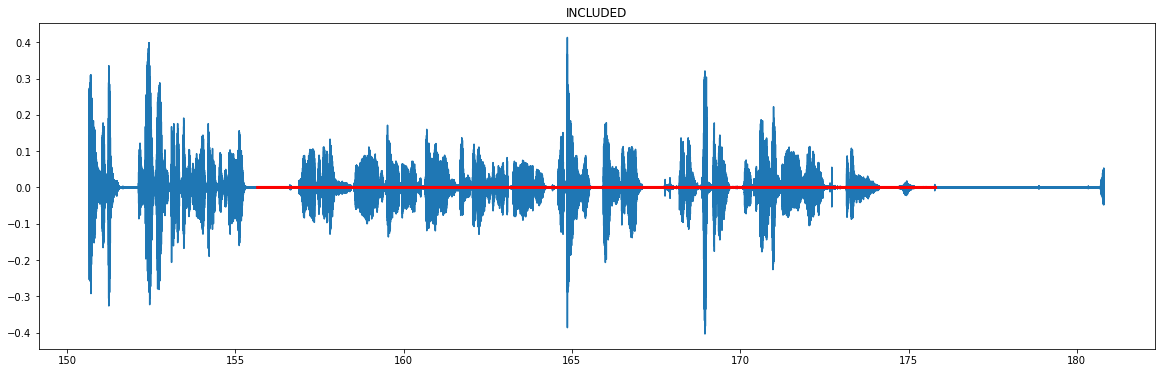

[NeMo I 2020-10-30 12:39:43 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 12:39:43 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |ciu nmà không phải là cái ấy đâu nó thay đâu đấy nó thay bông chứ không phải là nó thay chạy chại bống mới bả bông gép vôi súp lơ kẽm với ấy thôi chứ không phải là ừ|


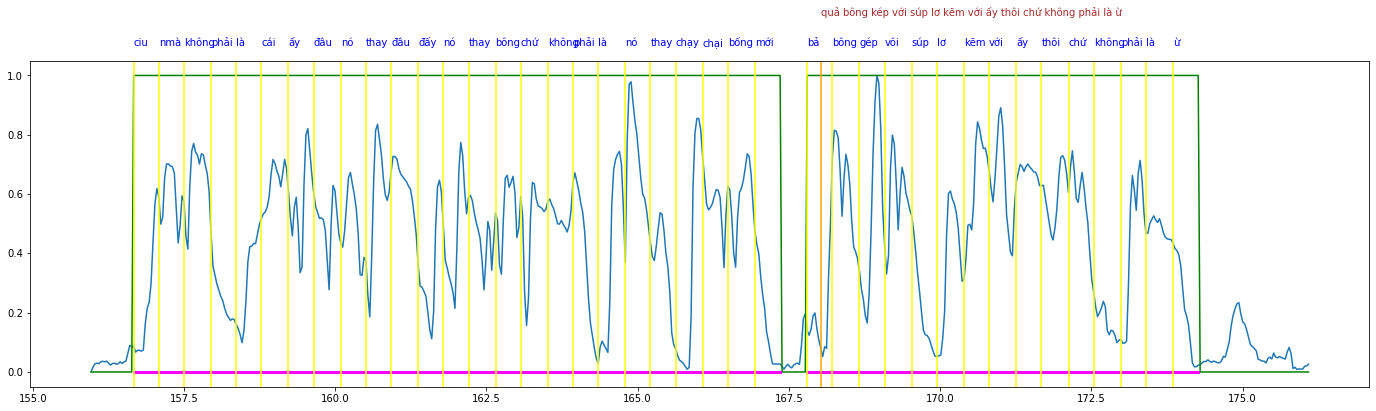

5495 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495]
READ_HEAD 5495
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 0: []
cutoff -78.44221105527639 #silences 0: []
cutoff -78.13065326633166 #silences 0: []
cutoff -77.81909547738694 #silences 1: [(9322, 9324)]
cutoff -77.50753768844221 #silences 9: [(1602, 1604), (4736, 4739), (9322, 9325), (9333, 9336), (10280, 10282), (10588, 10590), (11032, 11035), (11906, 11908), (12490, 12492)]
cutoff -77.19597989949749 #silences 32: [(319, 321), (961, 963), (1130, 1133), (1188, 1193), (1381, 1387), (1408, 1410), (1442, 1445), (1602, 1605), (3454, 3456), (4412, 4414)]
stop to read 5495 5814


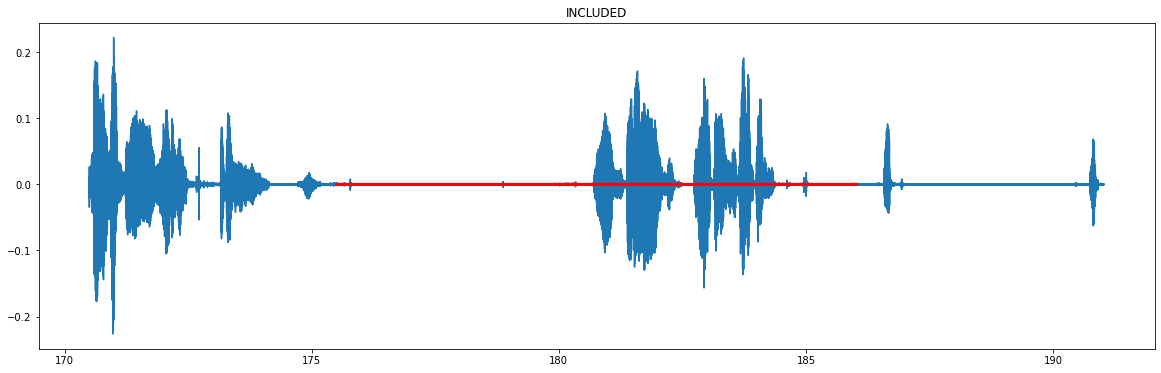

[NeMo I 2020-10-30 12:39:44 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 12:39:44 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |hảng đồi ấy đấy cá độ bón đá hấy tao ấy|


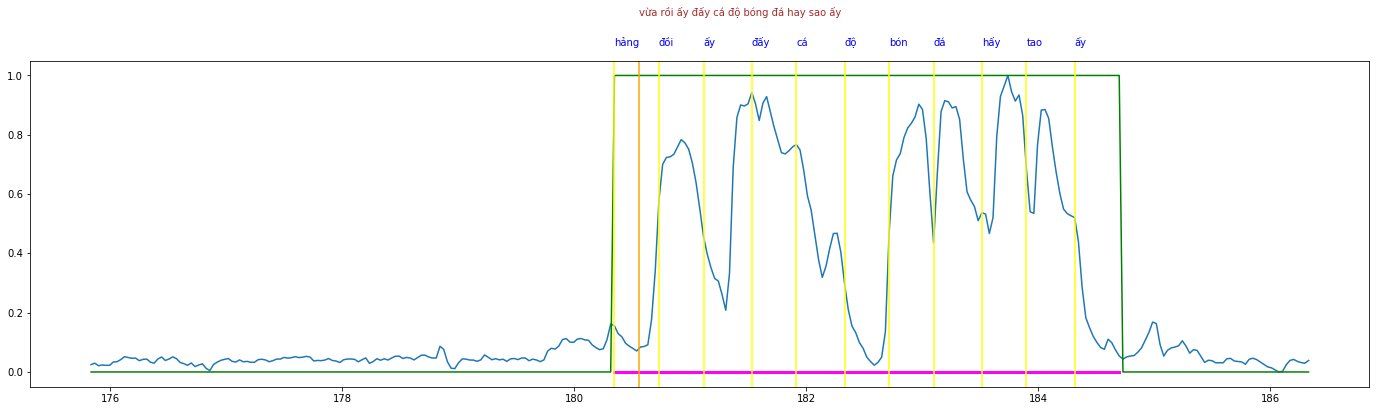

5814 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814]
READ_HEAD 5814
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 0: []
cutoff -78.44221105527639 #silences 0: []
cutoff -78.13065326633166 #silences 0: []
cutoff -77.81909547738694 #silences 1: [(9003, 9005)]
cutoff -77.50753768844221 #silences 9: [(1283, 1285), (4417, 4420), (9003, 9006), (9014, 9017), (9961, 9963), (10269, 10271), (10713, 10716), (11587, 11589), (12171, 12173)]
cutoff -77.19597989949749 #silences 32: [(0, 2), (642, 644), (811, 814), (869, 874), (1062, 1068), (1089, 1091), (1123, 1126), (1283, 1286), (3135, 3137), (4093, 4095)]
advance past silence 5816 2


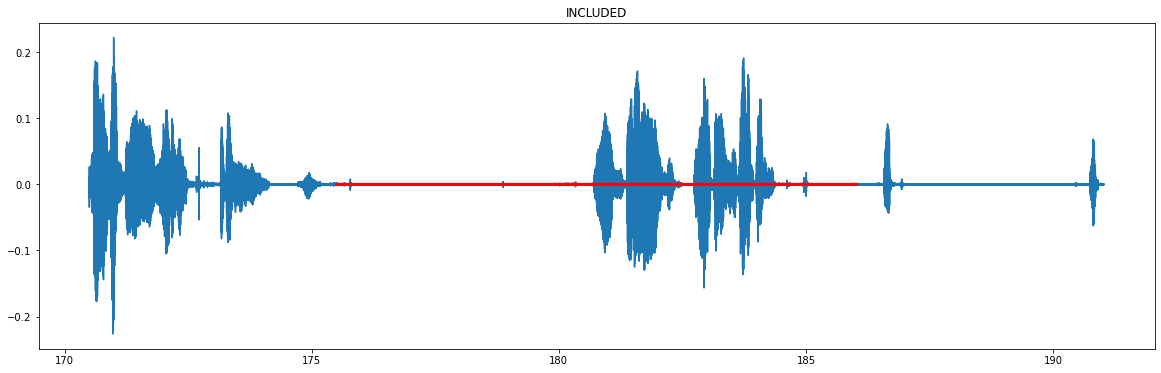

[NeMo I 2020-10-30 12:39:44 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 12:39:44 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |hản rồi ấy đấy cá độ bóng đá hấy tao ấy|


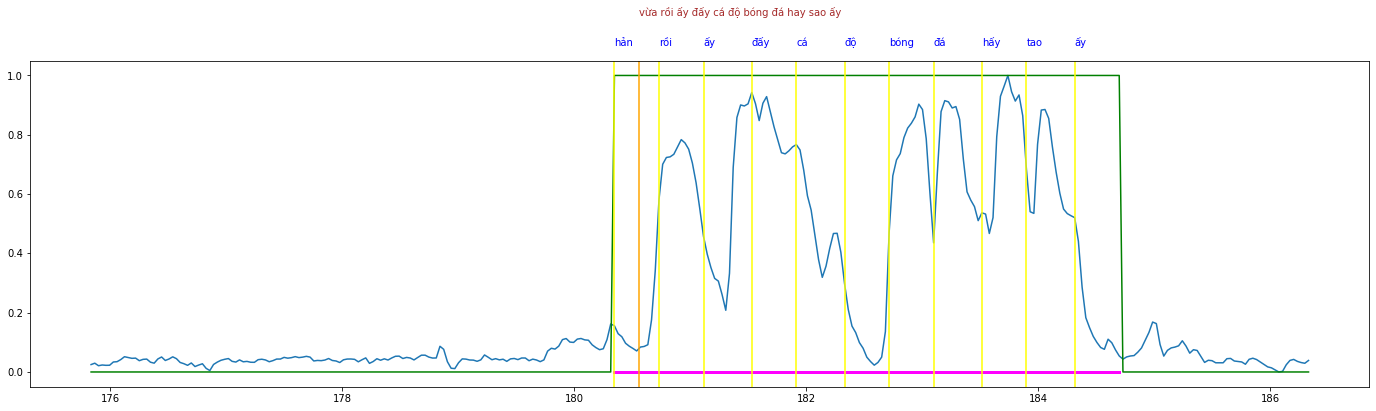

5816 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816]
READ_HEAD 5816
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 0: []
cutoff -78.44221105527639 #silences 0: []
cutoff -78.13065326633166 #silences 0: []
cutoff -77.81909547738694 #silences 1: [(9001, 9003)]
cutoff -77.50753768844221 #silences 9: [(1281, 1283), (4415, 4418), (9001, 9004), (9012, 9015), (9959, 9961), (10267, 10269), (10711, 10714), (11585, 11587), (12169, 12171)]
cutoff -77.19597989949749 #silences 31: [(640, 642), (809, 812), (867, 872), (1060, 1066), (1087, 1089), (1121, 1124), (1281, 1284), (3133, 3135), (4091, 4093), (4156, 4158)]
cutoff -76.88442211055276 #silences 109: [(182, 185), (311, 313

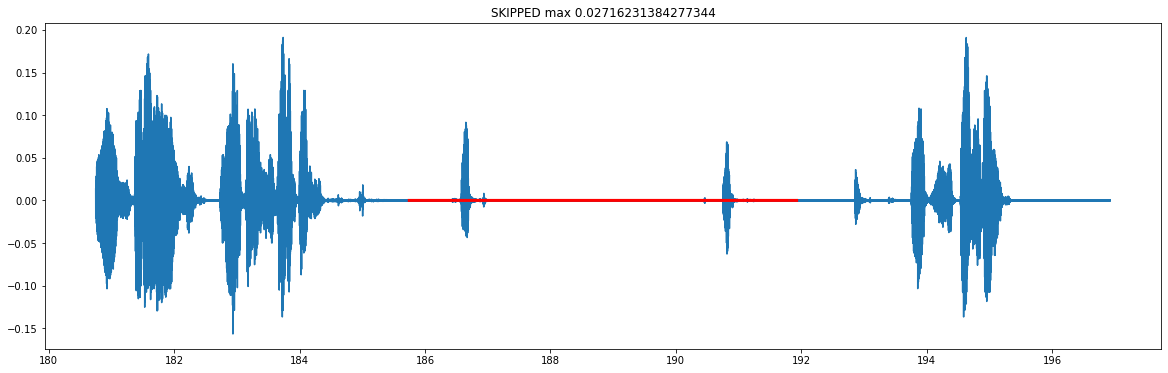

5998 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998]
READ_HEAD 5998
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 0: []
cutoff -78.44221105527639 #silences 0: []
cutoff -78.13065326633166 #silences 0: []
cutoff -77.81909547738694 #silences 1: [(8819, 8821)]
cutoff -77.50753768844221 #silences 9: [(1099, 1101), (4233, 4236), (8819, 8822), (8830, 8833), (9777, 9779), (10085, 10087), (10529, 10532), (11403, 11405), (11987, 11989)]
cutoff -77.19597989949749 #silences 31: [(458, 460), (627, 630), (685, 690), (878, 884), (905, 907), (939, 942), (1099, 1102), (2951, 2953), (3909, 3911), (3974, 3976)]
stop to read 5998 6456


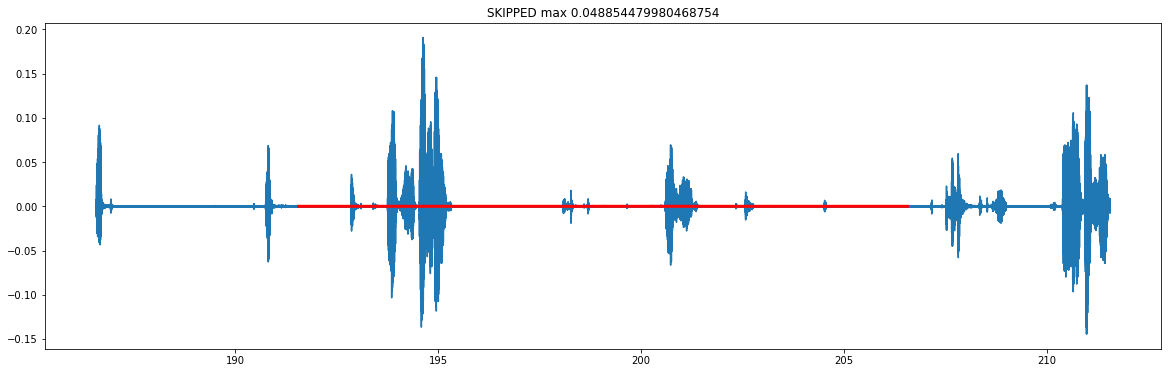

6456 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456]
READ_HEAD 6456
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 0: []
cutoff -78.44221105527639 #silences 0: []
cutoff -78.13065326633166 #silences 0: []
cutoff -77.81909547738694 #silences 1: [(8361, 8363)]
cutoff -77.50753768844221 #silences 9: [(641, 643), (3775, 3778), (8361, 8364), (8372, 8375), (9319, 9321), (9627, 9629), (10071, 10074), (10945, 10947), (11529, 11531)]
cutoff -77.19597989949749 #silences 31: [(0, 2), (169, 172), (227, 232), (420, 426), (447, 449), (481, 484), (641, 644), (2493, 2495), (3451, 3453), (3516, 3518)]
advance past silence 6458 2


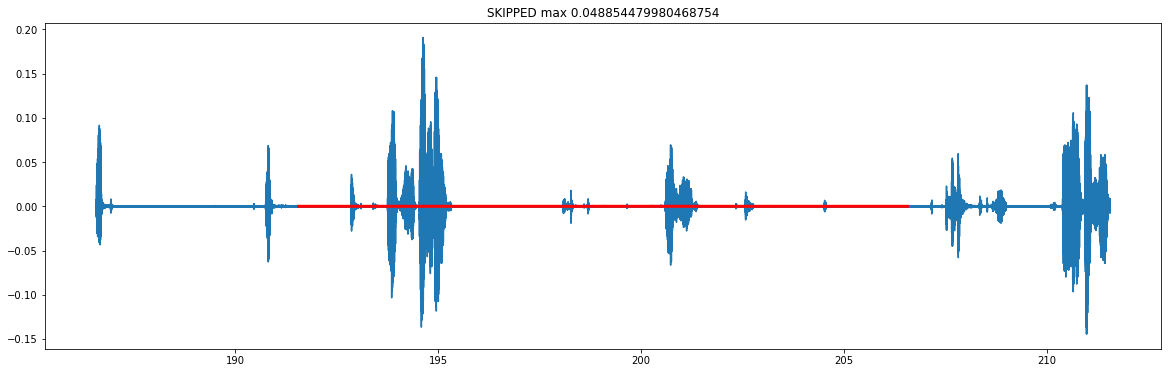

6458 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458]
READ_HEAD 6458
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 0: []
cutoff -78.44221105527639 #silences 0: []
cutoff -78.13065326633166 #silences 0: []
cutoff -77.81909547738694 #silences 1: [(8359, 8361)]
cutoff -77.50753768844221 #silences 9: [(639, 641), (3773, 3776), (8359, 8362), (8370, 8373), (9317, 9319), (9625, 9627), (10069, 10072), (10943, 10945), (11527, 11529)]
cutoff -77.19597989949749 #silences 30: [(167, 170), (225, 230), (418, 424), (445, 447), (479, 482), (639, 642), (2491, 2493), (3449, 3451), (3514, 3516), (3772, 3776)]
stop to read 6458 6625


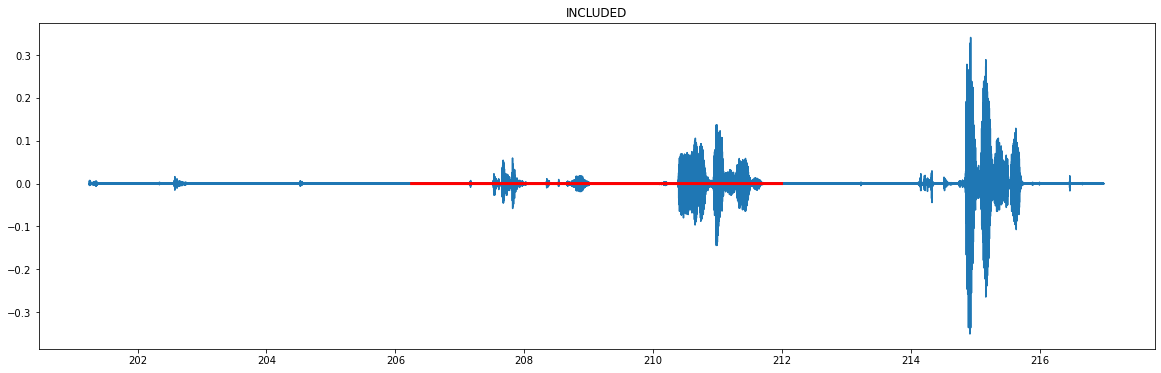

[NeMo I 2020-10-30 12:39:45 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 12:39:45 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |tôg sáng hôi đấy|


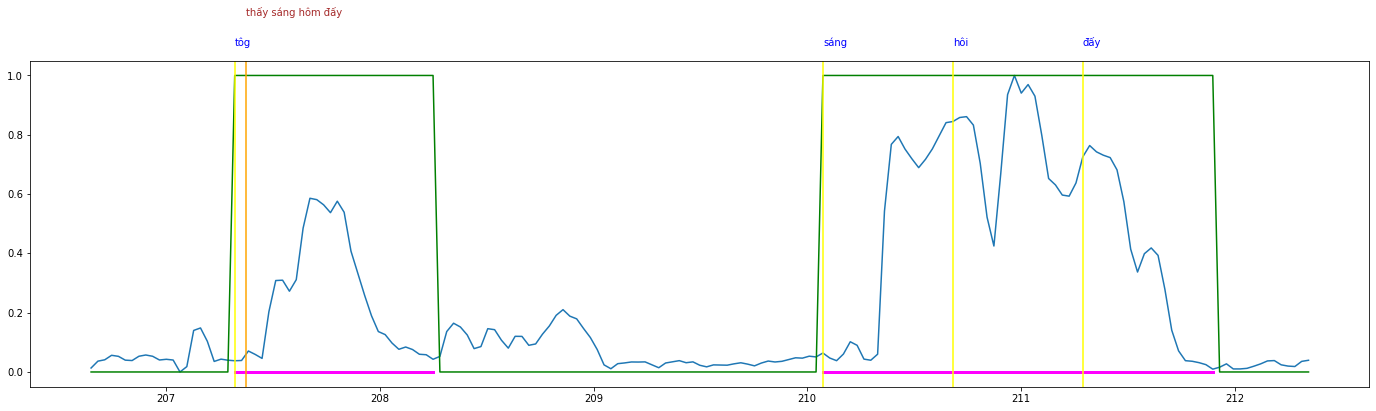

6625 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625]
READ_HEAD 6625
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 0: []
cutoff -78.44221105527639 #silences 0: []
cutoff -78.13065326633166 #silences 0: []
cutoff -77.81909547738694 #silences 1: [(8192, 8194)]
cutoff -77.50753768844221 #silences 9: [(472, 474), (3606, 3609), (8192, 8195), (8203, 8206), (9150, 9152), (9458, 9460), (9902, 9905), (10776, 10778), (11360, 11362)]
stop to read 6625 7097


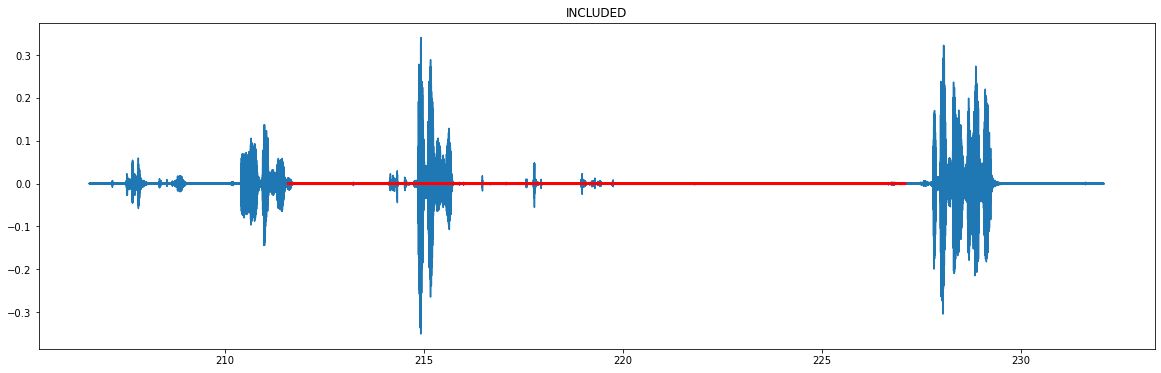

[NeMo I 2020-10-30 12:39:45 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 12:39:45 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |xâ ăn tấy báo đi|


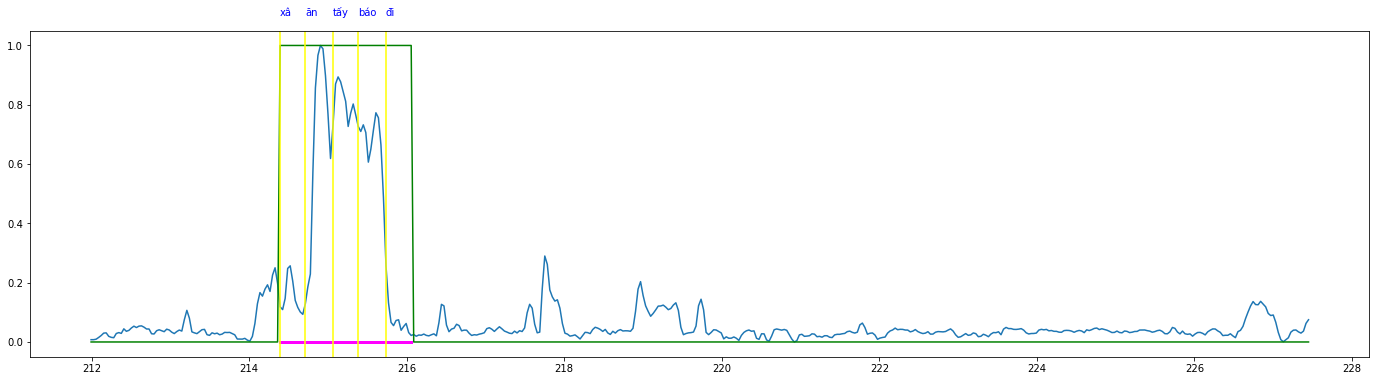

7097 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097]
READ_HEAD 7097
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 0: []
cutoff -78.44221105527639 #silences 0: []
cutoff -78.13065326633166 #silences 0: []
cutoff -77.81909547738694 #silences 1: [(7720, 7722)]
cutoff -77.50753768844221 #silences 9: [(0, 2), (3134, 3137), (7720, 7723), (7731, 7734), (8678, 8680), (8986, 8988), (9430, 9433), (10304, 10306), (10888, 10890)]
advance past silence 7099 2


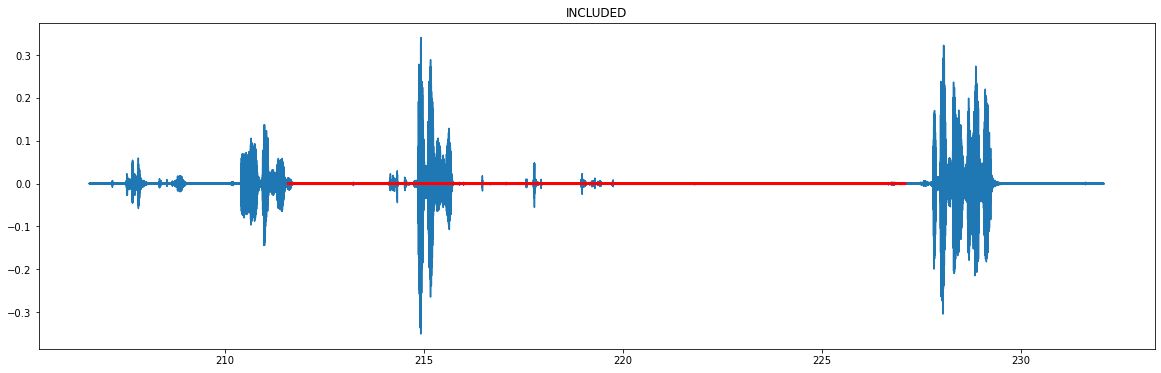

[NeMo I 2020-10-30 12:39:46 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 12:39:46 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |xâ ăn tấy báo đi|


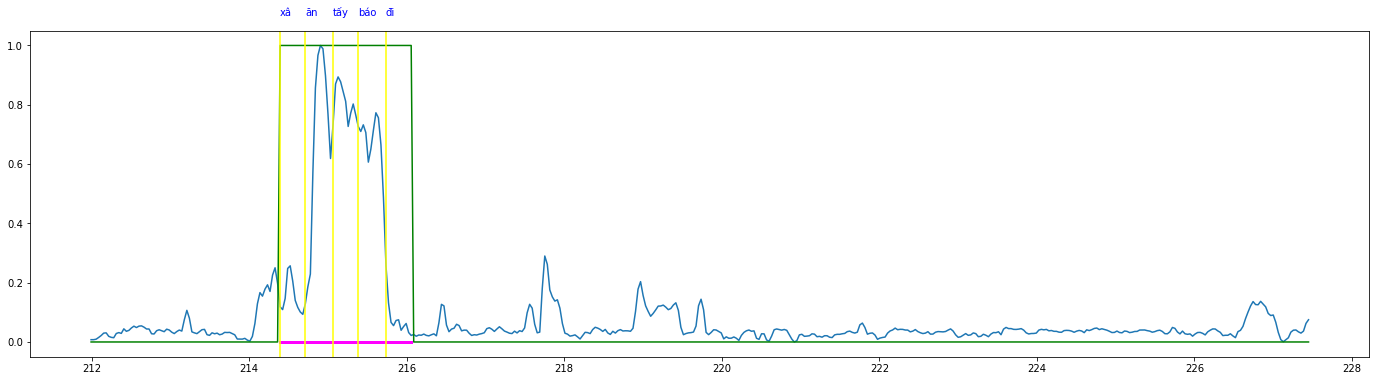

7099 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099]
READ_HEAD 7099
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 0: []
cutoff -78.44221105527639 #silences 0: []
cutoff -78.13065326633166 #silences 0: []
cutoff -77.81909547738694 #silences 1: [(7718, 7720)]
cutoff -77.50753768844221 #silences 8: [(3132, 3135), (7718, 7721), (7729, 7732), (8676, 8678), (8984, 8986), (9428, 9431), (10302, 10304), (10886, 10888)]
cutoff -77.19597989949749 #silences 24: [(1850, 1852), (2808, 2810), (2873, 2875), (3131, 3135), (4596, 4598), (6149, 6155), (6557, 6560), (7491, 7493), (7717, 7732), (7751, 7754)]
cutoff -76.88442211055276 #silences 82:

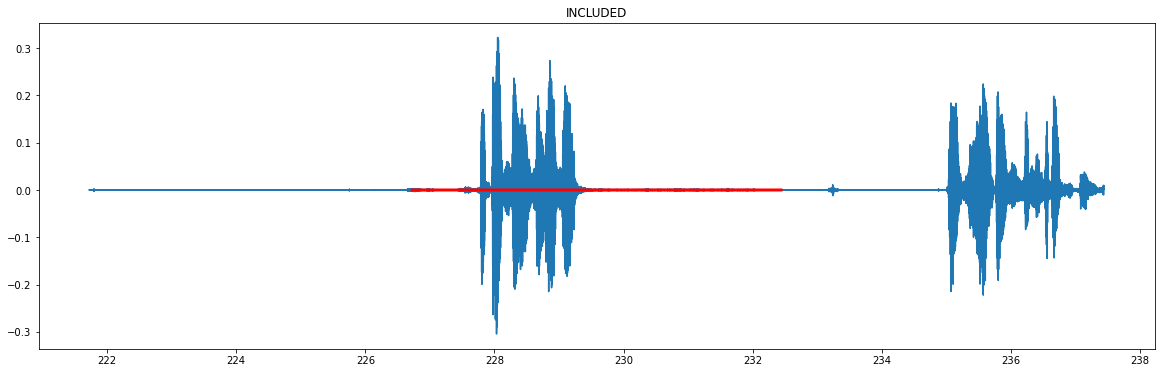

[NeMo I 2020-10-30 12:39:46 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 12:39:46 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |thết sáng hôm đấy anh mấy dầnh về|


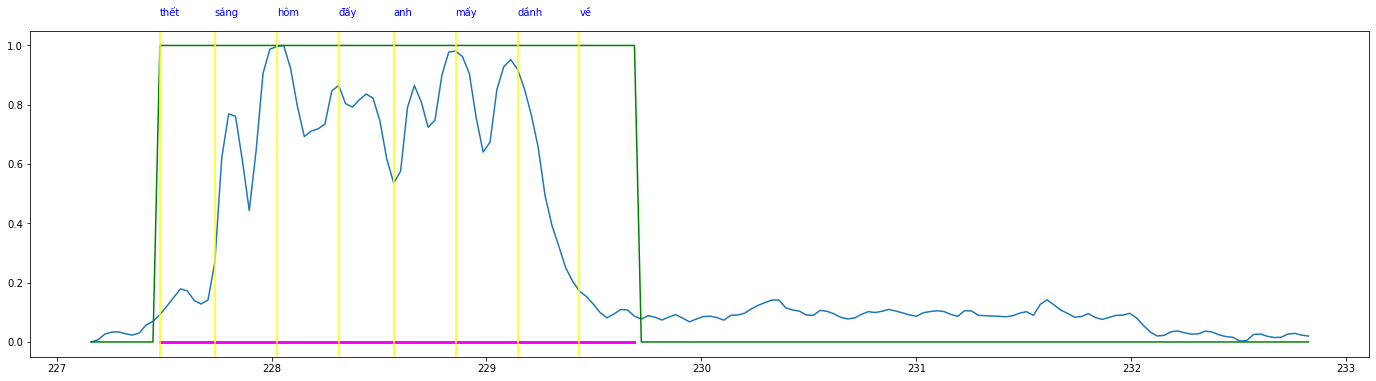

7264 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264]
READ_HEAD 7264
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 0: []
cutoff -78.44221105527639 #silences 0: []
cutoff -78.13065326633166 #silences 0: []
cutoff -77.81909547738694 #silences 1: [(7553, 7555)]
cutoff -77.50753768844221 #silences 8: [(2967, 2970), (7553, 7556), (7564, 7567), (8511, 8513), (8819, 8821), (9263, 9266), (10137, 10139), (10721, 10723)]
cutoff -77.19597989949749 #silences 24: [(1685, 1687), (2643, 2645), (2708, 2710), (2966, 2970), (4431, 4433), (5984, 5990), (6392, 6395), (7326, 7328), (7552, 7567), (7586, 7589)]
cutoff -76.88442211055276 #silenc

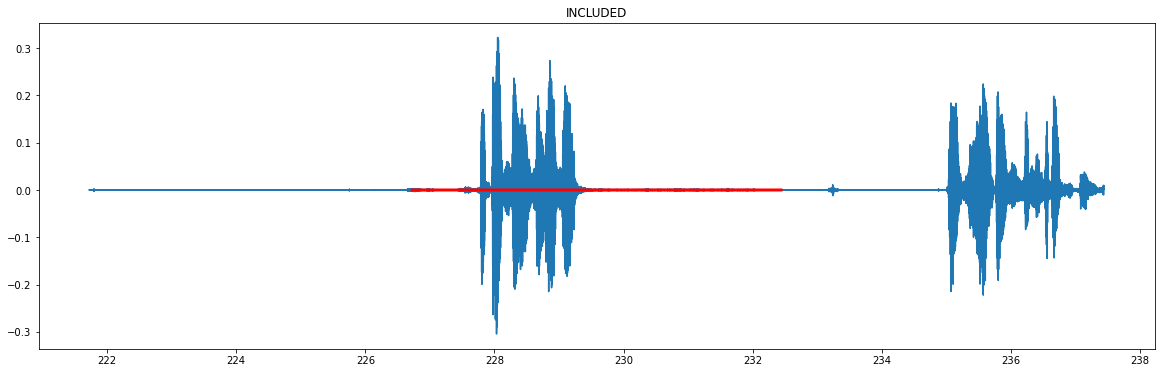

[NeMo I 2020-10-30 12:39:46 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 12:39:46 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |thết sáng hôm đấy anh mấy dầnh về|


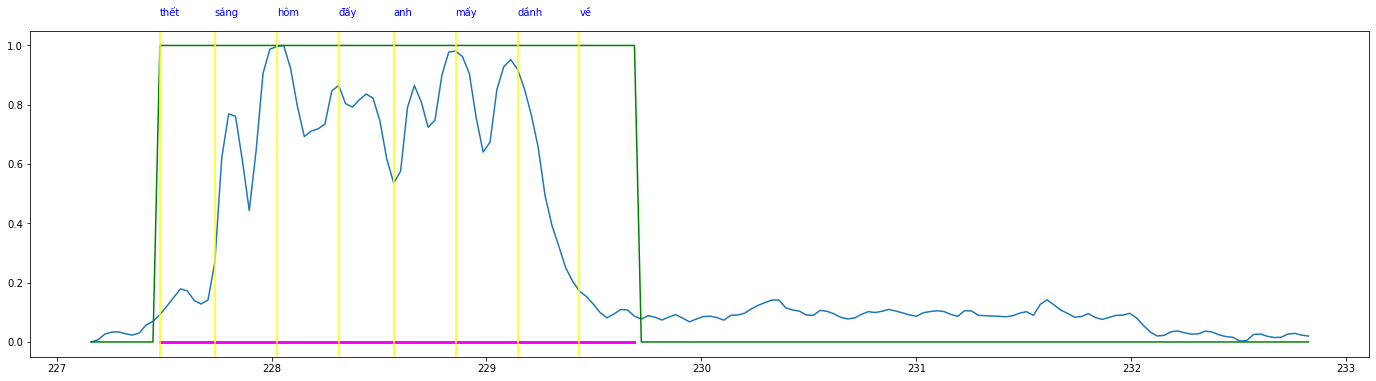

7267 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267]
READ_HEAD 7267
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 0: []
cutoff -78.44221105527639 #silences 0: []
cutoff -78.13065326633166 #silences 0: []
cutoff -77.81909547738694 #silences 1: [(7550, 7552)]
cutoff -77.50753768844221 #silences 8: [(2964, 2967), (7550, 7553), (7561, 7564), (8508, 8510), (8816, 8818), (9260, 9263), (10134, 10136), (10718, 10720)]
cutoff -77.19597989949749 #silences 24: [(1682, 1684), (2640, 2642), (2705, 2707), (2963, 2967), (4428, 4430), (5981, 5987), (6389, 6392), (7323, 7325), (7549, 7564), (7583, 7586)]
cutoff -76.88442211055276 #

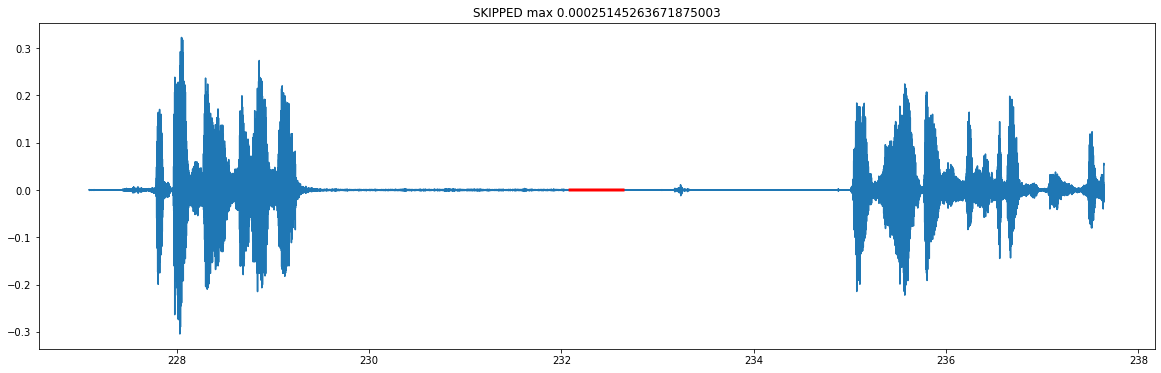

7270 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270]
READ_HEAD 7270
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 0: []
cutoff -78.44221105527639 #silences 0: []
cutoff -78.13065326633166 #silences 0: []
cutoff -77.81909547738694 #silences 1: [(7547, 7549)]
cutoff -77.50753768844221 #silences 8: [(2961, 2964), (7547, 7550), (7558, 7561), (8505, 8507), (8813, 8815), (9257, 9260), (10131, 10133), (10715, 10717)]
cutoff -77.19597989949749 #silences 24: [(1679, 1681), (2637, 2639), (2702, 2704), (2960, 2964), (4425, 4427), (5978, 5984), (6386, 6389), (7320, 7322), (7546, 7561), (7580, 7583)]
cutoff -76.8844221105

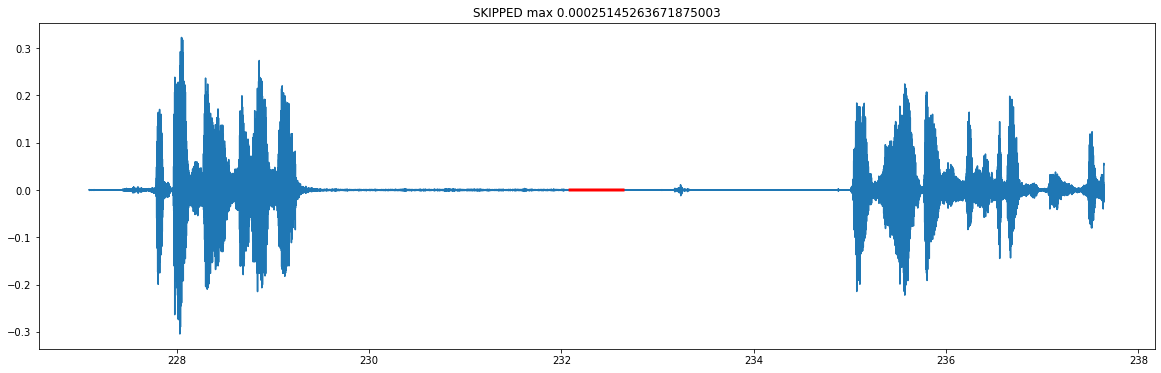

7272 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272]
READ_HEAD 7272
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 0: []
cutoff -78.44221105527639 #silences 0: []
cutoff -78.13065326633166 #silences 0: []
cutoff -77.81909547738694 #silences 1: [(7545, 7547)]
cutoff -77.50753768844221 #silences 8: [(2959, 2962), (7545, 7548), (7556, 7559), (8503, 8505), (8811, 8813), (9255, 9258), (10129, 10131), (10713, 10715)]
cutoff -77.19597989949749 #silences 24: [(1677, 1679), (2635, 2637), (2700, 2702), (2958, 2962), (4423, 4425), (5976, 5982), (6384, 6387), (7318, 7320), (7544, 7559), (7578, 7581)]
cutoff -76.8844

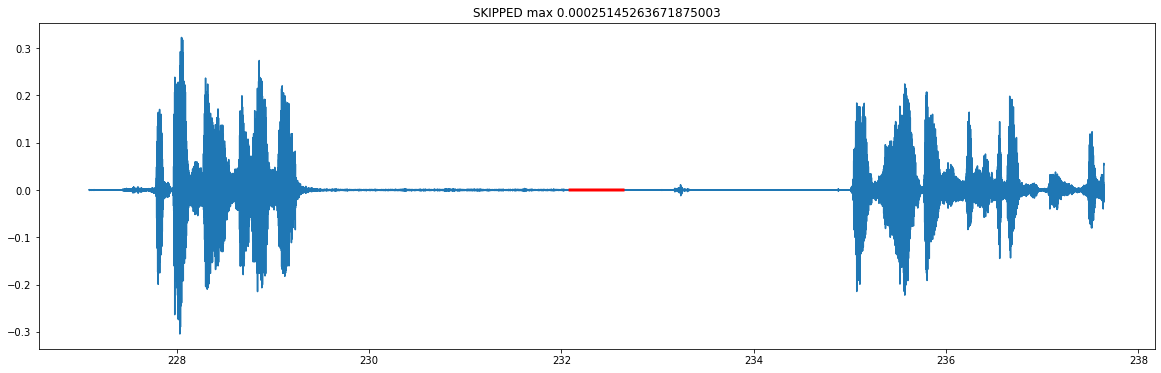

7283 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283]
READ_HEAD 7283
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 0: []
cutoff -78.44221105527639 #silences 0: []
cutoff -78.13065326633166 #silences 0: []
cutoff -77.81909547738694 #silences 1: [(7534, 7536)]
cutoff -77.50753768844221 #silences 8: [(2948, 2951), (7534, 7537), (7545, 7548), (8492, 8494), (8800, 8802), (9244, 9247), (10118, 10120), (10702, 10704)]
cutoff -77.19597989949749 #silences 24: [(1666, 1668), (2624, 2626), (2689, 2691), (2947, 2951), (4412, 4414), (5965, 5971), (6373, 6376), (7307, 7309), (7533, 7548), (7567, 7570)]
cutoff -7

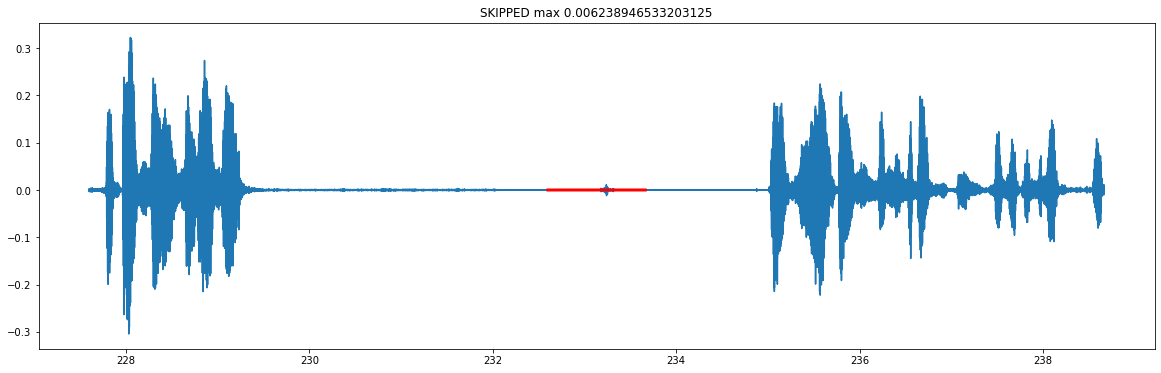

7302 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302]
READ_HEAD 7302
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 0: []
cutoff -78.44221105527639 #silences 0: []
cutoff -78.13065326633166 #silences 0: []
cutoff -77.81909547738694 #silences 1: [(7515, 7517)]
cutoff -77.50753768844221 #silences 8: [(2929, 2932), (7515, 7518), (7526, 7529), (8473, 8475), (8781, 8783), (9225, 9228), (10099, 10101), (10683, 10685)]
cutoff -77.19597989949749 #silences 24: [(1647, 1649), (2605, 2607), (2670, 2672), (2928, 2932), (4393, 4395), (5946, 5952), (6354, 6357), (7288, 7290), (7514, 7529), (7548, 7551)]
cut

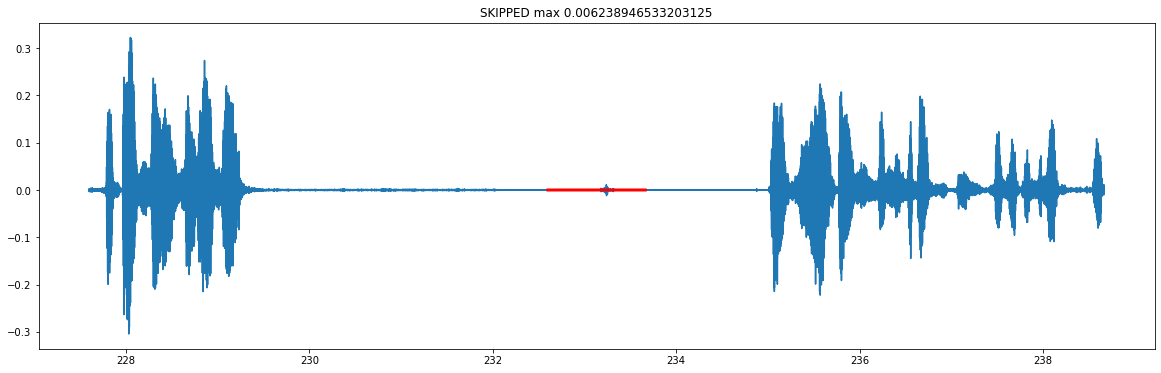

7308 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308]
READ_HEAD 7308
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 0: []
cutoff -78.44221105527639 #silences 0: []
cutoff -78.13065326633166 #silences 0: []
cutoff -77.81909547738694 #silences 1: [(7509, 7511)]
cutoff -77.50753768844221 #silences 8: [(2923, 2926), (7509, 7512), (7520, 7523), (8467, 8469), (8775, 8777), (9219, 9222), (10093, 10095), (10677, 10679)]
cutoff -77.19597989949749 #silences 24: [(1641, 1643), (2599, 2601), (2664, 2666), (2922, 2926), (4387, 4389), (5940, 5946), (6348, 6351), (7282, 7284), (7508, 7523), (7542, 7545

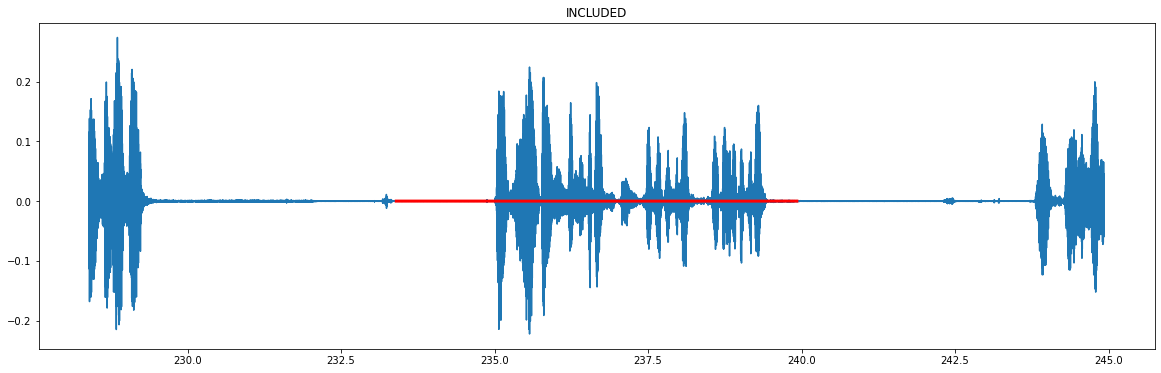

[NeMo I 2020-10-30 12:39:47 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 12:39:47 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |ấ onh đy em thắn l năm giờ két đờmm hay saoy năm giờ kẩm mười lăm à sáu riờ kem mời lăm|


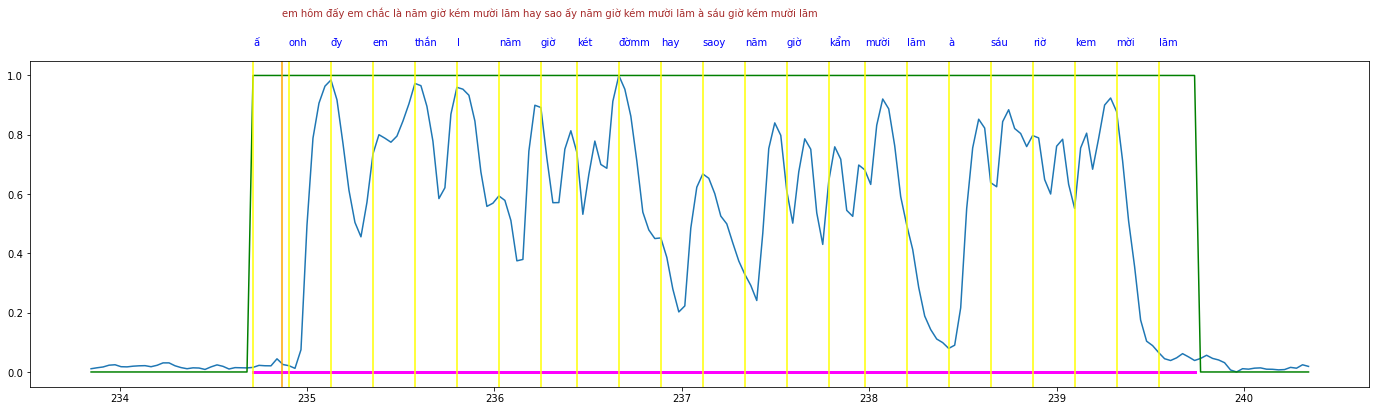

7498 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498]
READ_HEAD 7498
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 0: []
cutoff -78.44221105527639 #silences 0: []
cutoff -78.13065326633166 #silences 0: []
cutoff -77.81909547738694 #silences 1: [(7319, 7321)]
cutoff -77.50753768844221 #silences 8: [(2733, 2736), (7319, 7322), (7330, 7333), (8277, 8279), (8585, 8587), (9029, 9032), (9903, 9905), (10487, 10489)]
cutoff -77.19597989949749 #silences 24: [(1451, 1453), (2409, 2411), (2474, 2476), (2732, 2736), (4197, 4199), (5750, 5756), (6158, 6161), (7092, 7094), (7318, 7333), (7352, 

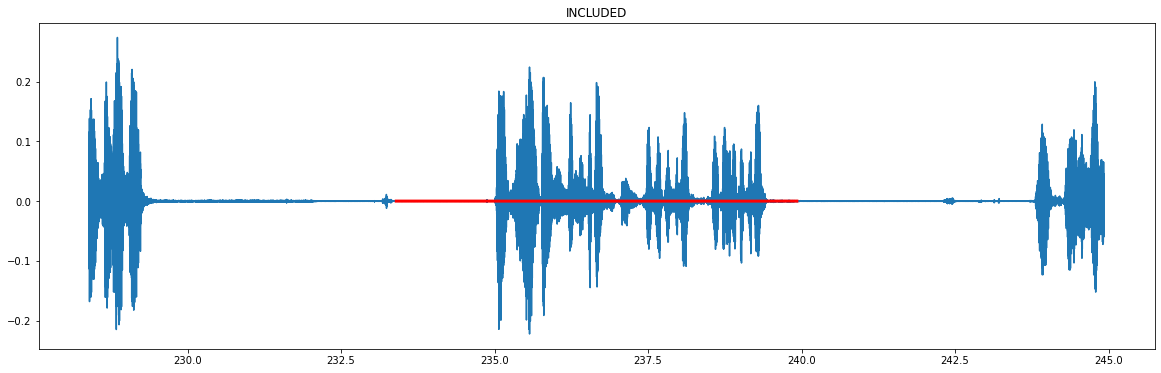

[NeMo I 2020-10-30 12:39:48 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 12:39:48 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |ấ onh đy em thắm năm giờ két đờm m hay saoy năm giờ kém mười lăm à sáu riờ kem mời lăm|


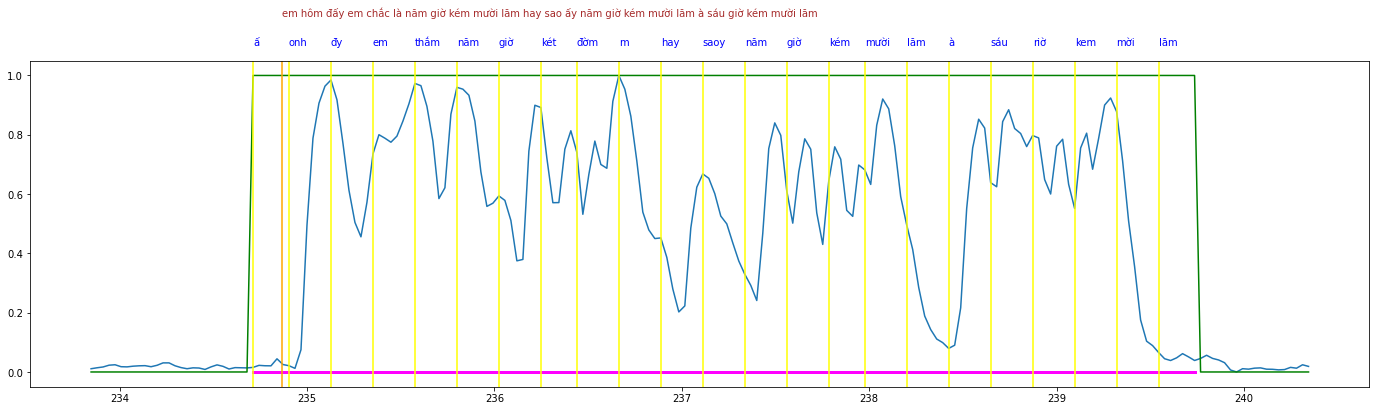

7501 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501]
READ_HEAD 7501
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 0: []
cutoff -78.44221105527639 #silences 0: []
cutoff -78.13065326633166 #silences 0: []
cutoff -77.81909547738694 #silences 1: [(7316, 7318)]
cutoff -77.50753768844221 #silences 8: [(2730, 2733), (7316, 7319), (7327, 7330), (8274, 8276), (8582, 8584), (9026, 9029), (9900, 9902), (10484, 10486)]
cutoff -77.19597989949749 #silences 24: [(1448, 1450), (2406, 2408), (2471, 2473), (2729, 2733), (4194, 4196), (5747, 5753), (6155, 6158), (7089, 7091), (7315, 7330), (

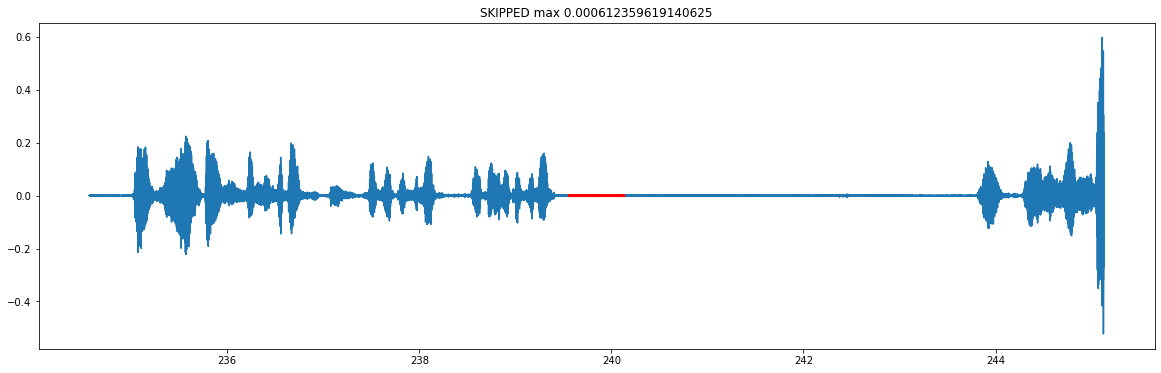

7504 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504]
READ_HEAD 7504
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 0: []
cutoff -78.44221105527639 #silences 0: []
cutoff -78.13065326633166 #silences 0: []
cutoff -77.81909547738694 #silences 1: [(7313, 7315)]
cutoff -77.50753768844221 #silences 8: [(2727, 2730), (7313, 7316), (7324, 7327), (8271, 8273), (8579, 8581), (9023, 9026), (9897, 9899), (10481, 10483)]
cutoff -77.19597989949749 #silences 24: [(1445, 1447), (2403, 2405), (2468, 2470), (2726, 2730), (4191, 4193), (5744, 5750), (6152, 6155), (7086, 7088), (7312, 73

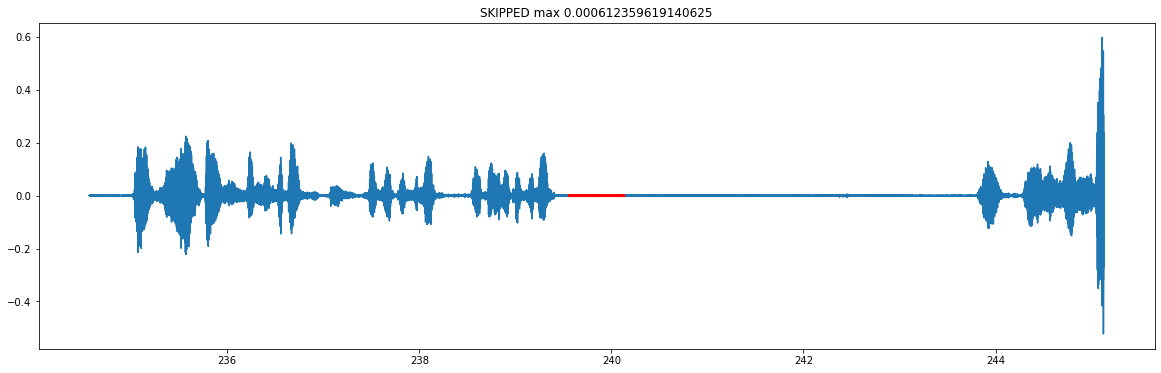

7507 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507]
READ_HEAD 7507
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 0: []
cutoff -78.44221105527639 #silences 0: []
cutoff -78.13065326633166 #silences 0: []
cutoff -77.81909547738694 #silences 1: [(7310, 7312)]
cutoff -77.50753768844221 #silences 8: [(2724, 2727), (7310, 7313), (7321, 7324), (8268, 8270), (8576, 8578), (9020, 9023), (9894, 9896), (10478, 10480)]
cutoff -77.19597989949749 #silences 24: [(1442, 1444), (2400, 2402), (2465, 2467), (2723, 2727), (4188, 4190), (5741, 5747), (6149, 6152), (7083, 7085), (73

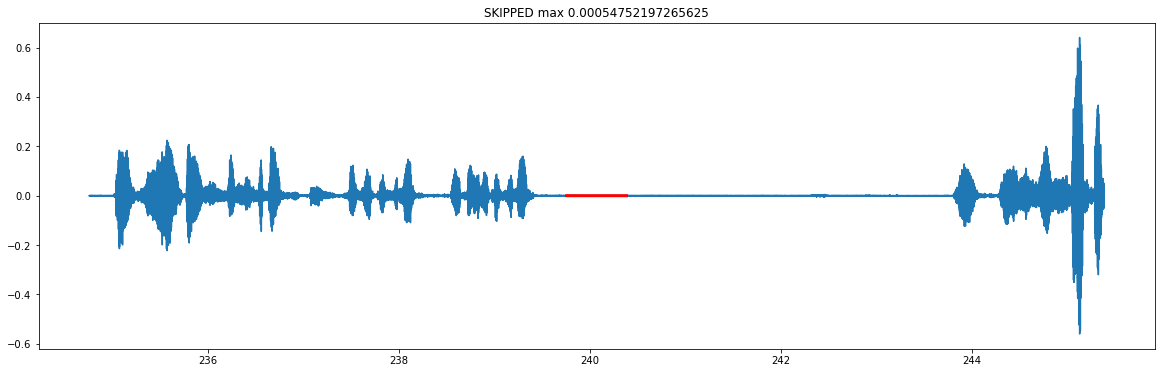

7512 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512]
READ_HEAD 7512
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 0: []
cutoff -78.44221105527639 #silences 0: []
cutoff -78.13065326633166 #silences 0: []
cutoff -77.81909547738694 #silences 1: [(7305, 7307)]
cutoff -77.50753768844221 #silences 8: [(2719, 2722), (7305, 7308), (7316, 7319), (8263, 8265), (8571, 8573), (9015, 9018), (9889, 9891), (10473, 10475)]
cutoff -77.19597989949749 #silences 24: [(1437, 1439), (2395, 2397), (2460, 2462), (2718, 2722), (4183, 4185), (5736, 5742), (6144, 6147), (7078, 7080

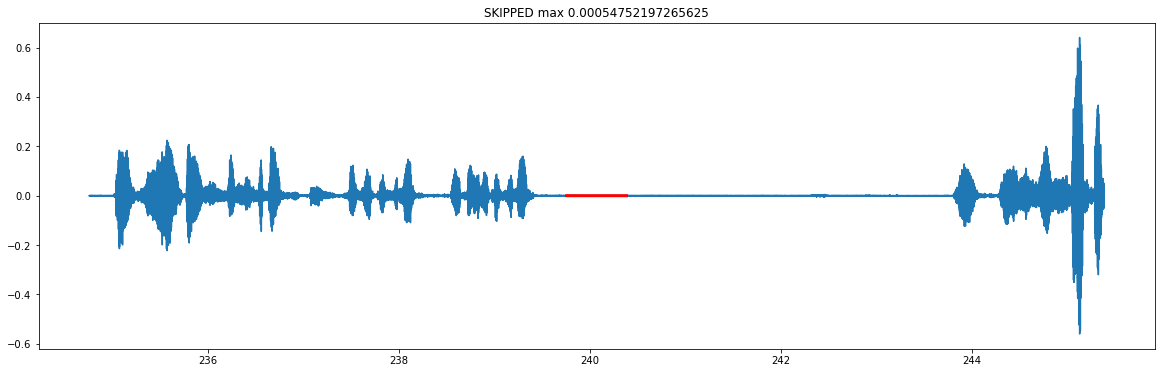

7518 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512, 7518]
READ_HEAD 7518
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 0: []
cutoff -78.44221105527639 #silences 0: []
cutoff -78.13065326633166 #silences 0: []
cutoff -77.81909547738694 #silences 1: [(7299, 7301)]
cutoff -77.50753768844221 #silences 8: [(2713, 2716), (7299, 7302), (7310, 7313), (8257, 8259), (8565, 8567), (9009, 9012), (9883, 9885), (10467, 10469)]
cutoff -77.19597989949749 #silences 24: [(1431, 1433), (2389, 2391), (2454, 2456), (2712, 2716), (4177, 4179), (5730, 5736), (6138, 6141), (7072

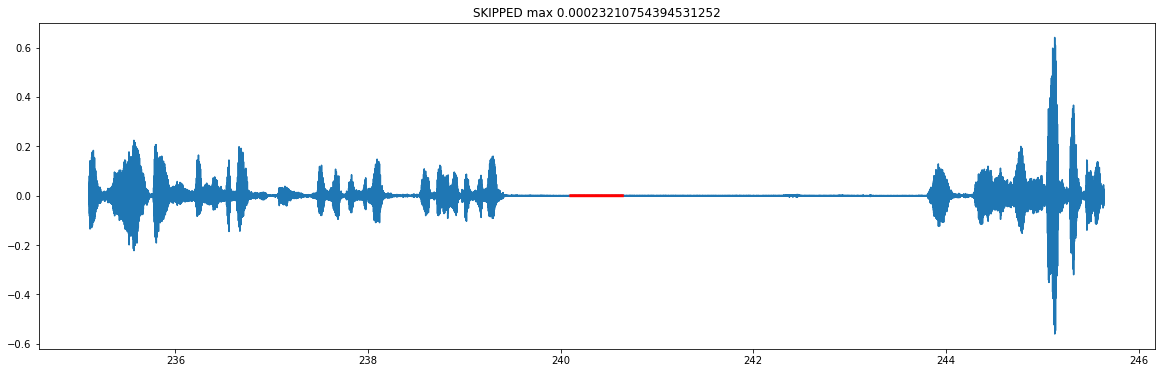

7520 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512, 7518, 7520]
READ_HEAD 7520
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 0: []
cutoff -78.44221105527639 #silences 0: []
cutoff -78.13065326633166 #silences 0: []
cutoff -77.81909547738694 #silences 1: [(7297, 7299)]
cutoff -77.50753768844221 #silences 8: [(2711, 2714), (7297, 7300), (7308, 7311), (8255, 8257), (8563, 8565), (9007, 9010), (9881, 9883), (10465, 10467)]
cutoff -77.19597989949749 #silences 24: [(1429, 1431), (2387, 2389), (2452, 2454), (2710, 2714), (4175, 4177), (5728, 5734), (6136, 6139),

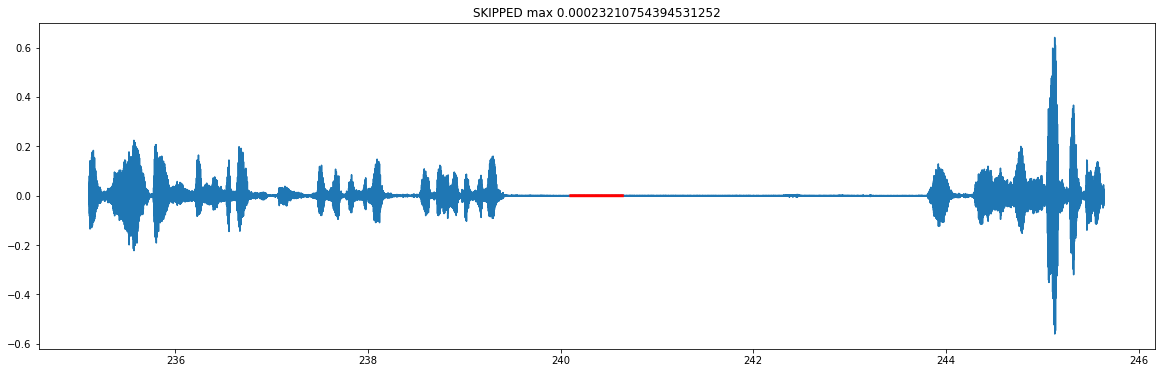

7530 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512, 7518, 7520, 7530]
READ_HEAD 7530
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 0: []
cutoff -78.44221105527639 #silences 0: []
cutoff -78.13065326633166 #silences 0: []
cutoff -77.81909547738694 #silences 1: [(7287, 7289)]
cutoff -77.50753768844221 #silences 8: [(2701, 2704), (7287, 7290), (7298, 7301), (8245, 8247), (8553, 8555), (8997, 9000), (9871, 9873), (10455, 10457)]
cutoff -77.19597989949749 #silences 24: [(1419, 1421), (2377, 2379), (2442, 2444), (2700, 2704), (4165, 4167), (5718, 5724), (6126, 

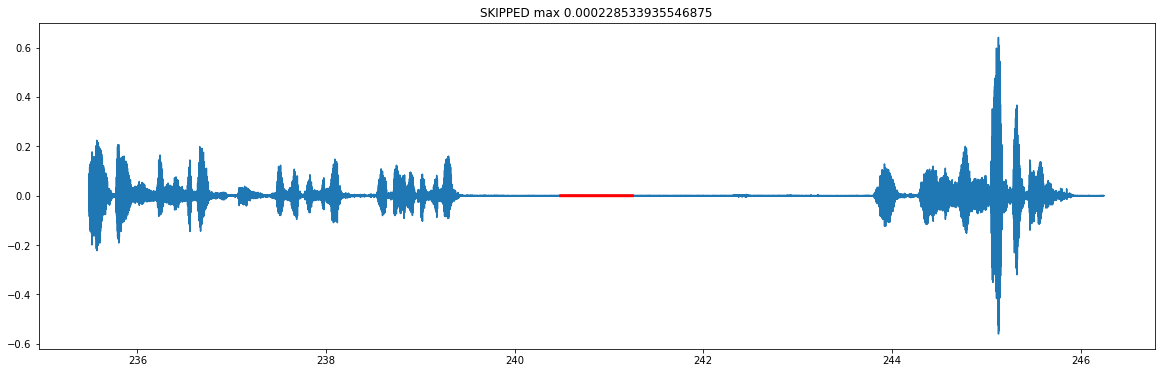

7539 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512, 7518, 7520, 7530, 7539]
READ_HEAD 7539
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 0: []
cutoff -78.44221105527639 #silences 0: []
cutoff -78.13065326633166 #silences 0: []
cutoff -77.81909547738694 #silences 1: [(7278, 7280)]
cutoff -77.50753768844221 #silences 8: [(2692, 2695), (7278, 7281), (7289, 7292), (8236, 8238), (8544, 8546), (8988, 8991), (9862, 9864), (10446, 10448)]
cutoff -77.19597989949749 #silences 24: [(1410, 1412), (2368, 2370), (2433, 2435), (2691, 2695), (4156, 4158), (5709, 5715), (

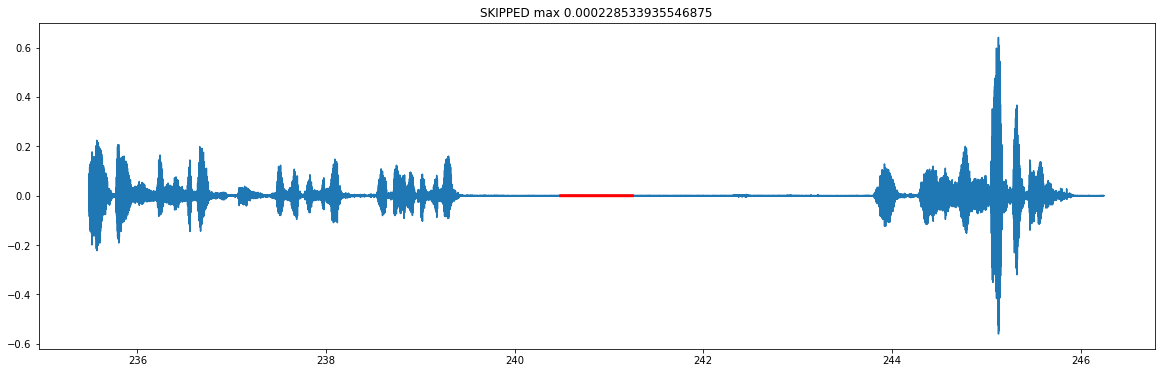

7541 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512, 7518, 7520, 7530, 7539, 7541]
READ_HEAD 7541
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 0: []
cutoff -78.44221105527639 #silences 0: []
cutoff -78.13065326633166 #silences 0: []
cutoff -77.81909547738694 #silences 1: [(7276, 7278)]
cutoff -77.50753768844221 #silences 8: [(2690, 2693), (7276, 7279), (7287, 7290), (8234, 8236), (8542, 8544), (8986, 8989), (9860, 9862), (10444, 10446)]
cutoff -77.19597989949749 #silences 24: [(1408, 1410), (2366, 2368), (2431, 2433), (2689, 2693), (4154, 4156), (5707, 57

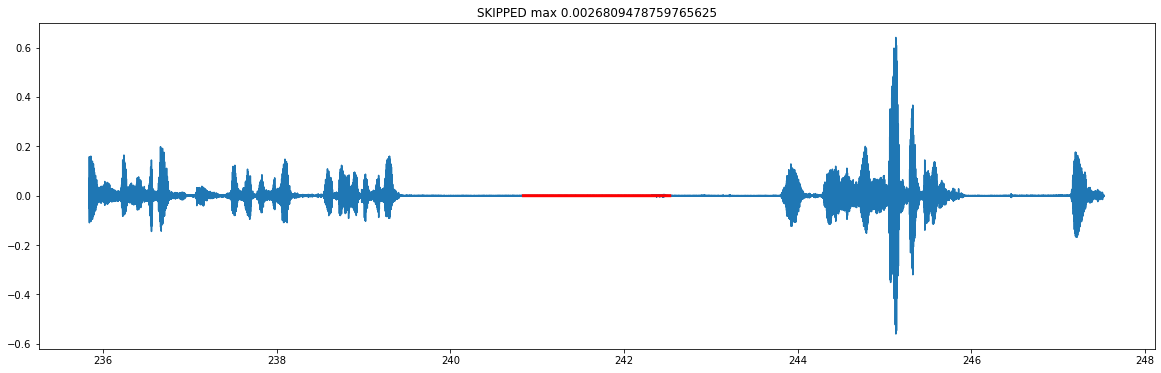

7579 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512, 7518, 7520, 7530, 7539, 7541, 7579]
READ_HEAD 7579
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 0: []
cutoff -78.44221105527639 #silences 0: []
cutoff -78.13065326633166 #silences 0: []
cutoff -77.81909547738694 #silences 1: [(7238, 7240)]
cutoff -77.50753768844221 #silences 8: [(2652, 2655), (7238, 7241), (7249, 7252), (8196, 8198), (8504, 8506), (8948, 8951), (9822, 9824), (10406, 10408)]
cutoff -77.19597989949749 #silences 24: [(1370, 1372), (2328, 2330), (2393, 2395), (2651, 2655), (4116, 4118), (56

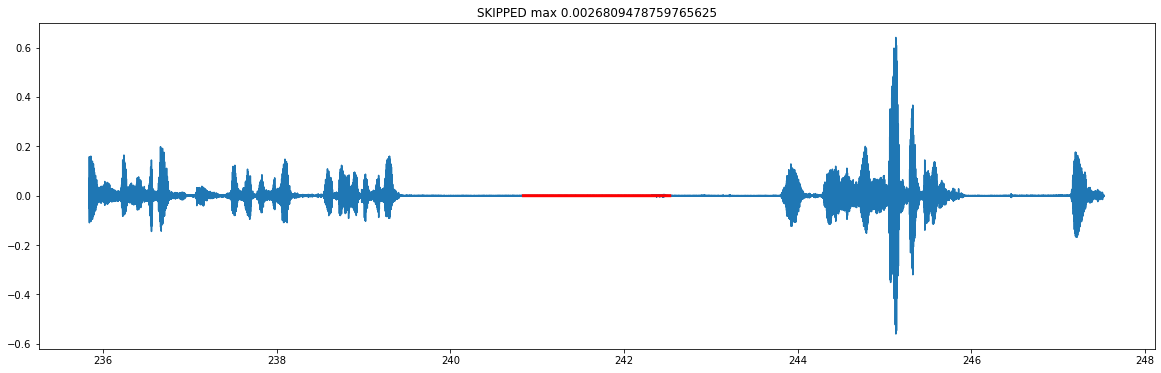

7582 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512, 7518, 7520, 7530, 7539, 7541, 7579, 7582]
READ_HEAD 7582
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 0: []
cutoff -78.44221105527639 #silences 0: []
cutoff -78.13065326633166 #silences 0: []
cutoff -77.81909547738694 #silences 1: [(7235, 7237)]
cutoff -77.50753768844221 #silences 8: [(2649, 2652), (7235, 7238), (7246, 7249), (8193, 8195), (8501, 8503), (8945, 8948), (9819, 9821), (10403, 10405)]
cutoff -77.19597989949749 #silences 24: [(1367, 1369), (2325, 2327), (2390, 2392), (2648, 2652), (4113, 4115

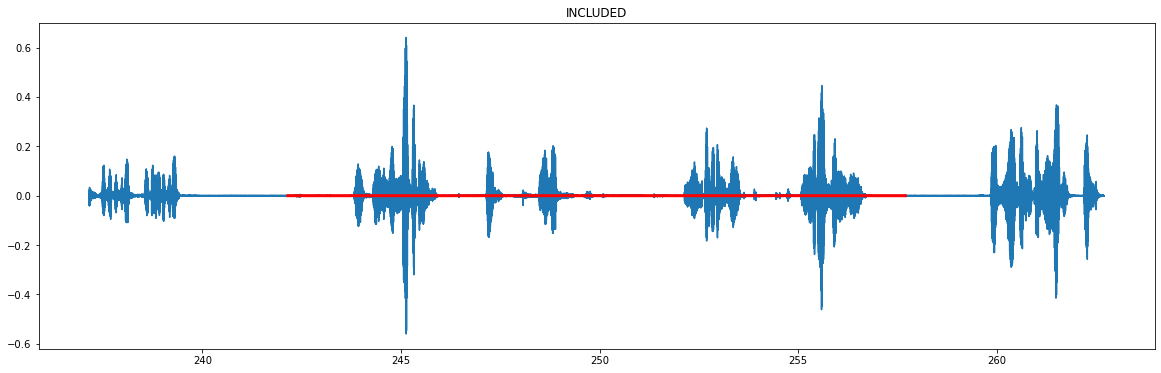

[NeMo I 2020-10-30 12:39:49 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 12:39:49 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |mhấy đâu ồng ấy về trước em à em ái ông Hùng i cũng ùn cá giờ kem hai mươi á đâu lúc em dậy đấy|


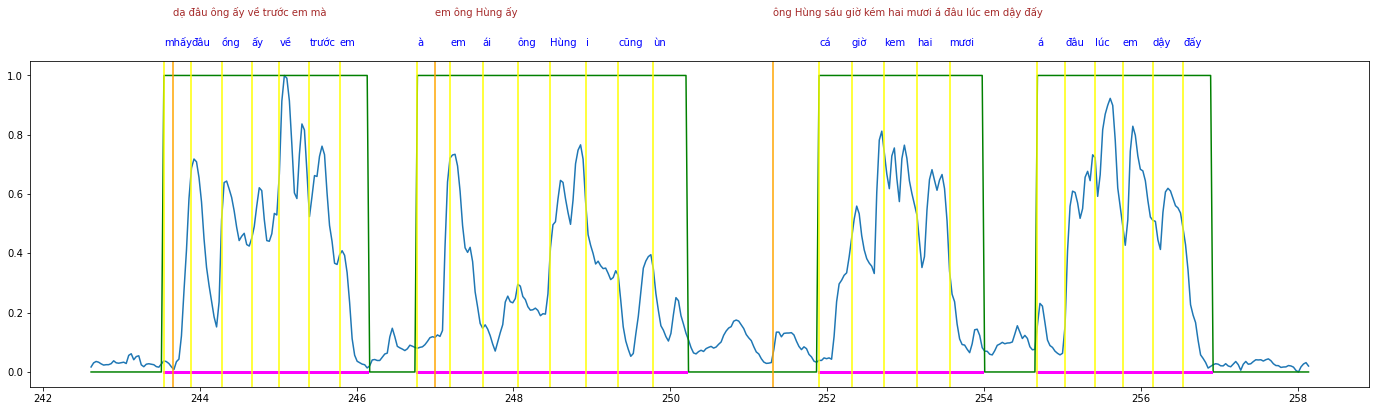

8054 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512, 7518, 7520, 7530, 7539, 7541, 7579, 7582, 8054]
READ_HEAD 8054
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 0: []
cutoff -78.44221105527639 #silences 0: []
cutoff -78.13065326633166 #silences 0: []
cutoff -77.81909547738694 #silences 1: [(6763, 6765)]
cutoff -77.50753768844221 #silences 8: [(2177, 2180), (6763, 6766), (6774, 6777), (7721, 7723), (8029, 8031), (8473, 8476), (9347, 9349), (9931, 9933)]
cutoff -77.19597989949749 #silences 24: [(895, 897), (1853, 1855), (1918, 1920), (2176, 2180), (3641, 36

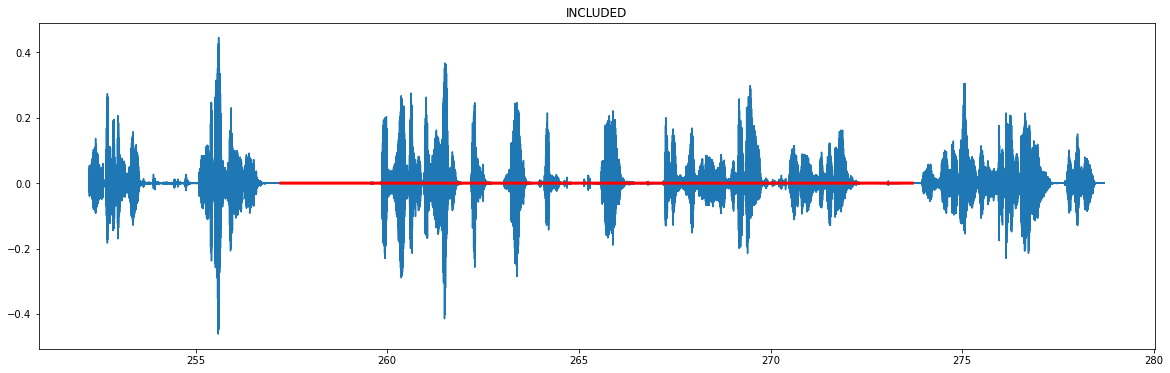

[NeMo I 2020-10-30 12:39:50 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 12:39:50 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |ắi mhỗi em vậy còn có em này anh này ông Hà này ông Cần này có thế thôi xong em anh mới bảo là đến bẩy giờ mồi chơ đế nhến bẩy giờ|
empty translation
8554 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512, 7518, 7520, 7530, 7539, 7541, 7579, 7582, 8054, 8554]
READ_HEAD 8554
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 0: []
cutoff -78.44221105527639 #silences 0: []
c

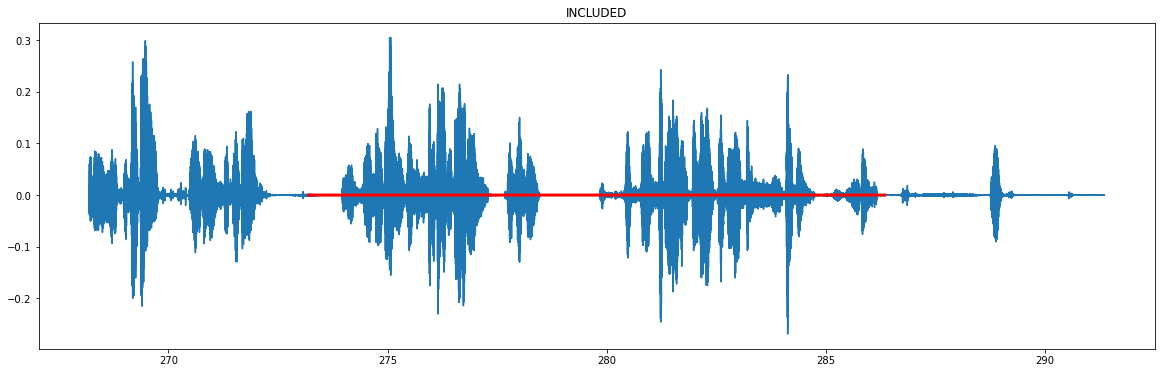

[NeMo I 2020-10-30 12:39:50 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 12:39:50 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |ừhì nồi bảy giờ ngủ đến bảy giờ xong bắt đầu là tấy nh em đì mìnhmmm cũng biết tý bảo thôi vậy kiểu gì ông ấ chẳng ng mủ thêm ấy ấy tấ đây|


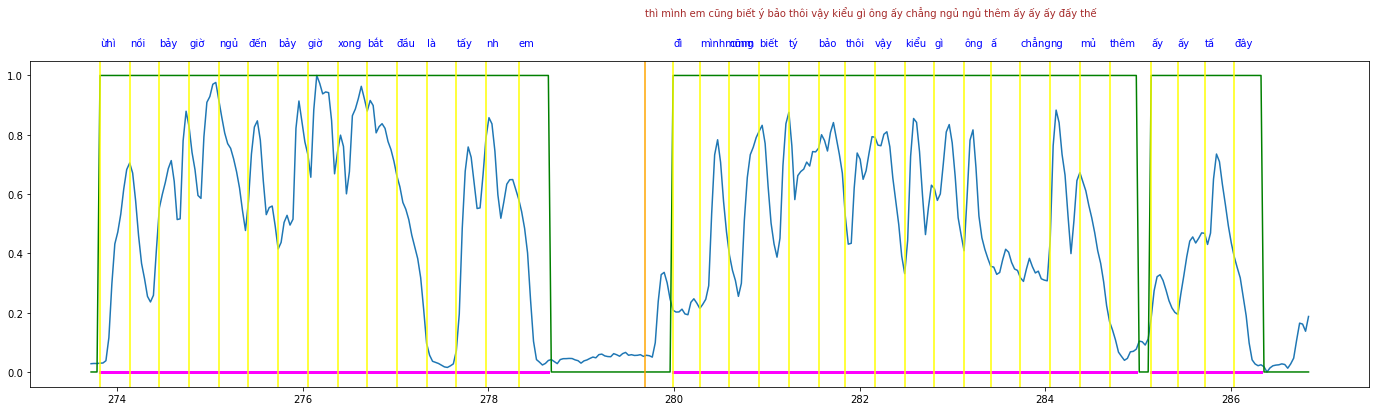

8949 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512, 7518, 7520, 7530, 7539, 7541, 7579, 7582, 8054, 8554, 8949]
READ_HEAD 8949
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 0: []
cutoff -78.44221105527639 #silences 0: []
cutoff -78.13065326633166 #silences 0: []
cutoff -77.81909547738694 #silences 1: [(5868, 5870)]
cutoff -77.50753768844221 #silences 8: [(1282, 1285), (5868, 5871), (5879, 5882), (6826, 6828), (7134, 7136), (7578, 7581), (8452, 8454), (9036, 9038)]
cutoff -77.19597989949749 #silences 24: [(0, 2), (958, 960), (1023, 1025), (1281, 1285), (27

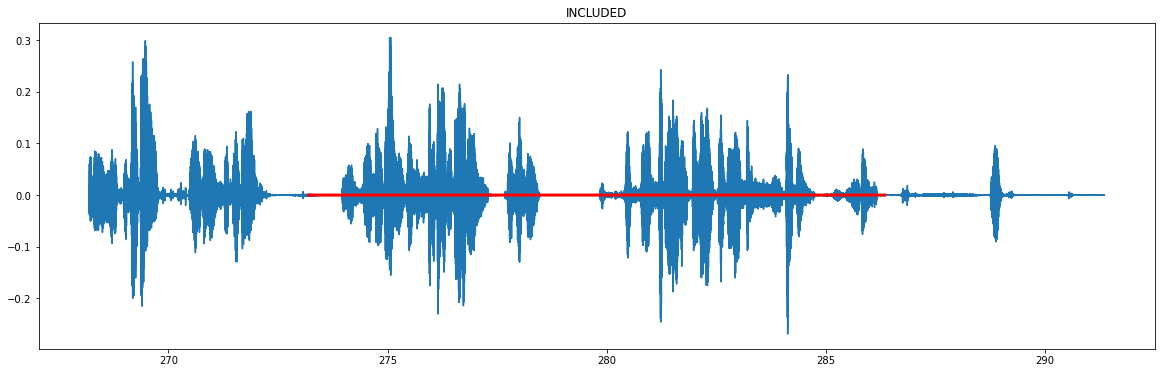

[NeMo I 2020-10-30 12:39:51 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 12:39:51 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |ừhì nồi bảy giờ ngủ đến bảy giờ xong bắt đầu là tấy nh em đì mìnhmmm cũng biết tý bảo thôi vậy kiểu gì ông ấ chẳng ng mủ thêm ấy ấy tấ đây|


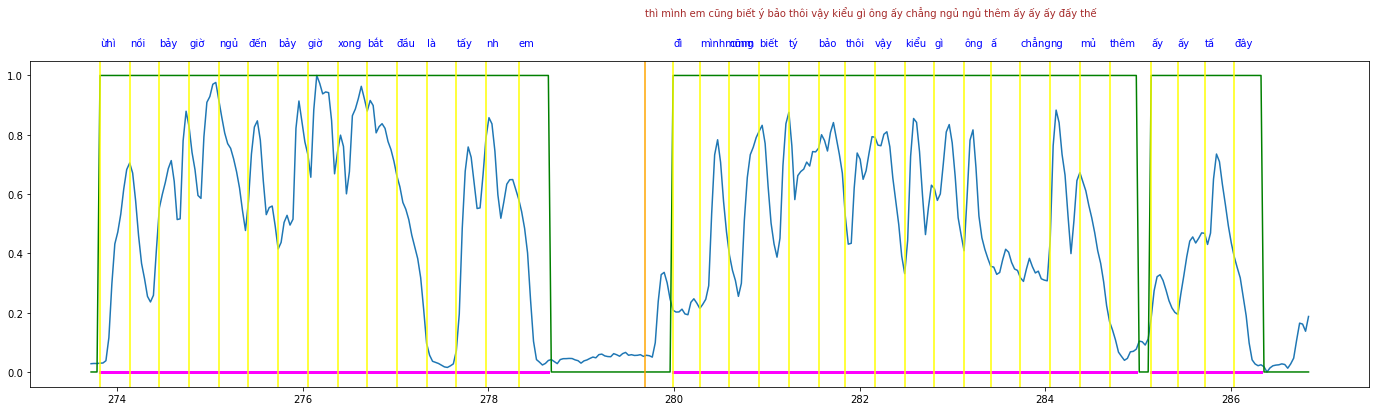

8951 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512, 7518, 7520, 7530, 7539, 7541, 7579, 7582, 8054, 8554, 8949, 8951]
READ_HEAD 8951
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 0: []
cutoff -78.44221105527639 #silences 0: []
cutoff -78.13065326633166 #silences 0: []
cutoff -77.81909547738694 #silences 1: [(5866, 5868)]
cutoff -77.50753768844221 #silences 8: [(1280, 1283), (5866, 5869), (5877, 5880), (6824, 6826), (7132, 7134), (7576, 7579), (8450, 8452), (9034, 9036)]
cutoff -77.19597989949749 #silences 23: [(956, 958), (1021, 1023), (1279, 1283), (2744

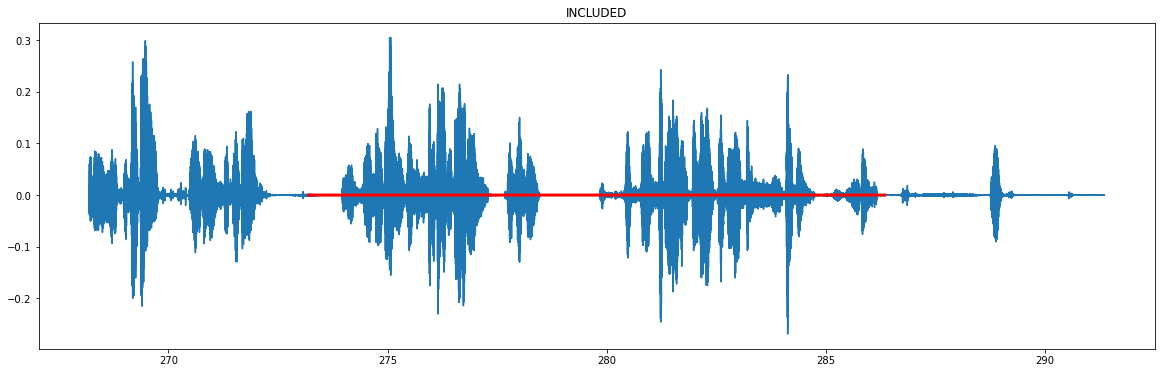

[NeMo I 2020-10-30 12:39:51 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 12:39:51 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |ừhì nồi bảy giờ gủ đến bảy giờ xong bắt đầu là tấy nh em đì mìnhmmm cũng biết tý bảo thôi vậy kiểu gì ông ấ chẳng ng mủ thêm ấy ấy tấ đây|


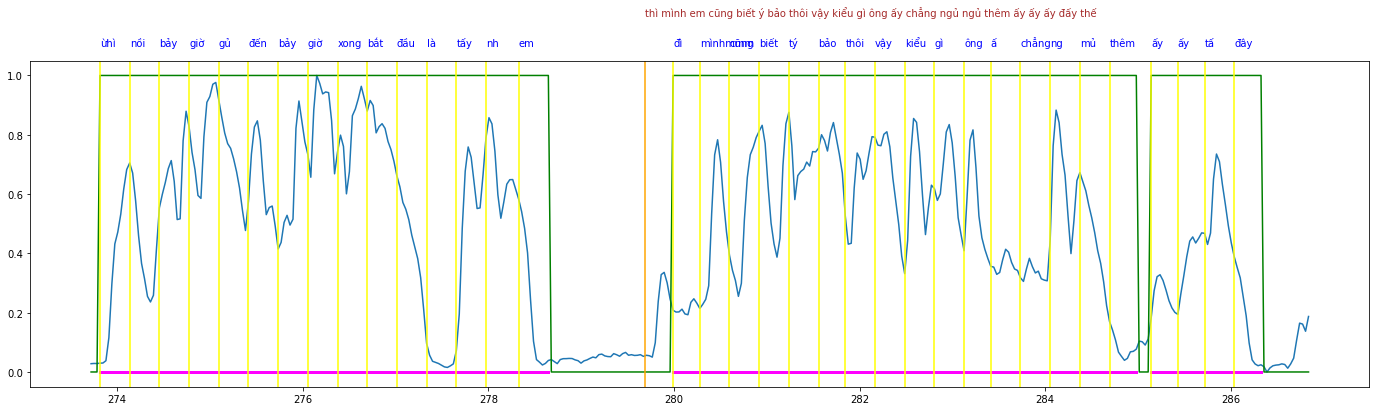

8958 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512, 7518, 7520, 7530, 7539, 7541, 7579, 7582, 8054, 8554, 8949, 8951, 8958]
READ_HEAD 8958
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 0: []
cutoff -78.44221105527639 #silences 0: []
cutoff -78.13065326633166 #silences 0: []
cutoff -77.81909547738694 #silences 1: [(5859, 5861)]
cutoff -77.50753768844221 #silences 8: [(1273, 1276), (5859, 5862), (5870, 5873), (6817, 6819), (7125, 7127), (7569, 7572), (8443, 8445), (9027, 9029)]
cutoff -77.19597989949749 #silences 23: [(949, 951), (1014, 1016), (1272, 1276),

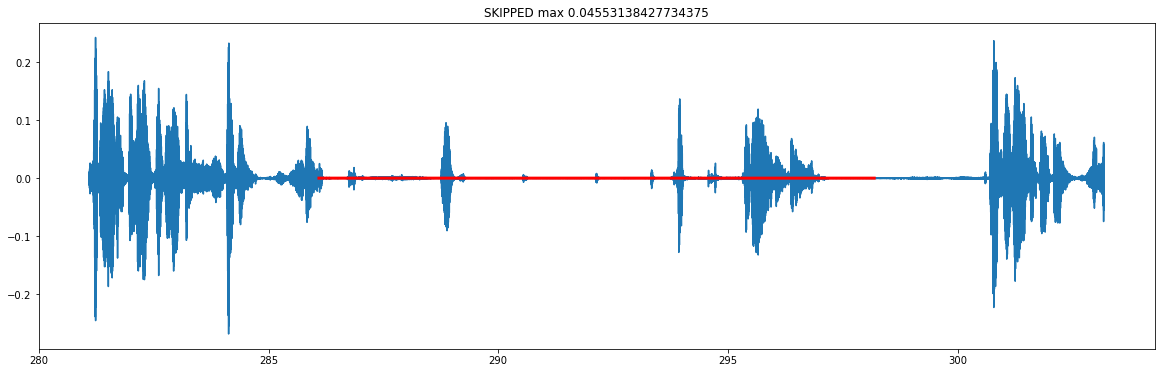

9319 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512, 7518, 7520, 7530, 7539, 7541, 7579, 7582, 8054, 8554, 8949, 8951, 8958, 9319]
READ_HEAD 9319
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 0: []
cutoff -78.44221105527639 #silences 0: []
cutoff -78.13065326633166 #silences 0: []
cutoff -77.81909547738694 #silences 1: [(5498, 5500)]
cutoff -77.50753768844221 #silences 8: [(912, 915), (5498, 5501), (5509, 5512), (6456, 6458), (6764, 6766), (7208, 7211), (8082, 8084), (8666, 8668)]
cutoff -77.19597989949749 #silences 23: [(588, 590), (653, 655), (911, 915),

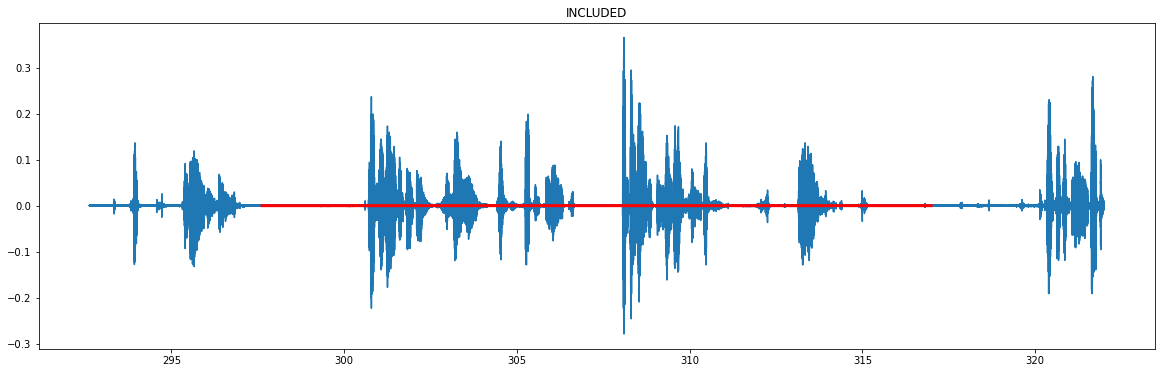

[NeMo I 2020-10-30 12:39:52 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 12:39:52 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |hôn m mấy ềm ề ăn cơm sớm năm giờ xong bắt đầu làm một khác đữn sáu giờ xong cần sáu giờ lúc cọi dậy còn đang muốn ngủ tiếp thấy|
empty translation
9907 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512, 7518, 7520, 7530, 7539, 7541, 7579, 7582, 8054, 8554, 8949, 8951, 8958, 9319, 9907]
READ_HEAD 9907
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 0: []
cutoff -78.4422

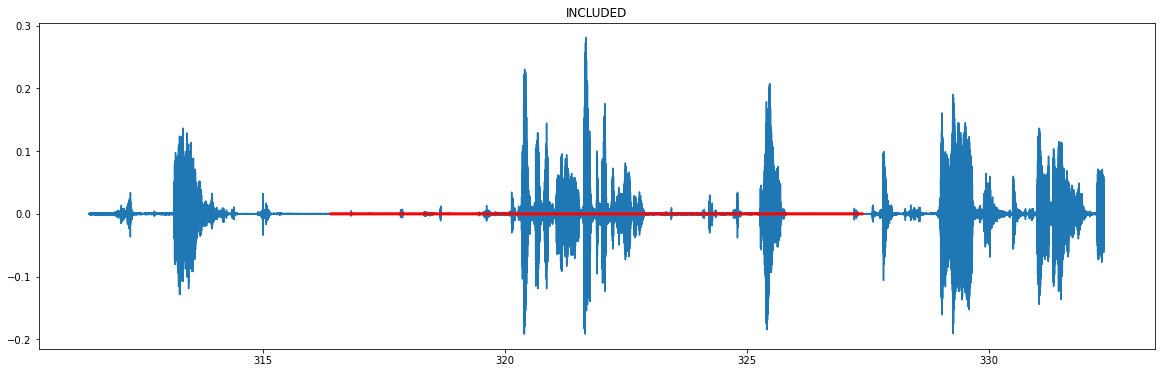

[NeMo I 2020-10-30 12:39:52 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 12:39:52 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |a hô trước bà Thuý bà ấy tái xuất giang hồ ở đây rồi đấy khi biáo ấy|


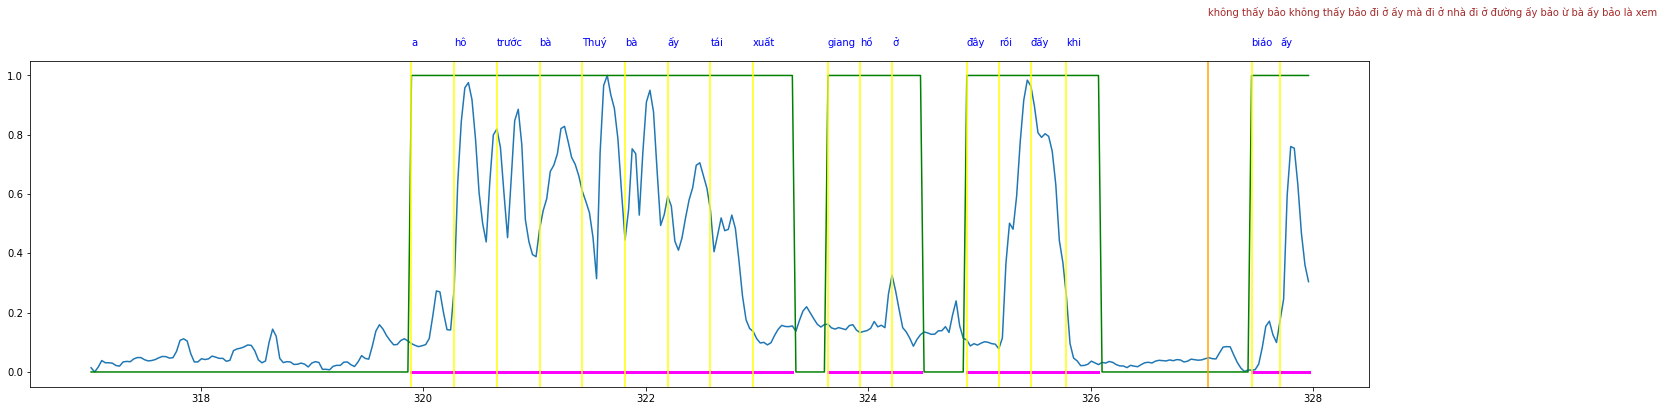

10231 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512, 7518, 7520, 7530, 7539, 7541, 7579, 7582, 8054, 8554, 8949, 8951, 8958, 9319, 9907, 10231]
READ_HEAD 10231
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 0: []
cutoff -78.44221105527639 #silences 0: []
cutoff -78.13065326633166 #silences 0: []
cutoff -77.81909547738694 #silences 1: [(4586, 4588)]
cutoff -77.50753768844221 #silences 8: [(0, 3), (4586, 4589), (4597, 4600), (5544, 5546), (5852, 5854), (6296, 6299), (7170, 7172), (7754, 7756)]
advance past silence 10234 3


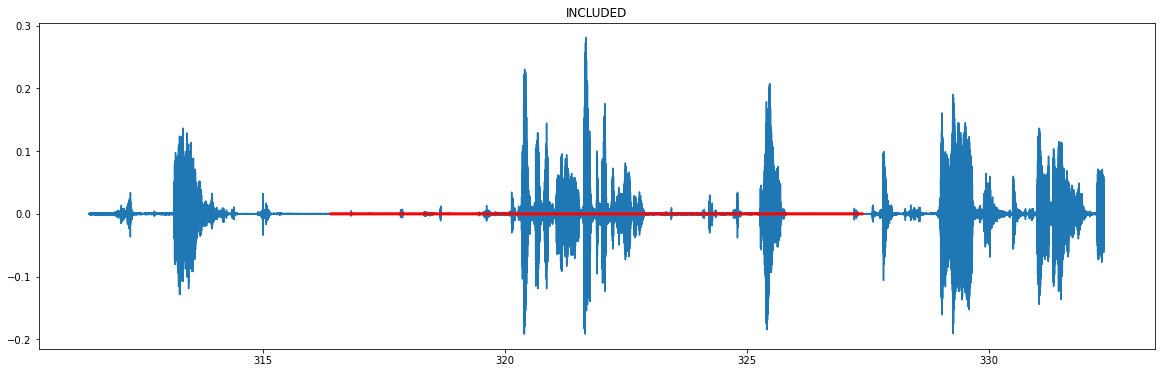

[NeMo I 2020-10-30 12:39:52 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 12:39:52 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |ô hô trước bà Thuý bà ấy tái xuất giang hồ ở đây rồi đấy khi biáo ấy|


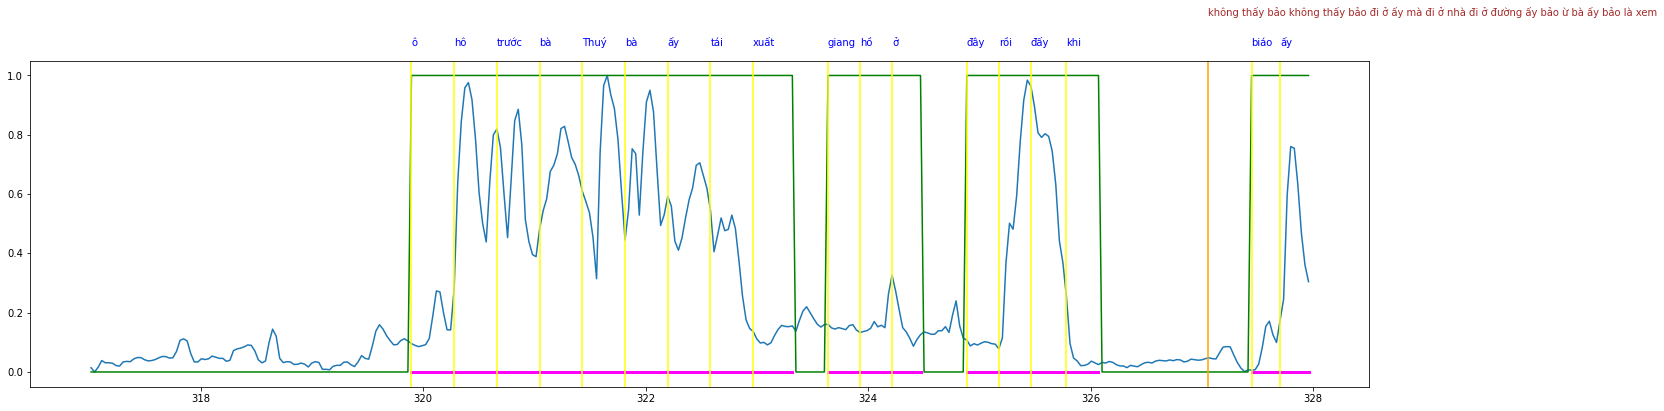

10234 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512, 7518, 7520, 7530, 7539, 7541, 7579, 7582, 8054, 8554, 8949, 8951, 8958, 9319, 9907, 10231, 10234]
READ_HEAD 10234
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 0: []
cutoff -78.44221105527639 #silences 0: []
cutoff -78.13065326633166 #silences 0: []
cutoff -77.81909547738694 #silences 1: [(4583, 4585)]
cutoff -77.50753768844221 #silences 7: [(4583, 4586), (4594, 4597), (5541, 5543), (5849, 5851), (6293, 6296), (7167, 7169), (7751, 7753)]
cutoff -77.19597989949749 #silences 20: [(1461, 1463), (3014, 3020

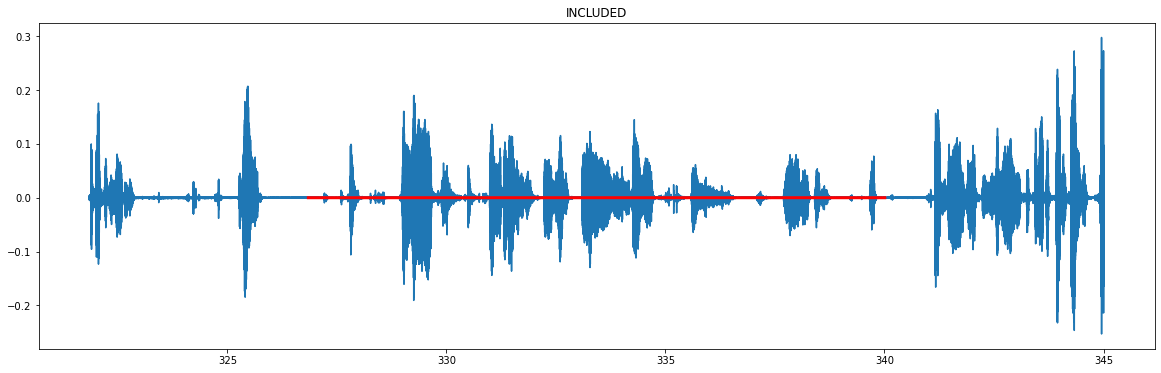

[NeMo I 2020-10-30 12:39:53 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 12:39:53 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |không thấy đóo không thấy bảo đi ở ấy mà đi ở nhà đi ở đường ấy bảo mà ấi bả là xem|


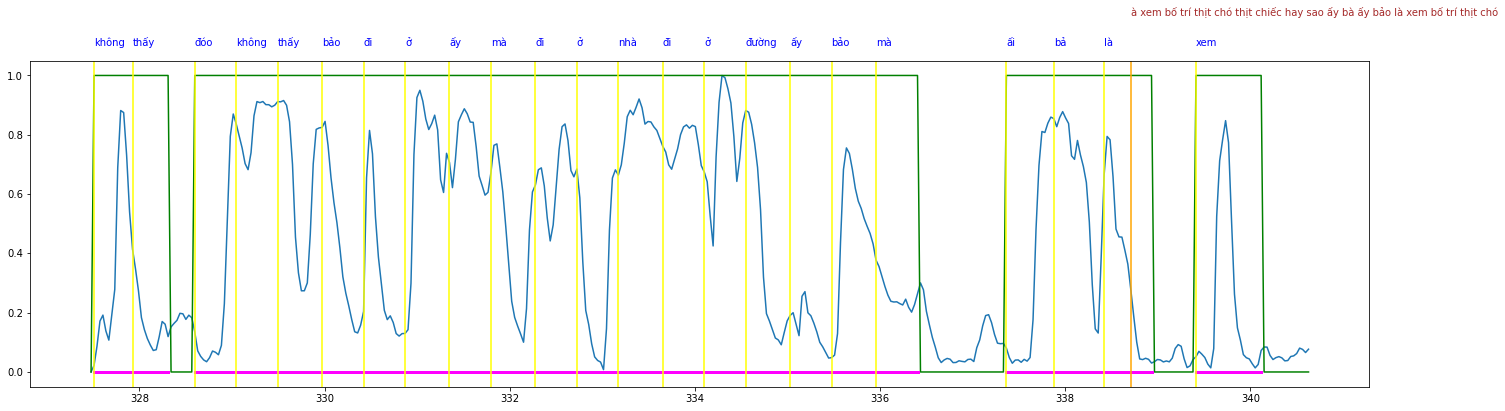

10626 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512, 7518, 7520, 7530, 7539, 7541, 7579, 7582, 8054, 8554, 8949, 8951, 8958, 9319, 9907, 10231, 10234, 10626]
READ_HEAD 10626
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 0: []
cutoff -78.44221105527639 #silences 0: []
cutoff -78.13065326633166 #silences 0: []
cutoff -77.81909547738694 #silences 1: [(4191, 4193)]
cutoff -77.50753768844221 #silences 7: [(4191, 4194), (4202, 4205), (5149, 5151), (5457, 5459), (5901, 5904), (6775, 6777), (7359, 7361)]
cutoff -77.19597989949749 #silences 20: [(1069, 1071), (262

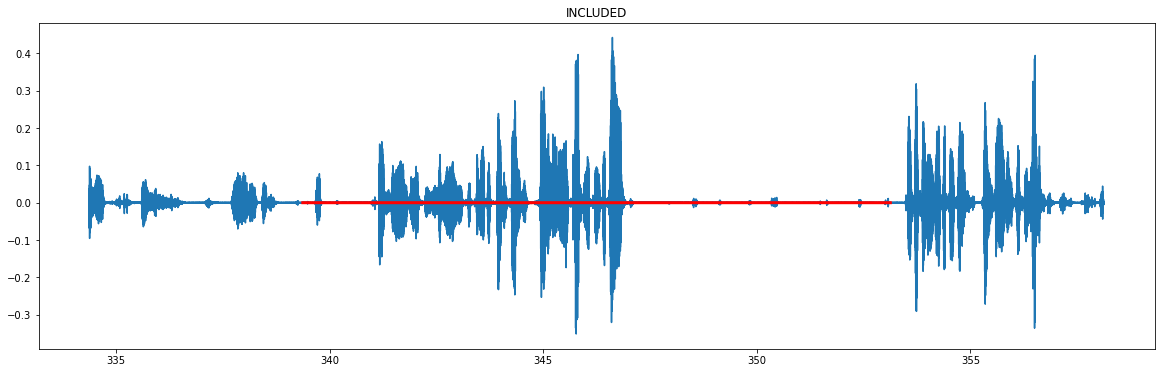

[NeMo I 2020-10-30 12:39:53 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 12:39:53 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |nhải xem bố trí thịt chó thịt chiếc hay sao ấy bà ấy bảo là xem bố thí thịt chó|


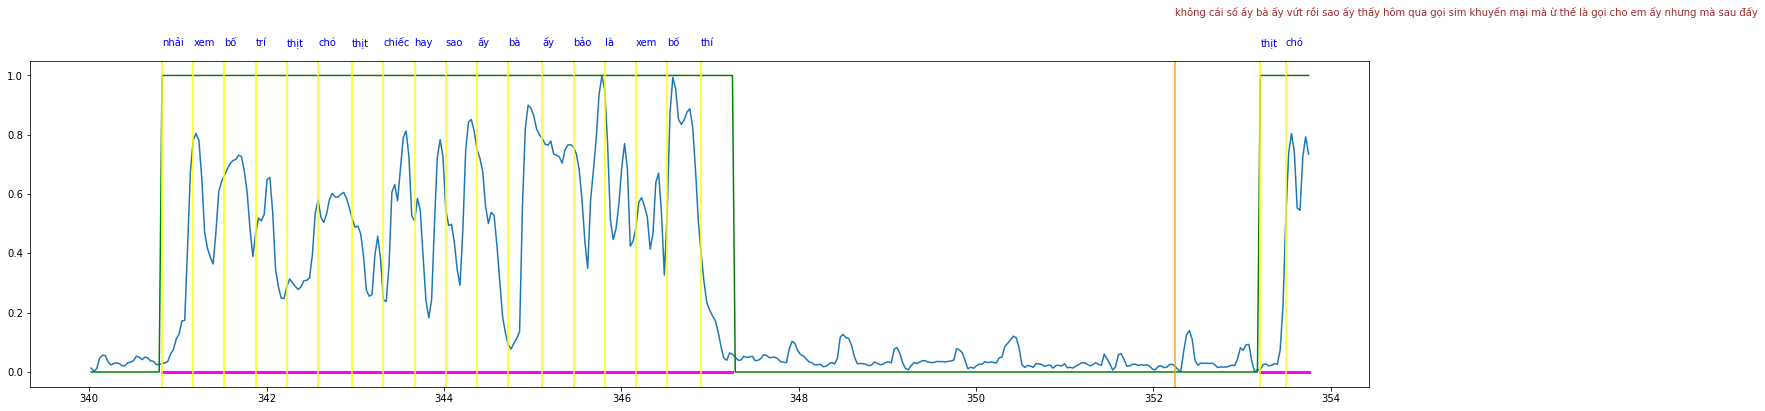

11036 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512, 7518, 7520, 7530, 7539, 7541, 7579, 7582, 8054, 8554, 8949, 8951, 8958, 9319, 9907, 10231, 10234, 10626, 11036]
READ_HEAD 11036
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 0: []
cutoff -78.44221105527639 #silences 0: []
cutoff -78.13065326633166 #silences 0: []
cutoff -77.81909547738694 #silences 1: [(3781, 3783)]
cutoff -77.50753768844221 #silences 7: [(3781, 3784), (3792, 3795), (4739, 4741), (5047, 5049), (5491, 5494), (6365, 6367), (6949, 6951)]
cutoff -77.19597989949749 #silences 20: [(659, 661),

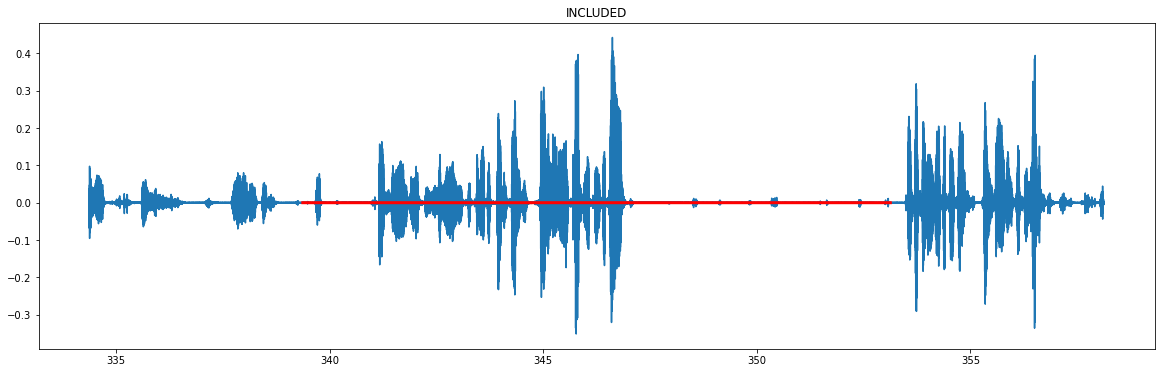

[NeMo I 2020-10-30 12:39:54 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 12:39:54 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |nhải xem bố trí thịt chó thịt chiếc hay sao ấy bà ấy bảo là em bố thí thịt chó|


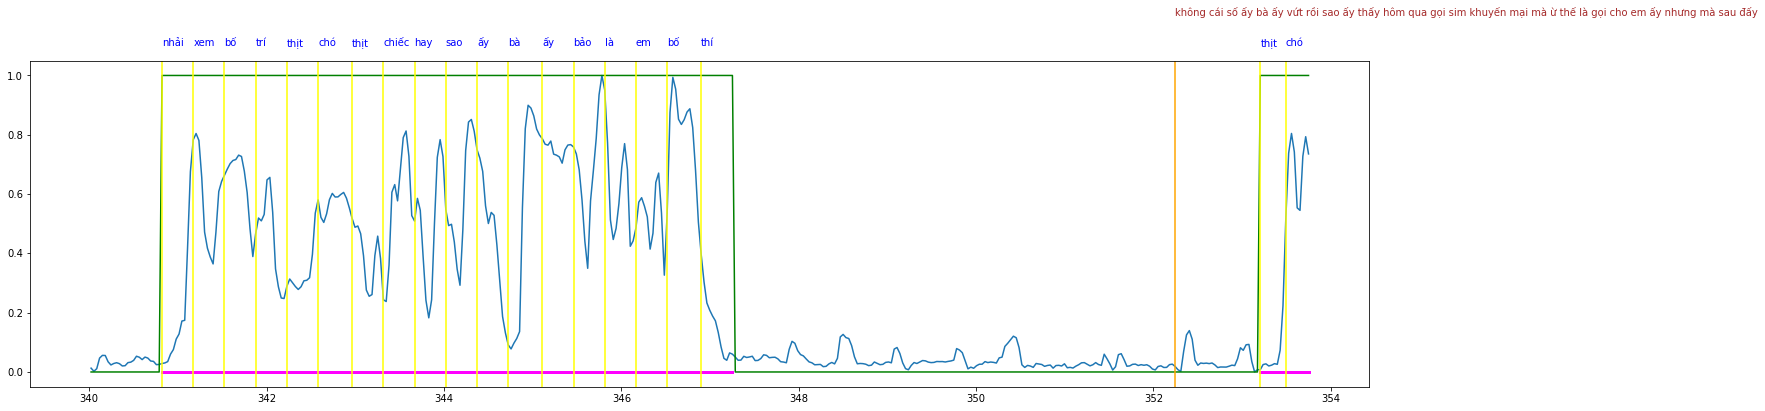

11038 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512, 7518, 7520, 7530, 7539, 7541, 7579, 7582, 8054, 8554, 8949, 8951, 8958, 9319, 9907, 10231, 10234, 10626, 11036, 11038]
READ_HEAD 11038
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 0: []
cutoff -78.44221105527639 #silences 0: []
cutoff -78.13065326633166 #silences 0: []
cutoff -77.81909547738694 #silences 1: [(3779, 3781)]
cutoff -77.50753768844221 #silences 7: [(3779, 3782), (3790, 3793), (4737, 4739), (5045, 5047), (5489, 5492), (6363, 6365), (6947, 6949)]
cutoff -77.19597989949749 #silences 20: [(657

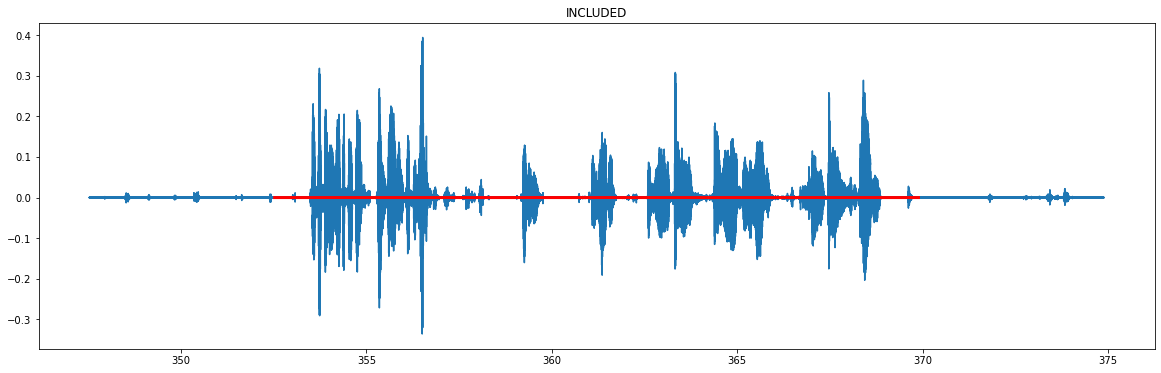

[NeMo I 2020-10-30 12:39:54 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 12:39:54 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |không cái số ấy bà ấy vứt rồi sao ấy thấy hôm qua gọi sim khuyến mại mà ừ thế là gọi cho em ấy nhưng mà sau đấy so đấi em bảo nà ấy thôi bảo là cháu nó hôm qua đi|


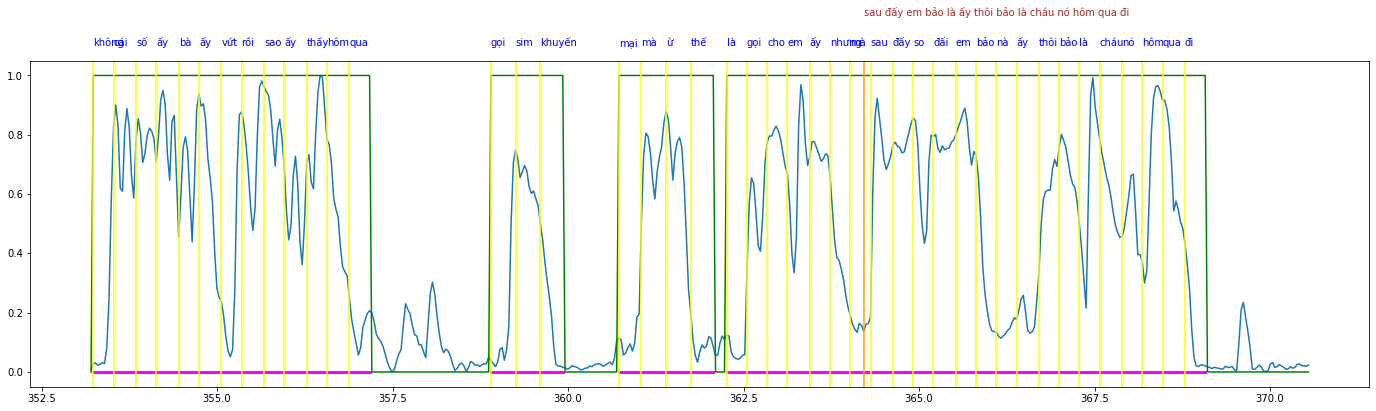

11560 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512, 7518, 7520, 7530, 7539, 7541, 7579, 7582, 8054, 8554, 8949, 8951, 8958, 9319, 9907, 10231, 10234, 10626, 11036, 11038, 11560]
READ_HEAD 11560
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 0: []
cutoff -78.44221105527639 #silences 0: []
cutoff -78.13065326633166 #silences 0: []
cutoff -77.81909547738694 #silences 1: [(3257, 3259)]
cutoff -77.50753768844221 #silences 7: [(3257, 3260), (3268, 3271), (4215, 4217), (4523, 4525), (4967, 4970), (5841, 5843), (6425, 6427)]
cutoff -77.19597989949749 #silences 20

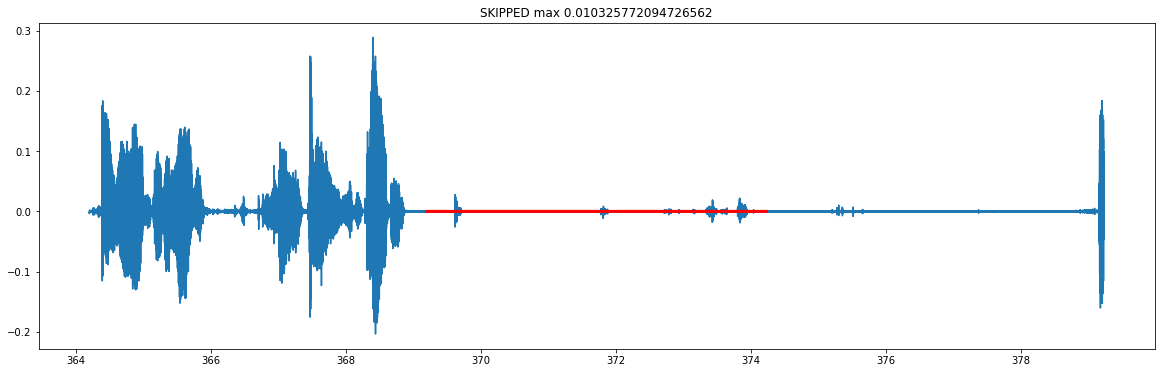

11695 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512, 7518, 7520, 7530, 7539, 7541, 7579, 7582, 8054, 8554, 8949, 8951, 8958, 9319, 9907, 10231, 10234, 10626, 11036, 11038, 11560, 11695]
READ_HEAD 11695
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 0: []
cutoff -78.44221105527639 #silences 0: []
cutoff -78.13065326633166 #silences 0: []
cutoff -77.81909547738694 #silences 1: [(3122, 3124)]
cutoff -77.50753768844221 #silences 7: [(3122, 3125), (3133, 3136), (4080, 4082), (4388, 4390), (4832, 4835), (5706, 5708), (6290, 6292)]
cutoff -77.19597989949749 #sile

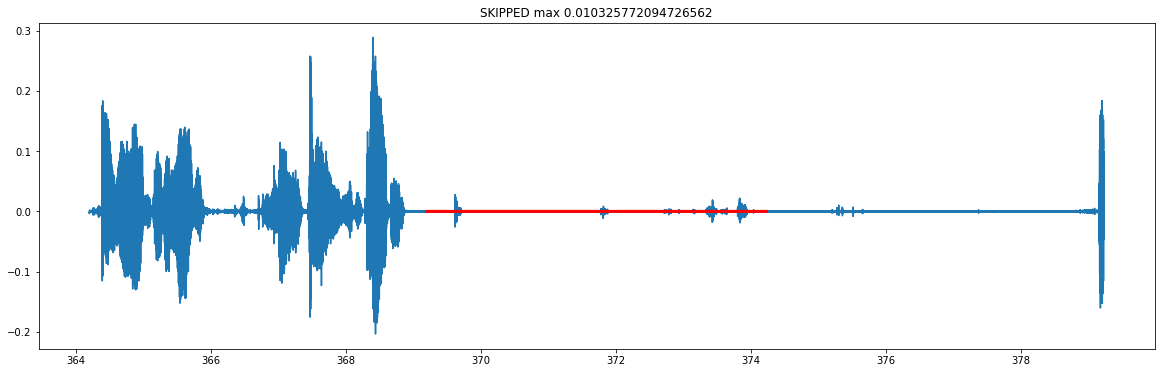

11697 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512, 7518, 7520, 7530, 7539, 7541, 7579, 7582, 8054, 8554, 8949, 8951, 8958, 9319, 9907, 10231, 10234, 10626, 11036, 11038, 11560, 11695, 11697]
READ_HEAD 11697
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 0: []
cutoff -78.44221105527639 #silences 0: []
cutoff -78.13065326633166 #silences 0: []
cutoff -77.81909547738694 #silences 1: [(3120, 3122)]
cutoff -77.50753768844221 #silences 7: [(3120, 3123), (3131, 3134), (4078, 4080), (4386, 4388), (4830, 4833), (5704, 5706), (6288, 6290)]
cutoff -77.1959798994974

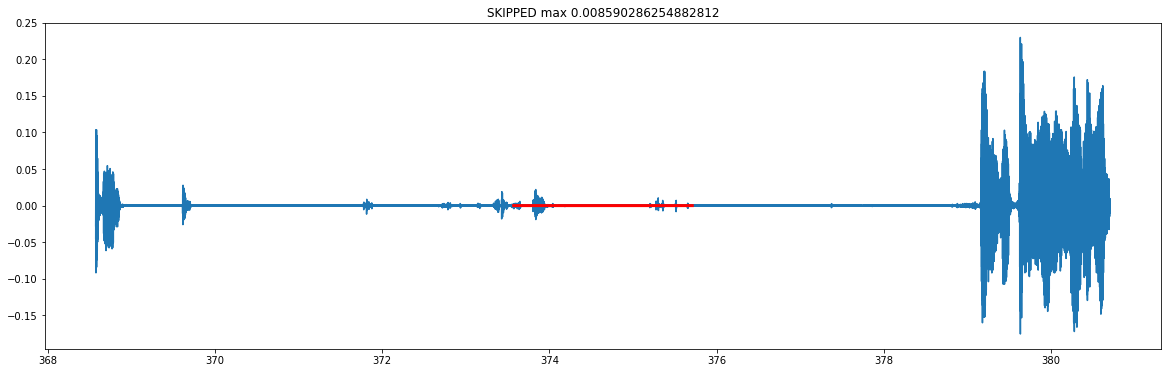

11741 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512, 7518, 7520, 7530, 7539, 7541, 7579, 7582, 8054, 8554, 8949, 8951, 8958, 9319, 9907, 10231, 10234, 10626, 11036, 11038, 11560, 11695, 11697, 11741]
READ_HEAD 11741
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 0: []
cutoff -78.44221105527639 #silences 0: []
cutoff -78.13065326633166 #silences 0: []
cutoff -77.81909547738694 #silences 1: [(3076, 3078)]
cutoff -77.50753768844221 #silences 7: [(3076, 3079), (3087, 3090), (4034, 4036), (4342, 4344), (4786, 4789), (5660, 5662), (6244, 6246)]
cutoff -77.195979

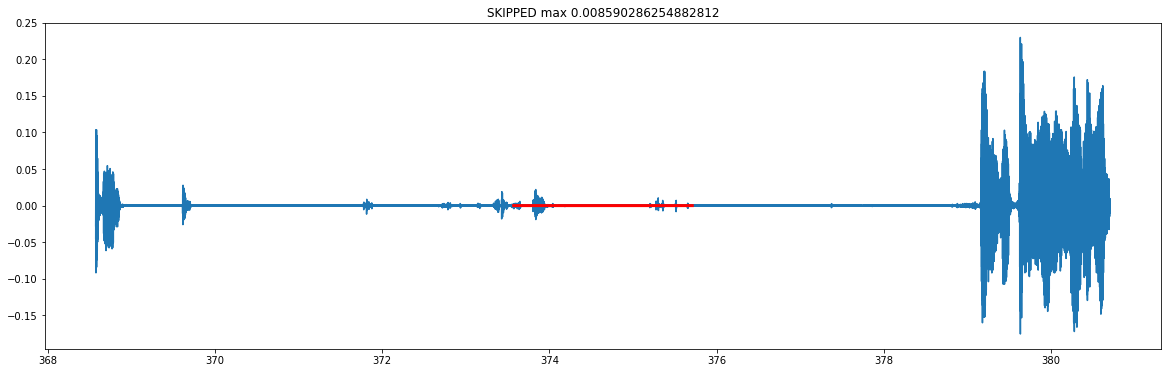

11743 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512, 7518, 7520, 7530, 7539, 7541, 7579, 7582, 8054, 8554, 8949, 8951, 8958, 9319, 9907, 10231, 10234, 10626, 11036, 11038, 11560, 11695, 11697, 11741, 11743]
READ_HEAD 11743
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 0: []
cutoff -78.44221105527639 #silences 0: []
cutoff -78.13065326633166 #silences 0: []
cutoff -77.81909547738694 #silences 1: [(3074, 3076)]
cutoff -77.50753768844221 #silences 7: [(3074, 3077), (3085, 3088), (4032, 4034), (4340, 4342), (4784, 4787), (5658, 5660), (6242, 6244)]
cutoff -77

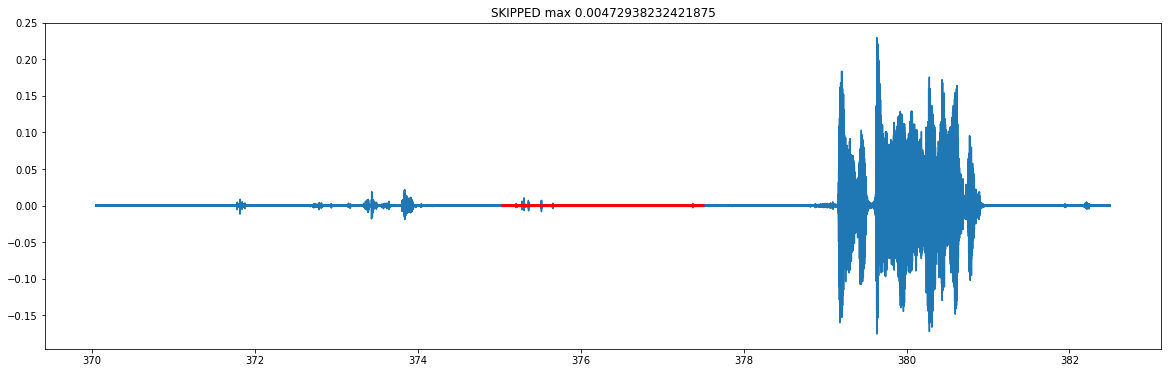

11797 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512, 7518, 7520, 7530, 7539, 7541, 7579, 7582, 8054, 8554, 8949, 8951, 8958, 9319, 9907, 10231, 10234, 10626, 11036, 11038, 11560, 11695, 11697, 11741, 11743, 11797]
READ_HEAD 11797
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 0: []
cutoff -78.44221105527639 #silences 0: []
cutoff -78.13065326633166 #silences 0: []
cutoff -77.81909547738694 #silences 1: [(3020, 3022)]
cutoff -77.50753768844221 #silences 7: [(3020, 3023), (3031, 3034), (3978, 3980), (4286, 4288), (4730, 4733), (5604, 5606), (6188, 6190)]
cut

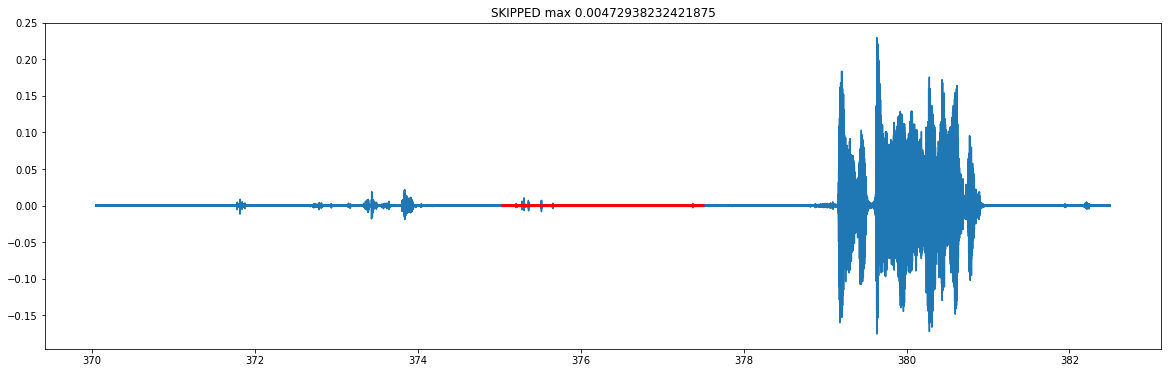

11802 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512, 7518, 7520, 7530, 7539, 7541, 7579, 7582, 8054, 8554, 8949, 8951, 8958, 9319, 9907, 10231, 10234, 10626, 11036, 11038, 11560, 11695, 11697, 11741, 11743, 11797, 11802]
READ_HEAD 11802
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 0: []
cutoff -78.44221105527639 #silences 0: []
cutoff -78.13065326633166 #silences 0: []
cutoff -77.81909547738694 #silences 1: [(3015, 3017)]
cutoff -77.50753768844221 #silences 7: [(3015, 3018), (3026, 3029), (3973, 3975), (4281, 4283), (4725, 4728), (5599, 5601), (6183, 618

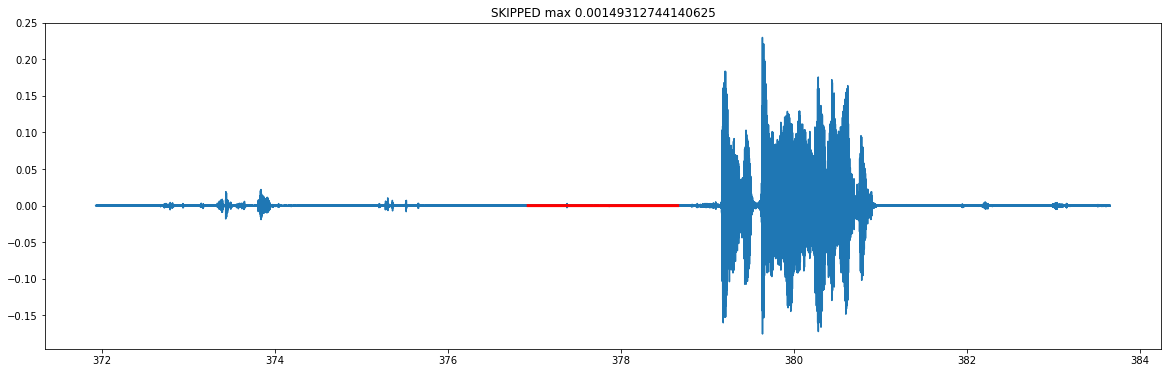

11833 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512, 7518, 7520, 7530, 7539, 7541, 7579, 7582, 8054, 8554, 8949, 8951, 8958, 9319, 9907, 10231, 10234, 10626, 11036, 11038, 11560, 11695, 11697, 11741, 11743, 11797, 11802, 11833]
READ_HEAD 11833
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 0: []
cutoff -78.44221105527639 #silences 0: []
cutoff -78.13065326633166 #silences 0: []
cutoff -77.81909547738694 #silences 1: [(2984, 2986)]
cutoff -77.50753768844221 #silences 7: [(2984, 2987), (2995, 2998), (3942, 3944), (4250, 4252), (4694, 4697), (5568, 5570), (61

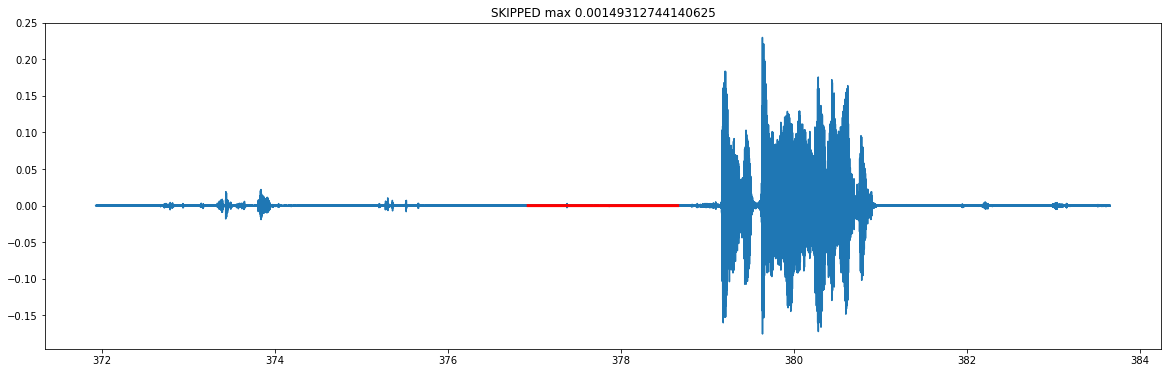

11835 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512, 7518, 7520, 7530, 7539, 7541, 7579, 7582, 8054, 8554, 8949, 8951, 8958, 9319, 9907, 10231, 10234, 10626, 11036, 11038, 11560, 11695, 11697, 11741, 11743, 11797, 11802, 11833, 11835]
READ_HEAD 11835
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 0: []
cutoff -78.44221105527639 #silences 0: []
cutoff -78.13065326633166 #silences 0: []
cutoff -77.81909547738694 #silences 1: [(2982, 2984)]
cutoff -77.50753768844221 #silences 7: [(2982, 2985), (2993, 2996), (3940, 3942), (4248, 4250), (4692, 4695), (5566, 556

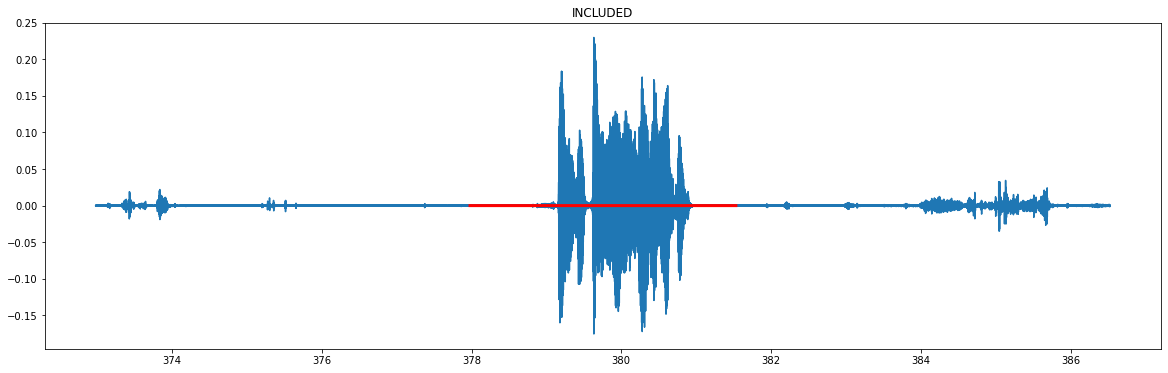

[NeMo I 2020-10-30 12:39:56 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 12:39:56 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |chếi bảo là cháu hấy rồi đấy|


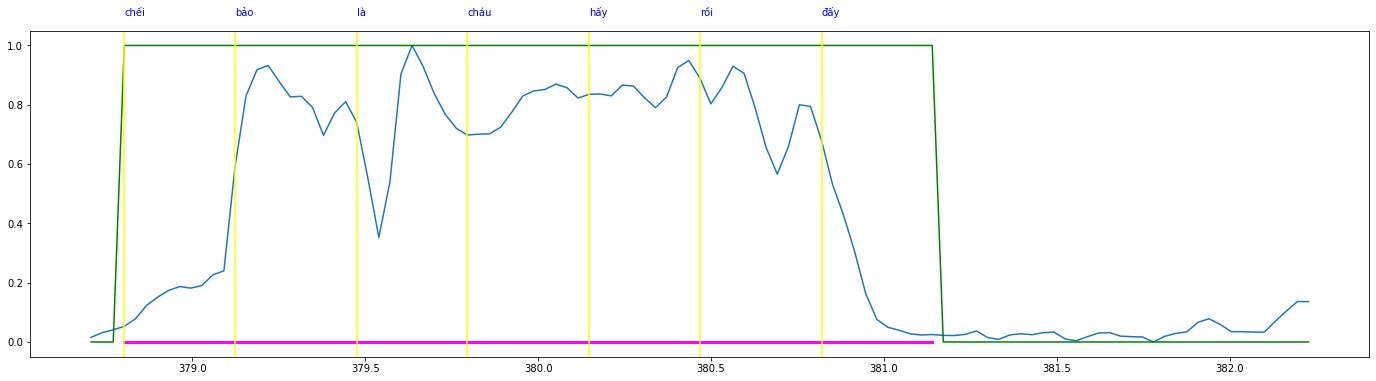

11923 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512, 7518, 7520, 7530, 7539, 7541, 7579, 7582, 8054, 8554, 8949, 8951, 8958, 9319, 9907, 10231, 10234, 10626, 11036, 11038, 11560, 11695, 11697, 11741, 11743, 11797, 11802, 11833, 11835, 11923]
READ_HEAD 11923
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 0: []
cutoff -78.44221105527639 #silences 0: []
cutoff -78.13065326633166 #silences 0: []
cutoff -77.81909547738694 #silences 1: [(2894, 2896)]
cutoff -77.50753768844221 #silences 7: [(2894, 2897), (2905, 2908), (3852, 3854), (4160, 4162), (4604, 4607), (54

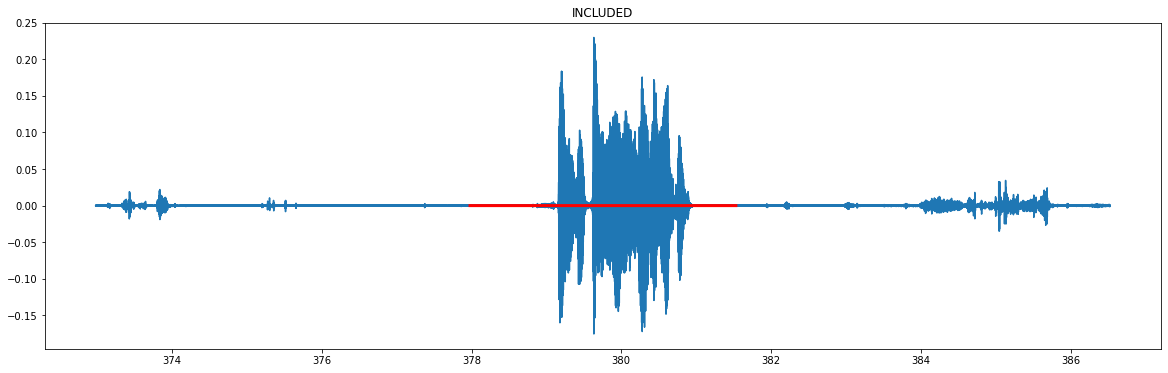

[NeMo I 2020-10-30 12:39:56 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 12:39:56 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |chếi bảo là cháu đấy rồi đấy|


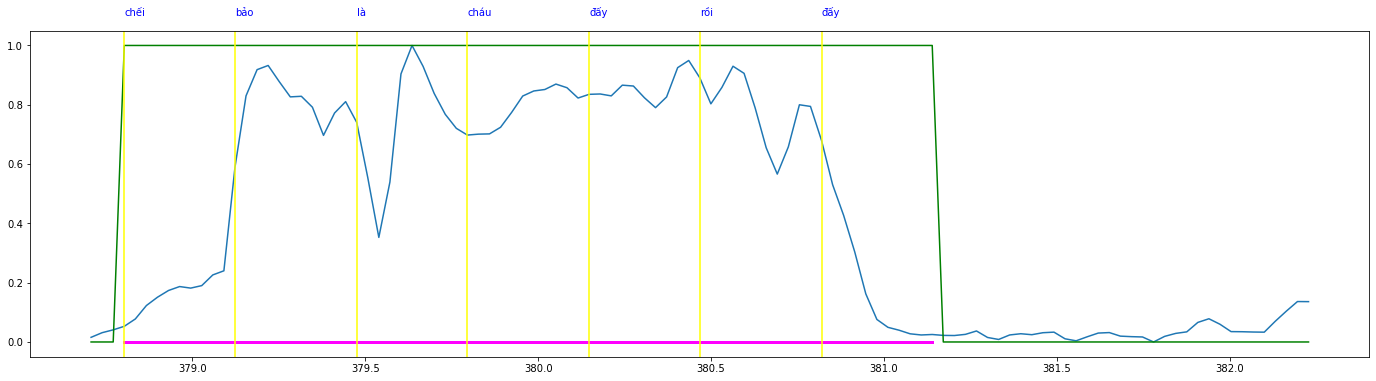

11925 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512, 7518, 7520, 7530, 7539, 7541, 7579, 7582, 8054, 8554, 8949, 8951, 8958, 9319, 9907, 10231, 10234, 10626, 11036, 11038, 11560, 11695, 11697, 11741, 11743, 11797, 11802, 11833, 11835, 11923, 11925]
READ_HEAD 11925
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 0: []
cutoff -78.44221105527639 #silences 0: []
cutoff -78.13065326633166 #silences 0: []
cutoff -77.81909547738694 #silences 1: [(2892, 2894)]
cutoff -77.50753768844221 #silences 7: [(2892, 2895), (2903, 2906), (3850, 3852), (4158, 4160), (4602, 460

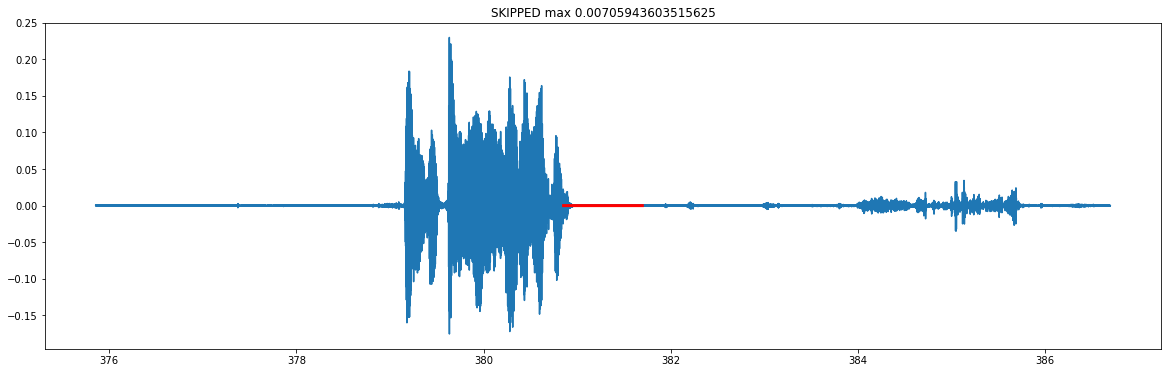

11928 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512, 7518, 7520, 7530, 7539, 7541, 7579, 7582, 8054, 8554, 8949, 8951, 8958, 9319, 9907, 10231, 10234, 10626, 11036, 11038, 11560, 11695, 11697, 11741, 11743, 11797, 11802, 11833, 11835, 11923, 11925, 11928]
READ_HEAD 11928
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 0: []
cutoff -78.44221105527639 #silences 0: []
cutoff -78.13065326633166 #silences 0: []
cutoff -77.81909547738694 #silences 1: [(2889, 2891)]
cutoff -77.50753768844221 #silences 7: [(2889, 2892), (2900, 2903), (3847, 3849), (4155, 4157), (45

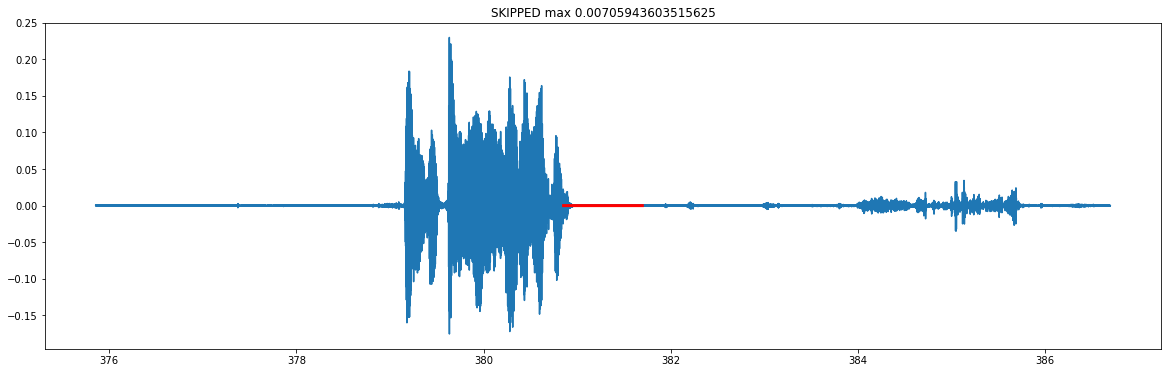

11932 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512, 7518, 7520, 7530, 7539, 7541, 7579, 7582, 8054, 8554, 8949, 8951, 8958, 9319, 9907, 10231, 10234, 10626, 11036, 11038, 11560, 11695, 11697, 11741, 11743, 11797, 11802, 11833, 11835, 11923, 11925, 11928, 11932]
READ_HEAD 11932
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 0: []
cutoff -78.44221105527639 #silences 0: []
cutoff -78.13065326633166 #silences 0: []
cutoff -77.81909547738694 #silences 1: [(2885, 2887)]
cutoff -77.50753768844221 #silences 7: [(2885, 2888), (2896, 2899), (3843, 3845), (4151, 415

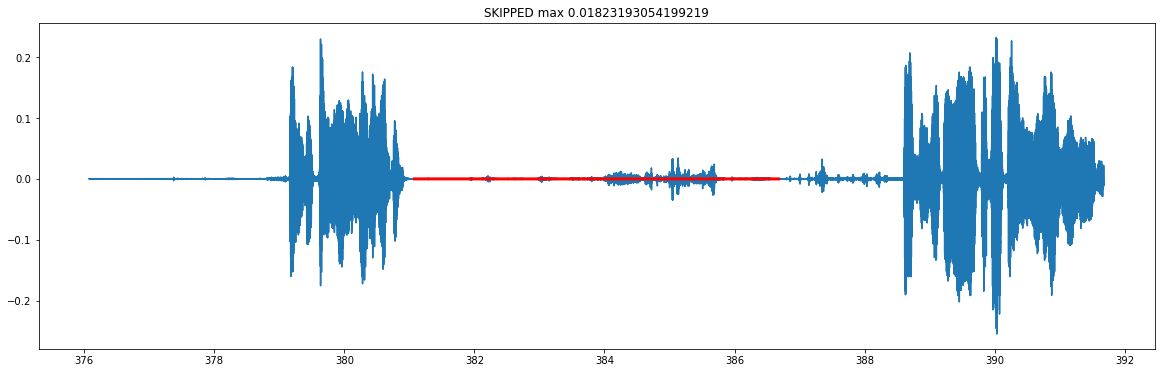

12084 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512, 7518, 7520, 7530, 7539, 7541, 7579, 7582, 8054, 8554, 8949, 8951, 8958, 9319, 9907, 10231, 10234, 10626, 11036, 11038, 11560, 11695, 11697, 11741, 11743, 11797, 11802, 11833, 11835, 11923, 11925, 11928, 11932, 12084]
READ_HEAD 12084
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 0: []
cutoff -78.44221105527639 #silences 0: []
cutoff -78.13065326633166 #silences 0: []
cutoff -77.81909547738694 #silences 1: [(2733, 2735)]
cutoff -77.50753768844221 #silences 7: [(2733, 2736), (2744, 2747), (3691, 3693), (39

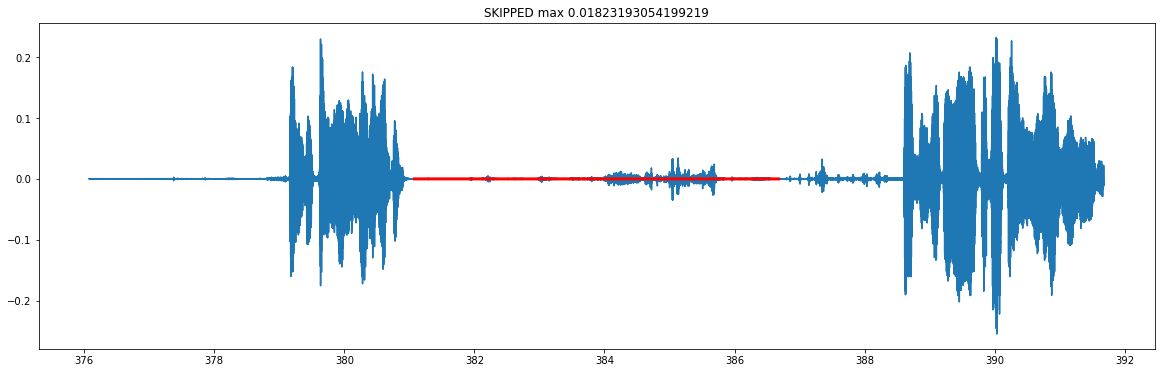

12087 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512, 7518, 7520, 7530, 7539, 7541, 7579, 7582, 8054, 8554, 8949, 8951, 8958, 9319, 9907, 10231, 10234, 10626, 11036, 11038, 11560, 11695, 11697, 11741, 11743, 11797, 11802, 11833, 11835, 11923, 11925, 11928, 11932, 12084, 12087]
READ_HEAD 12087
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 0: []
cutoff -78.44221105527639 #silences 0: []
cutoff -78.13065326633166 #silences 0: []
cutoff -77.81909547738694 #silences 1: [(2730, 2732)]
cutoff -77.50753768844221 #silences 7: [(2730, 2733), (2741, 2744), (3688, 369

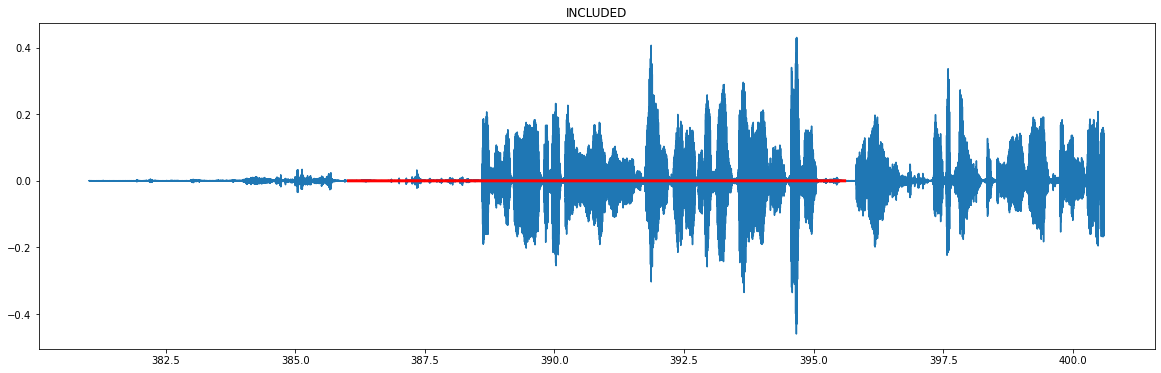

[NeMo I 2020-10-30 12:39:57 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 12:39:57 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |che bảo là cái đợt này cháu ấy đấy hôm qua hôm kia ấy đi đám ma ông xá ốm xang ấy|


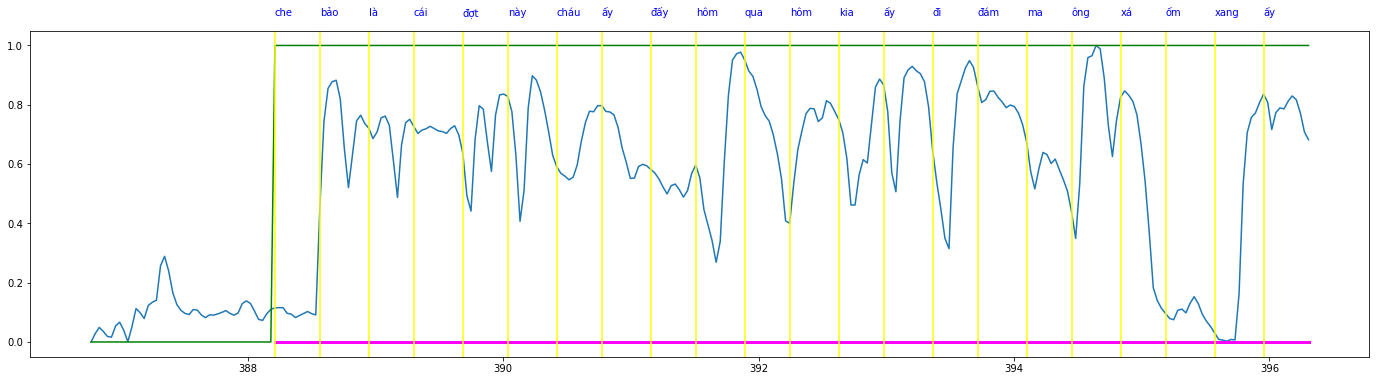

12363 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512, 7518, 7520, 7530, 7539, 7541, 7579, 7582, 8054, 8554, 8949, 8951, 8958, 9319, 9907, 10231, 10234, 10626, 11036, 11038, 11560, 11695, 11697, 11741, 11743, 11797, 11802, 11833, 11835, 11923, 11925, 11928, 11932, 12084, 12087, 12363]
READ_HEAD 12363
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 0: []
cutoff -78.44221105527639 #silences 0: []
cutoff -78.13065326633166 #silences 0: []
cutoff -77.81909547738694 #silences 1: [(2454, 2456)]
cutoff -77.50753768844221 #silences 7: [(2454, 2457), (2465, 2468), (34

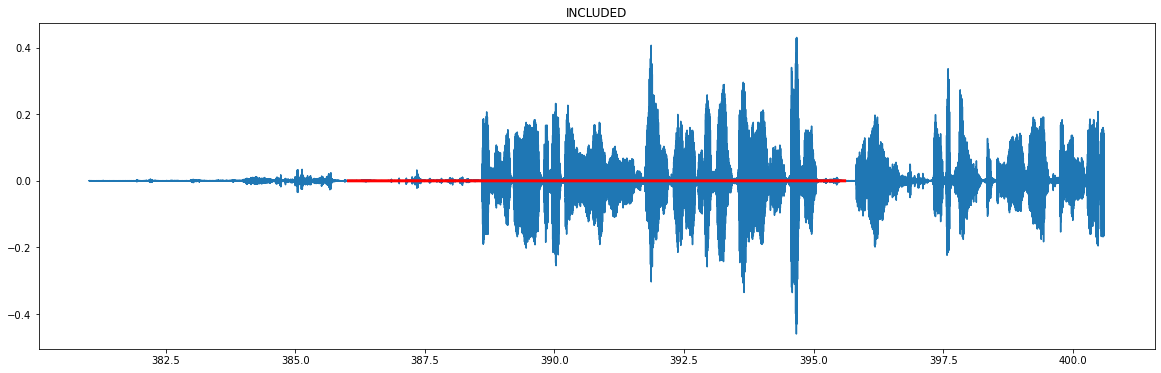

[NeMo I 2020-10-30 12:39:57 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 12:39:57 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |che bảo là cái đợt này cháu ấy đấy hôm qua hôm kia ấy đi đám ma ông xá ốm xang ấy|


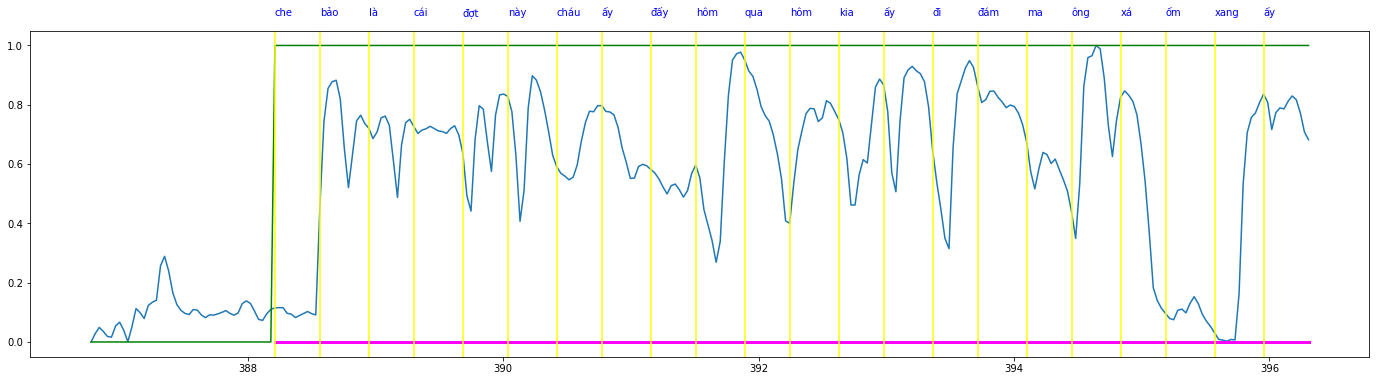

12367 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512, 7518, 7520, 7530, 7539, 7541, 7579, 7582, 8054, 8554, 8949, 8951, 8958, 9319, 9907, 10231, 10234, 10626, 11036, 11038, 11560, 11695, 11697, 11741, 11743, 11797, 11802, 11833, 11835, 11923, 11925, 11928, 11932, 12084, 12087, 12363, 12367]
READ_HEAD 12367
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 0: []
cutoff -78.44221105527639 #silences 0: []
cutoff -78.13065326633166 #silences 0: []
cutoff -77.81909547738694 #silences 1: [(2450, 2452)]
cutoff -77.50753768844221 #silences 7: [(2450, 2453), (2461, 246

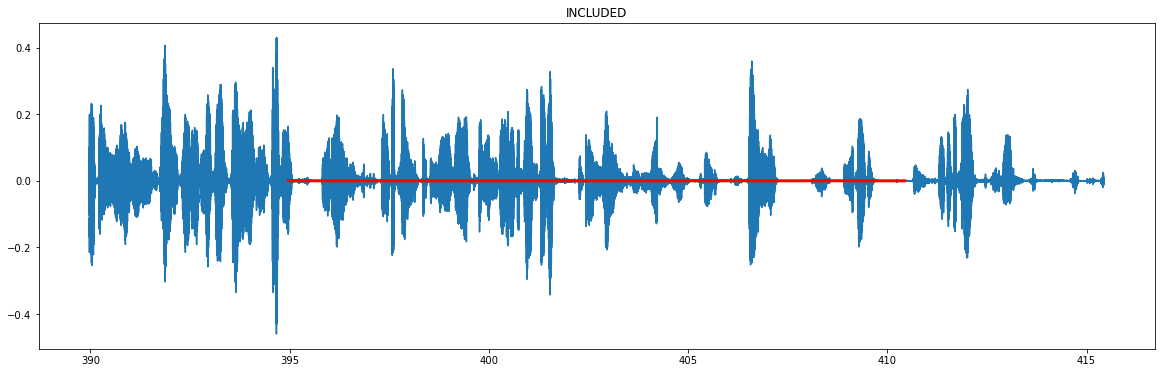

[NeMo I 2020-10-30 12:39:58 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 12:39:58 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |đâ là chá tắt máy xe không nghe sợ ôngấy gọi đến ăn cơm ăn kiết ấy ăn cơm ấy không muốn thế là thôi bài ấy bảo ừ lớ à khe đút|


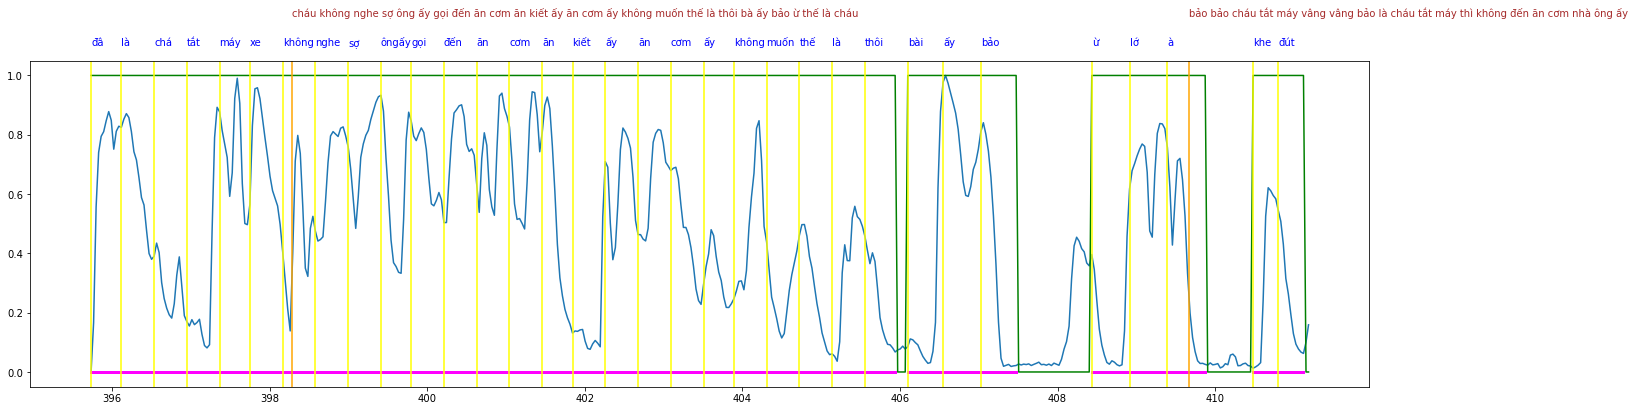

12827 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512, 7518, 7520, 7530, 7539, 7541, 7579, 7582, 8054, 8554, 8949, 8951, 8958, 9319, 9907, 10231, 10234, 10626, 11036, 11038, 11560, 11695, 11697, 11741, 11743, 11797, 11802, 11833, 11835, 11923, 11925, 11928, 11932, 12084, 12087, 12363, 12367, 12827]
READ_HEAD 12827
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 0: []
cutoff -78.44221105527639 #silences 0: []
cutoff -78.13065326633166 #silences 0: []
cutoff -77.81909547738694 #silences 1: [(1990, 1992)]
cutoff -77.50753768844221 #silences 7: [(1990, 1993), (20

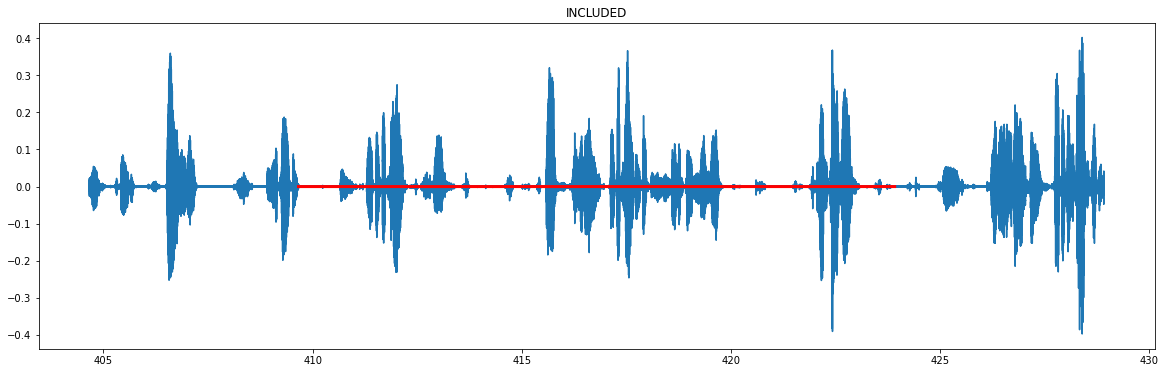

[NeMo I 2020-10-30 12:39:58 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 12:39:58 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |bảo bảo cháu tắt máy vâng vâng bảo là cháu tắt máy thì không đến đăn cơm nhà ông ấy khôn đến đăn cơm ấy|


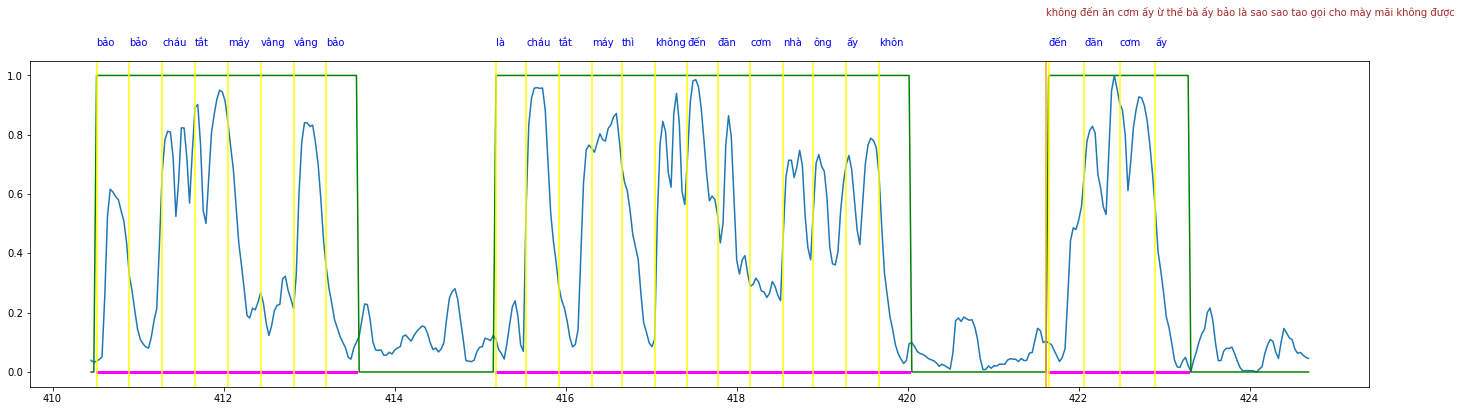

13248 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512, 7518, 7520, 7530, 7539, 7541, 7579, 7582, 8054, 8554, 8949, 8951, 8958, 9319, 9907, 10231, 10234, 10626, 11036, 11038, 11560, 11695, 11697, 11741, 11743, 11797, 11802, 11833, 11835, 11923, 11925, 11928, 11932, 12084, 12087, 12363, 12367, 12827, 13248]
READ_HEAD 13248
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 0: []
cutoff -78.44221105527639 #silences 0: []
cutoff -78.13065326633166 #silences 0: []
cutoff -77.81909547738694 #silences 1: [(1569, 1571)]
cutoff -77.50753768844221 #silences 7: [(1569, 157

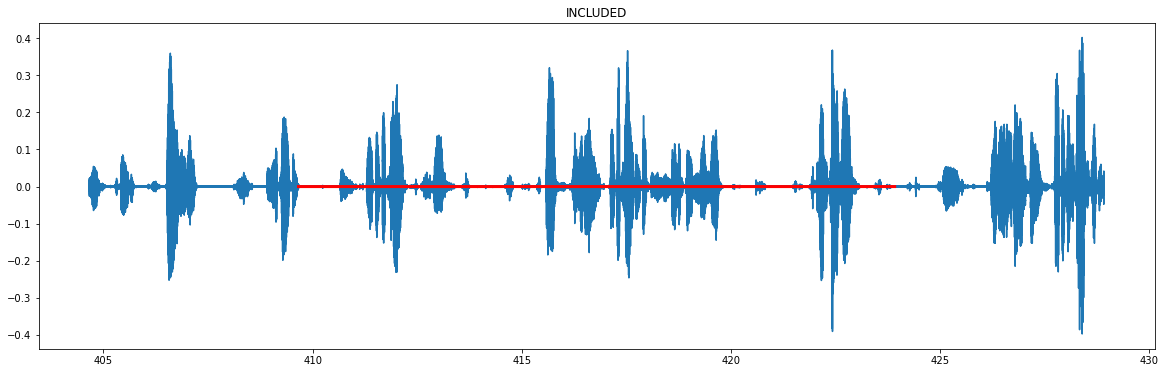

[NeMo I 2020-10-30 12:39:59 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 12:39:59 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |bảo bảo cháu tắt máy vâng vâng bảo là cháu tắt máy thì không đến đăn cơm nhà ông ấy khôn đến đăn cơm ấy|


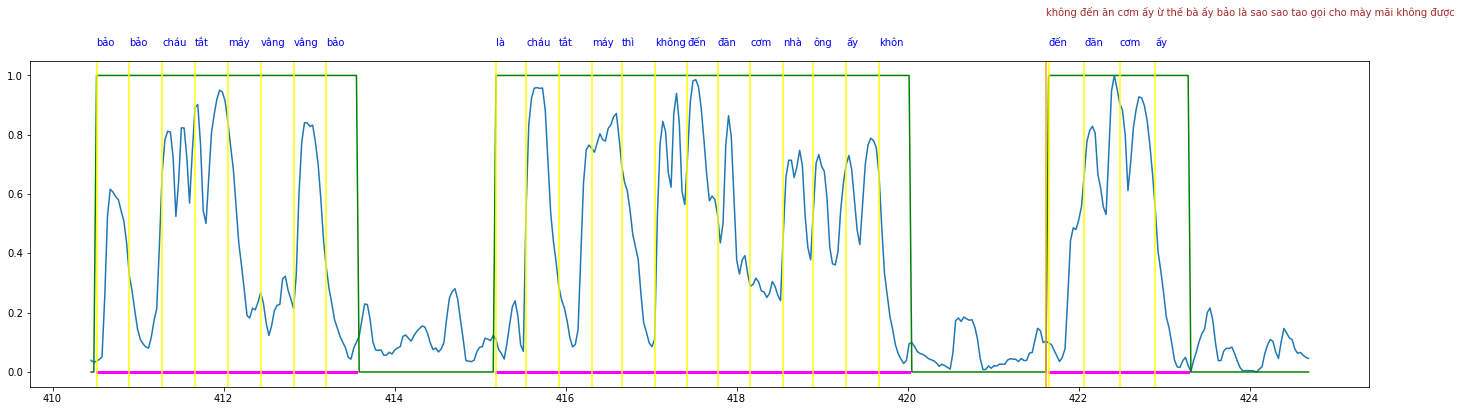

13254 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512, 7518, 7520, 7530, 7539, 7541, 7579, 7582, 8054, 8554, 8949, 8951, 8958, 9319, 9907, 10231, 10234, 10626, 11036, 11038, 11560, 11695, 11697, 11741, 11743, 11797, 11802, 11833, 11835, 11923, 11925, 11928, 11932, 12084, 12087, 12363, 12367, 12827, 13248, 13254]
READ_HEAD 13254
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 0: []
cutoff -78.44221105527639 #silences 0: []
cutoff -78.13065326633166 #silences 0: []
cutoff -77.81909547738694 #silences 1: [(1563, 1565)]
cutoff -77.50753768844221 #silences 7: [(15

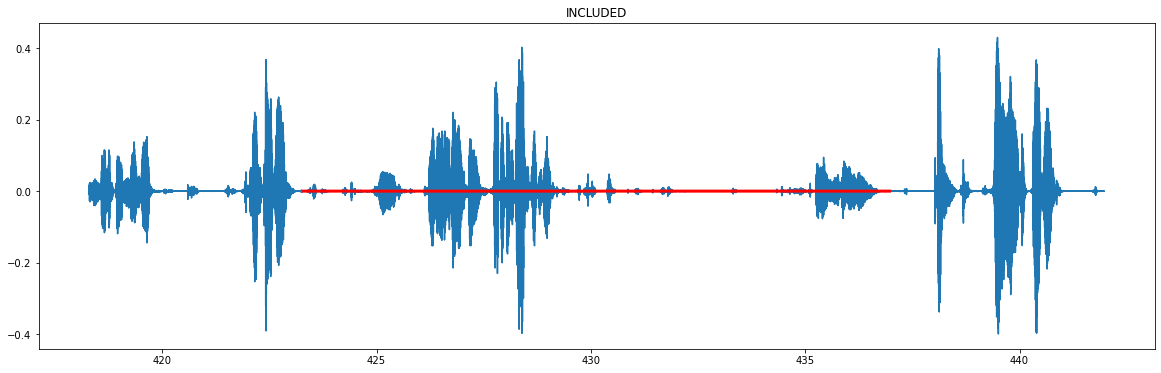

[NeMo I 2020-10-30 12:39:59 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 12:39:59 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |ừ thế bày bảo là sao sao tao gọi cho mày mãi không được thí bảo lài|


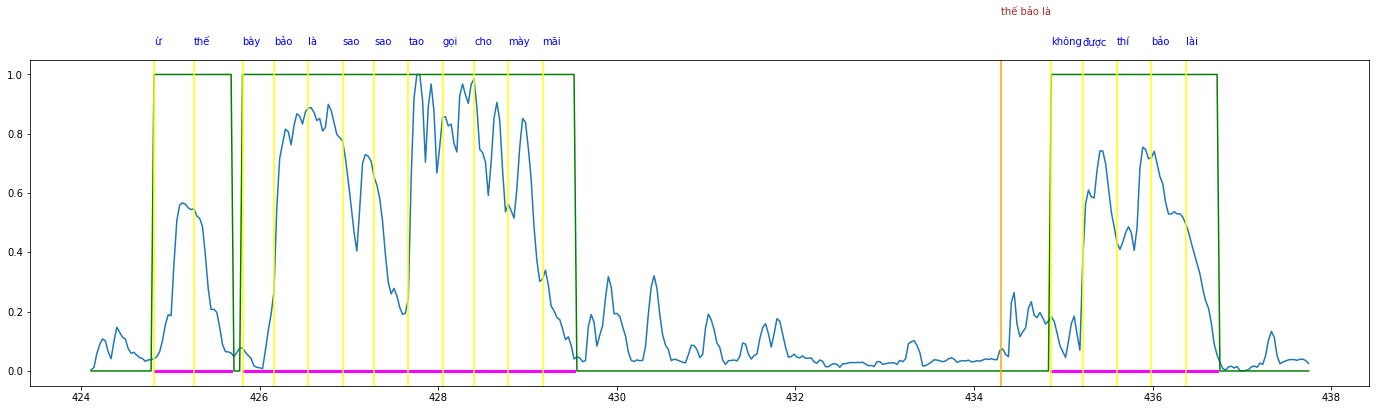

13656 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512, 7518, 7520, 7530, 7539, 7541, 7579, 7582, 8054, 8554, 8949, 8951, 8958, 9319, 9907, 10231, 10234, 10626, 11036, 11038, 11560, 11695, 11697, 11741, 11743, 11797, 11802, 11833, 11835, 11923, 11925, 11928, 11932, 12084, 12087, 12363, 12367, 12827, 13248, 13254, 13656]
READ_HEAD 13656
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 0: []
cutoff -78.44221105527639 #silences 0: []
cutoff -78.13065326633166 #silences 0: []
cutoff -77.81909547738694 #silences 1: [(1161, 1163)]
cutoff -77.50753768844221 #silences 

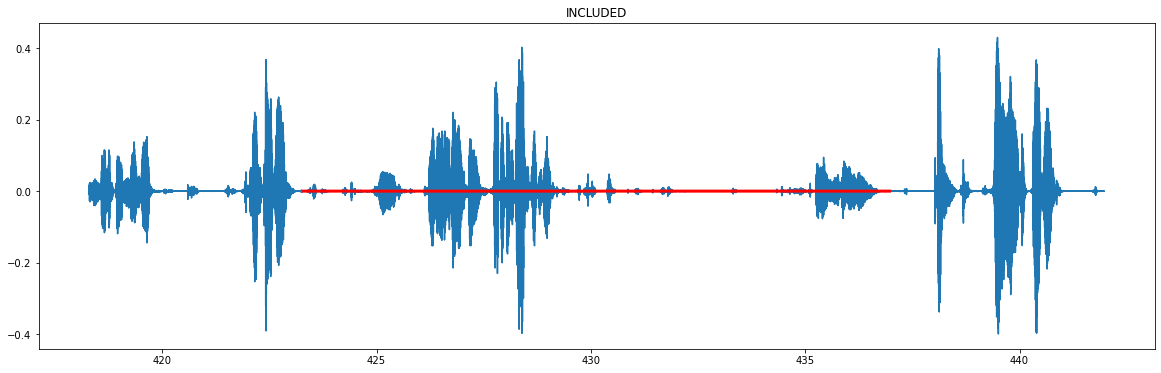

[NeMo I 2020-10-30 12:40:00 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 12:40:00 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |ừ thế bày bảo là sao sao tao gọi cho mày mãi không được thí bảo lài|


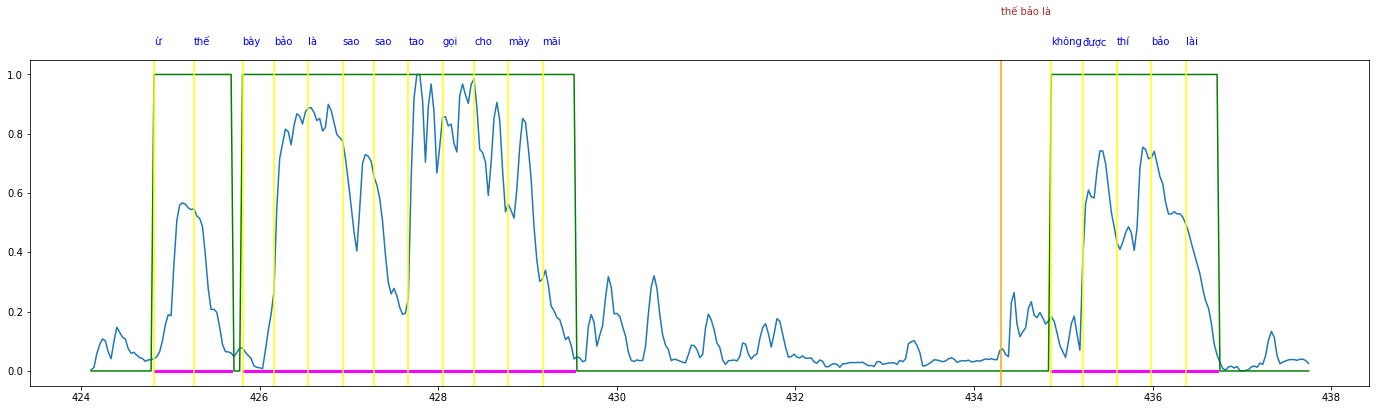

13659 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512, 7518, 7520, 7530, 7539, 7541, 7579, 7582, 8054, 8554, 8949, 8951, 8958, 9319, 9907, 10231, 10234, 10626, 11036, 11038, 11560, 11695, 11697, 11741, 11743, 11797, 11802, 11833, 11835, 11923, 11925, 11928, 11932, 12084, 12087, 12363, 12367, 12827, 13248, 13254, 13656, 13659]
READ_HEAD 13659
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 0: []
cutoff -78.44221105527639 #silences 0: []
cutoff -78.13065326633166 #silences 0: []
cutoff -77.81909547738694 #silences 1: [(1158, 1160)]
cutoff -77.50753768844221 #si

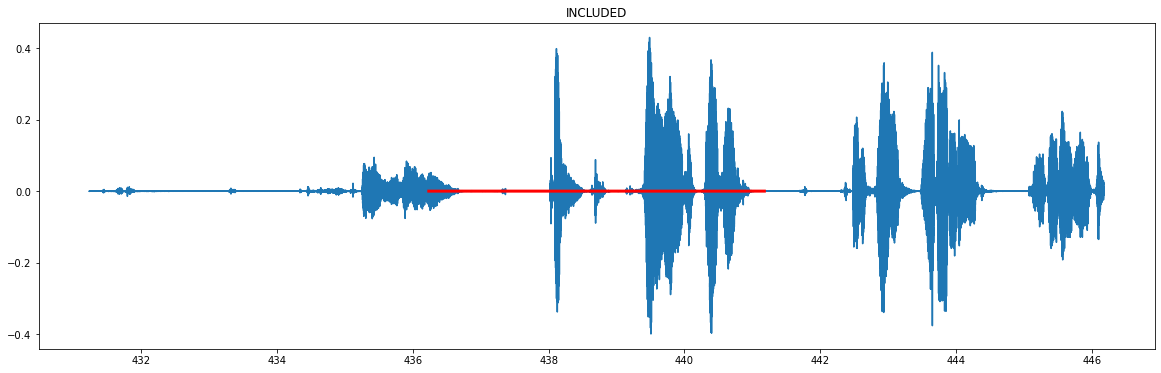

[NeMo I 2020-10-30 12:40:00 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 12:40:00 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |ci ngay lúc sáng ấy|


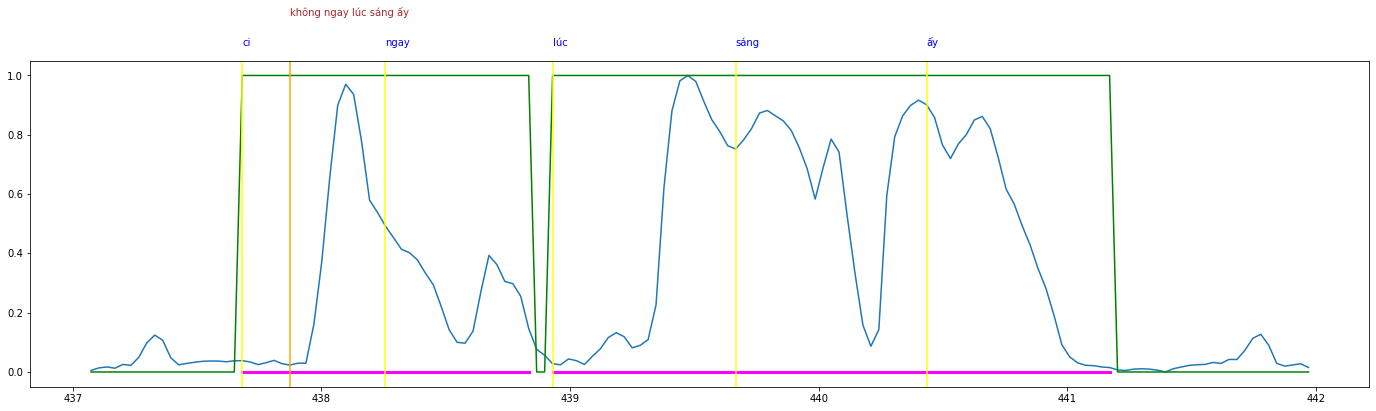

13787 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512, 7518, 7520, 7530, 7539, 7541, 7579, 7582, 8054, 8554, 8949, 8951, 8958, 9319, 9907, 10231, 10234, 10626, 11036, 11038, 11560, 11695, 11697, 11741, 11743, 11797, 11802, 11833, 11835, 11923, 11925, 11928, 11932, 12084, 12087, 12363, 12367, 12827, 13248, 13254, 13656, 13659, 13787]
READ_HEAD 13787
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 0: []
cutoff -78.44221105527639 #silences 0: []
cutoff -78.13065326633166 #silences 0: []
cutoff -77.81909547738694 #silences 1: [(1030, 1032)]
cutoff -77.50753768844

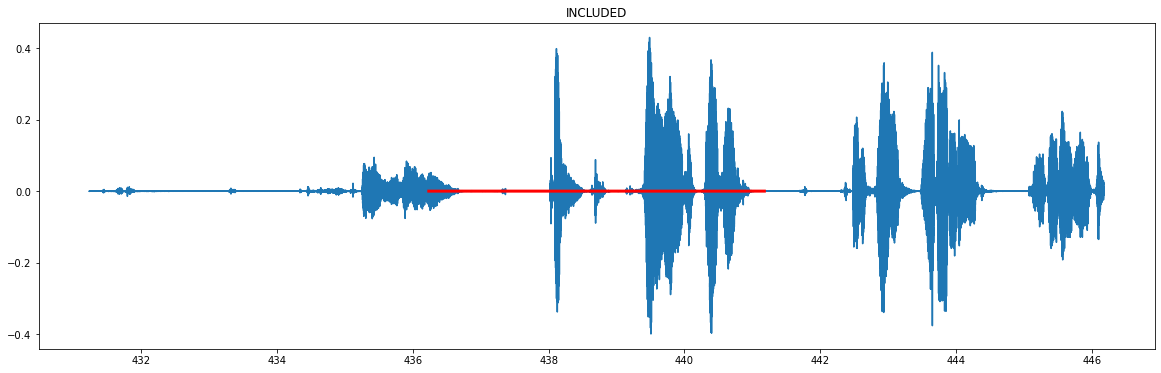

[NeMo I 2020-10-30 12:40:00 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 12:40:00 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |ci ngay lúc sáng ấy|


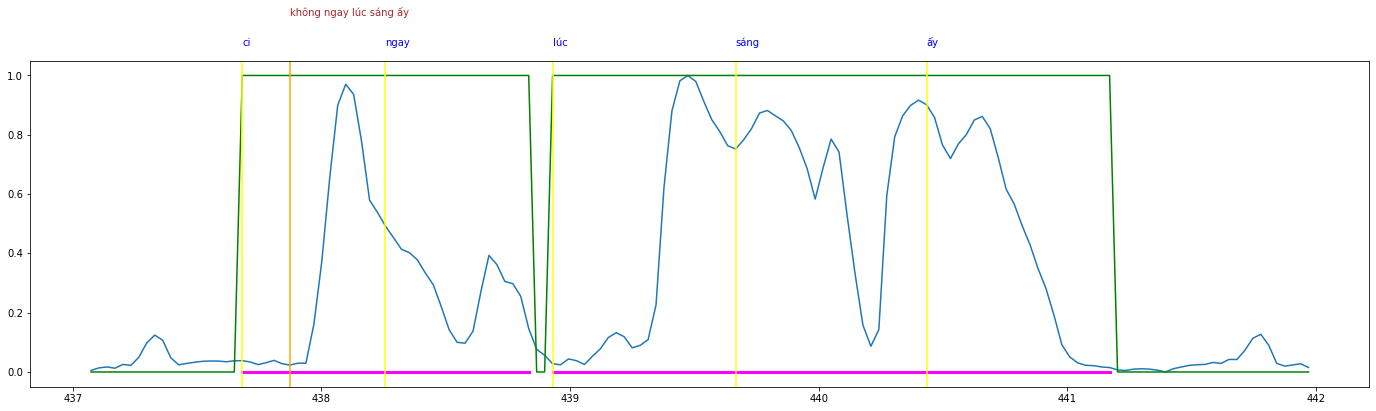

13795 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512, 7518, 7520, 7530, 7539, 7541, 7579, 7582, 8054, 8554, 8949, 8951, 8958, 9319, 9907, 10231, 10234, 10626, 11036, 11038, 11560, 11695, 11697, 11741, 11743, 11797, 11802, 11833, 11835, 11923, 11925, 11928, 11932, 12084, 12087, 12363, 12367, 12827, 13248, 13254, 13656, 13659, 13787, 13795]
READ_HEAD 13795
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 0: []
cutoff -78.44221105527639 #silences 0: []
cutoff -78.13065326633166 #silences 0: []
cutoff -77.81909547738694 #silences 1: [(1022, 1024)]
cutoff -77.5075

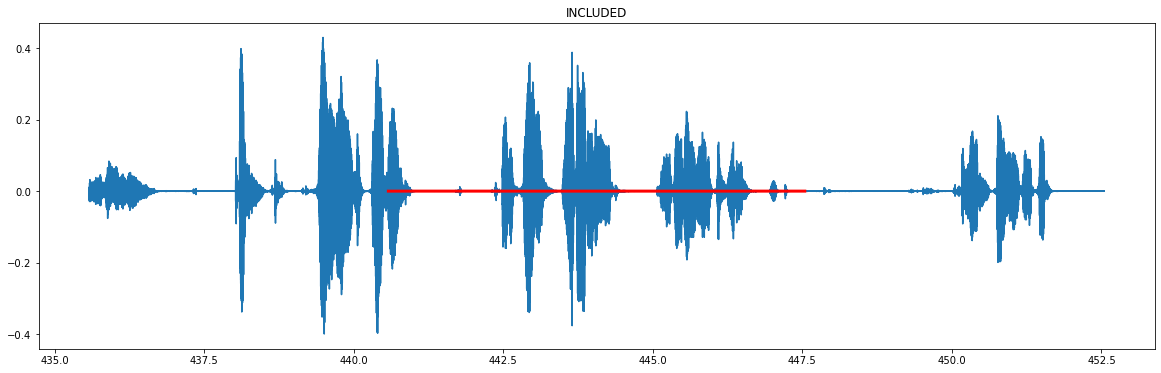

[NeMo I 2020-10-30 12:40:01 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 12:40:01 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |ê lúc chiều bà ấy về đây rồi bà ấy về bà ấy sang nhàừ|


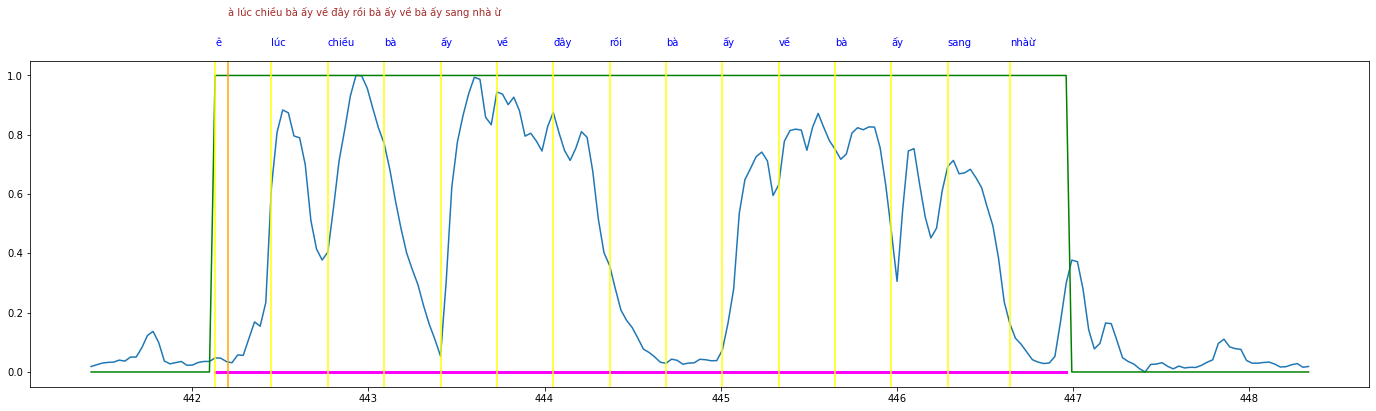

13986 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512, 7518, 7520, 7530, 7539, 7541, 7579, 7582, 8054, 8554, 8949, 8951, 8958, 9319, 9907, 10231, 10234, 10626, 11036, 11038, 11560, 11695, 11697, 11741, 11743, 11797, 11802, 11833, 11835, 11923, 11925, 11928, 11932, 12084, 12087, 12363, 12367, 12827, 13248, 13254, 13656, 13659, 13787, 13795, 13986]
READ_HEAD 13986
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 0: []
cutoff -78.44221105527639 #silences 0: []
cutoff -78.13065326633166 #silences 0: []
cutoff -77.81909547738694 #silences 1: [(831, 833)]
cutoff -77

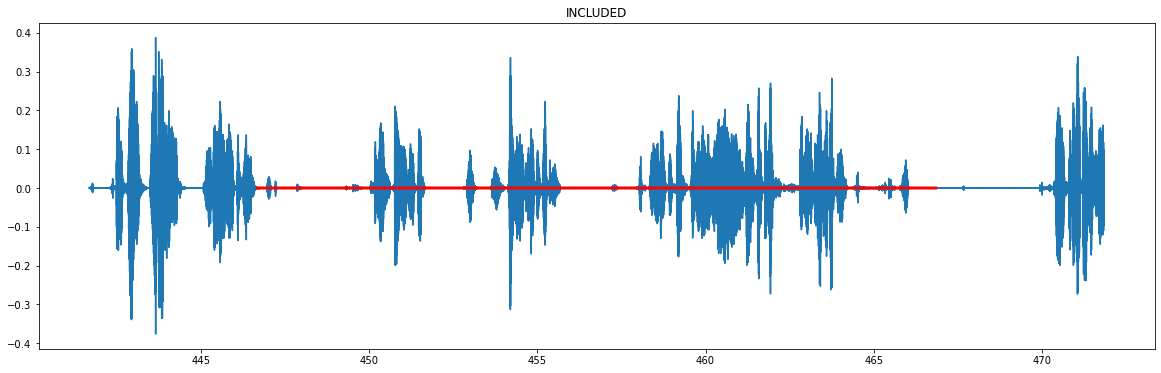

[NeMo I 2020-10-30 12:40:01 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 12:40:01 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |ônh k biết thấy b bả trướm ấy thồi trêm hồi ấy đi vào Phú Quốc có mà bã ấy vào pPhú Quốc đong bắt đầu rồi nà ấy lại xuất hiện chẳng biết là bà ấy đi làm ở đâu ế|


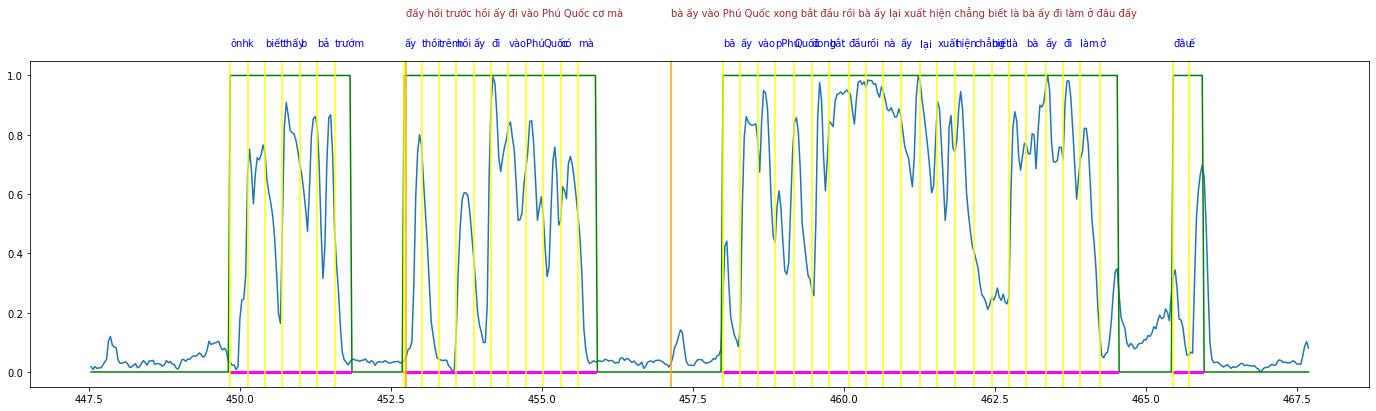

14590 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512, 7518, 7520, 7530, 7539, 7541, 7579, 7582, 8054, 8554, 8949, 8951, 8958, 9319, 9907, 10231, 10234, 10626, 11036, 11038, 11560, 11695, 11697, 11741, 11743, 11797, 11802, 11833, 11835, 11923, 11925, 11928, 11932, 12084, 12087, 12363, 12367, 12827, 13248, 13254, 13656, 13659, 13787, 13795, 13986, 14590]
READ_HEAD 14590
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 0: []
cutoff -78.44221105527639 #silences 0: []
cutoff -78.13065326633166 #silences 0: []
cutoff -77.81909547738694 #silences 1: [(227, 229)]
sto

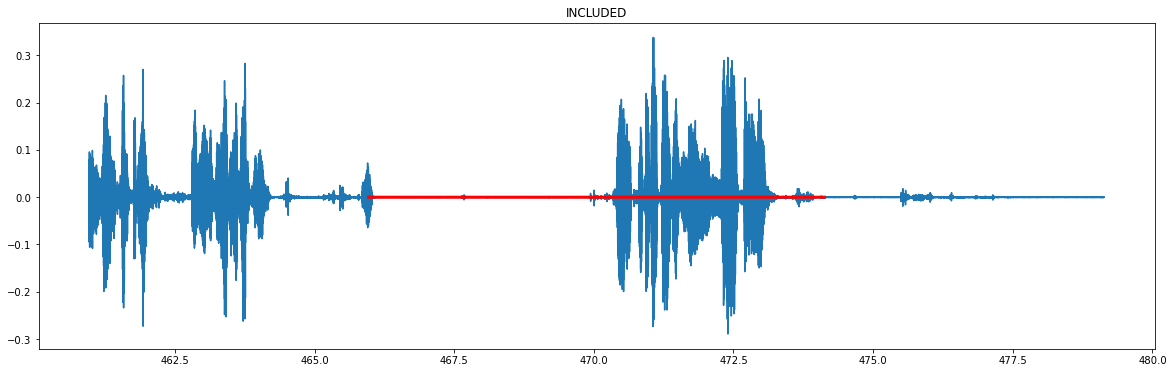

[NeMo I 2020-10-30 12:40:02 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 12:40:02 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |tê thì cái đợt đấy xong bắt đầu là mãi sau em|


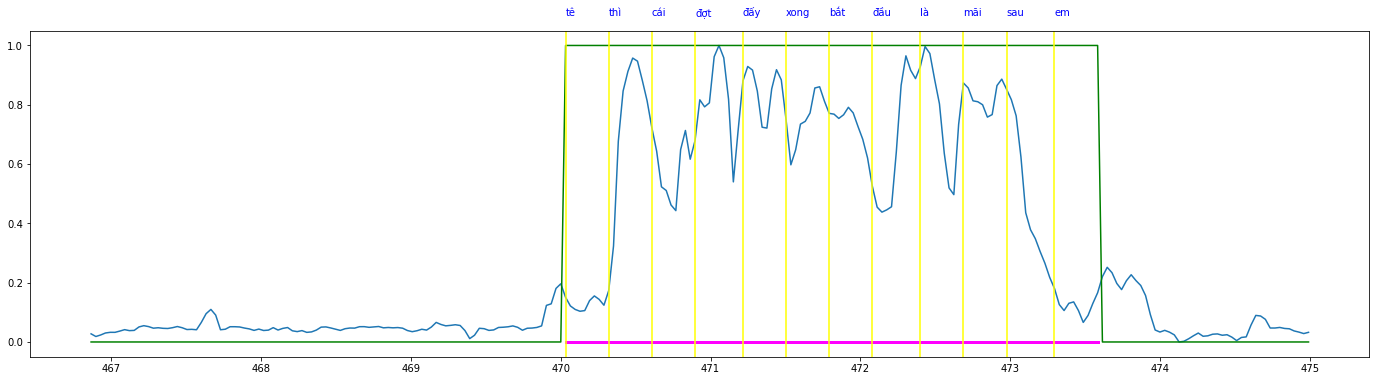

14817 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512, 7518, 7520, 7530, 7539, 7541, 7579, 7582, 8054, 8554, 8949, 8951, 8958, 9319, 9907, 10231, 10234, 10626, 11036, 11038, 11560, 11695, 11697, 11741, 11743, 11797, 11802, 11833, 11835, 11923, 11925, 11928, 11932, 12084, 12087, 12363, 12367, 12827, 13248, 13254, 13656, 13659, 13787, 13795, 13986, 14590, 14817]
READ_HEAD 14817
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 0: []
cutoff -78.44221105527639 #silences 0: []
cutoff -78.13065326633166 #silences 0: []
cutoff -77.81909547738694 #silences 1: [(0, 2)]


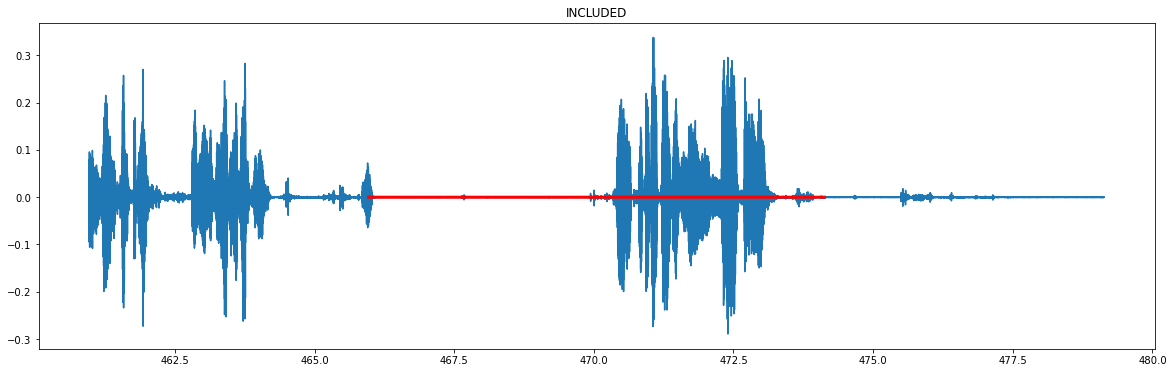

[NeMo I 2020-10-30 12:40:02 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 12:40:02 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |tê thì cái đợt đấy xong bắt đầu là mãi sau em|


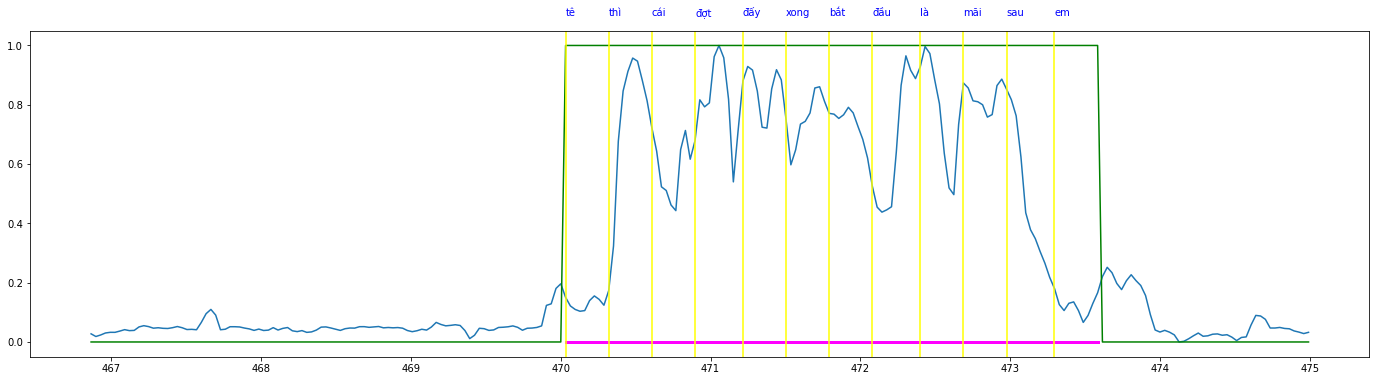

14819 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512, 7518, 7520, 7530, 7539, 7541, 7579, 7582, 8054, 8554, 8949, 8951, 8958, 9319, 9907, 10231, 10234, 10626, 11036, 11038, 11560, 11695, 11697, 11741, 11743, 11797, 11802, 11833, 11835, 11923, 11925, 11928, 11932, 12084, 12087, 12363, 12367, 12827, 13248, 13254, 13656, 13659, 13787, 13795, 13986, 14590, 14817, 14819]
READ_HEAD 14819
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 0: []
cutoff -78.44221105527639 #silences 0: []
cutoff -78.13065326633166 #silences 0: []
cutoff -77.81909547738694 #silences 0: []

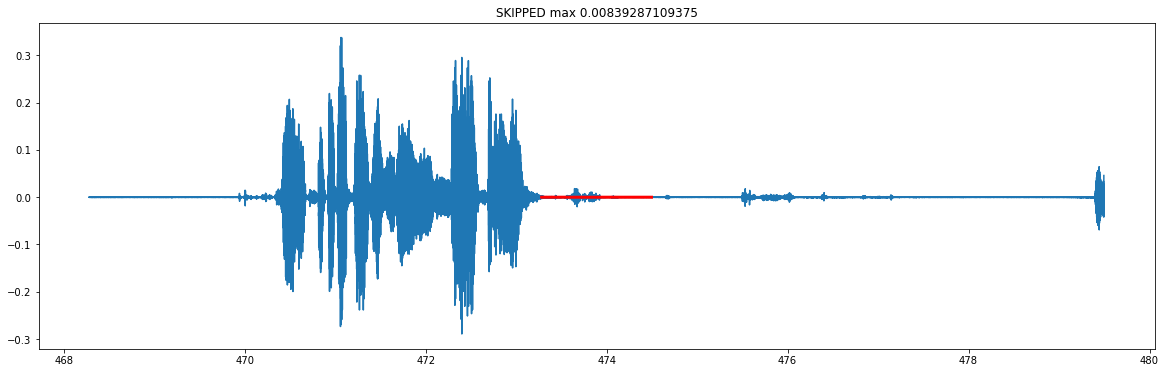

14828 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512, 7518, 7520, 7530, 7539, 7541, 7579, 7582, 8054, 8554, 8949, 8951, 8958, 9319, 9907, 10231, 10234, 10626, 11036, 11038, 11560, 11695, 11697, 11741, 11743, 11797, 11802, 11833, 11835, 11923, 11925, 11928, 11932, 12084, 12087, 12363, 12367, 12827, 13248, 13254, 13656, 13659, 13787, 13795, 13986, 14590, 14817, 14819, 14828]
READ_HEAD 14828
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 0: []
cutoff -78.44221105527639 #silences 0: []
cutoff -78.13065326633166 #silences 0: []
cutoff -77.81909547738694 #silence

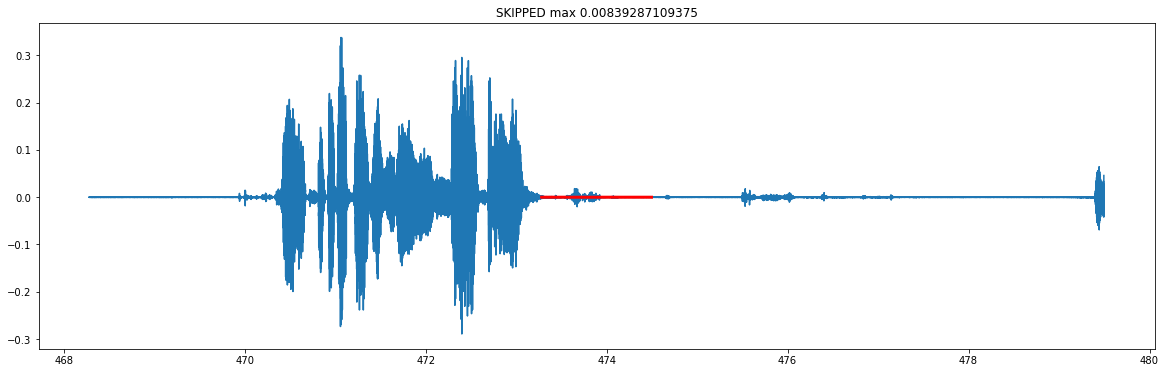

14831 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512, 7518, 7520, 7530, 7539, 7541, 7579, 7582, 8054, 8554, 8949, 8951, 8958, 9319, 9907, 10231, 10234, 10626, 11036, 11038, 11560, 11695, 11697, 11741, 11743, 11797, 11802, 11833, 11835, 11923, 11925, 11928, 11932, 12084, 12087, 12363, 12367, 12827, 13248, 13254, 13656, 13659, 13787, 13795, 13986, 14590, 14817, 14819, 14828, 14831]
READ_HEAD 14831
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 0: []
cutoff -78.44221105527639 #silences 0: []
cutoff -78.13065326633166 #silences 0: []
cutoff -77.81909547738694 #

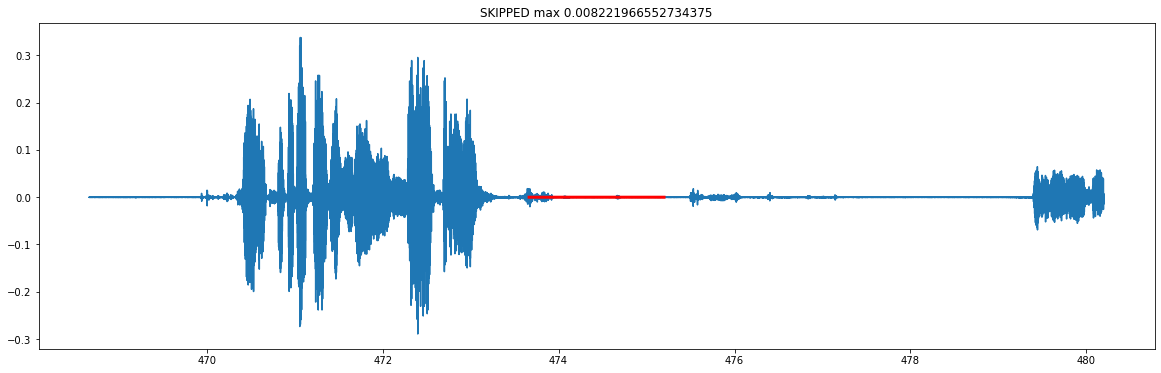

14850 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512, 7518, 7520, 7530, 7539, 7541, 7579, 7582, 8054, 8554, 8949, 8951, 8958, 9319, 9907, 10231, 10234, 10626, 11036, 11038, 11560, 11695, 11697, 11741, 11743, 11797, 11802, 11833, 11835, 11923, 11925, 11928, 11932, 12084, 12087, 12363, 12367, 12827, 13248, 13254, 13656, 13659, 13787, 13795, 13986, 14590, 14817, 14819, 14828, 14831, 14850]
READ_HEAD 14850
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 0: []
cutoff -78.44221105527639 #silences 0: []
cutoff -78.13065326633166 #silences 0: []
cutoff -77.819095477

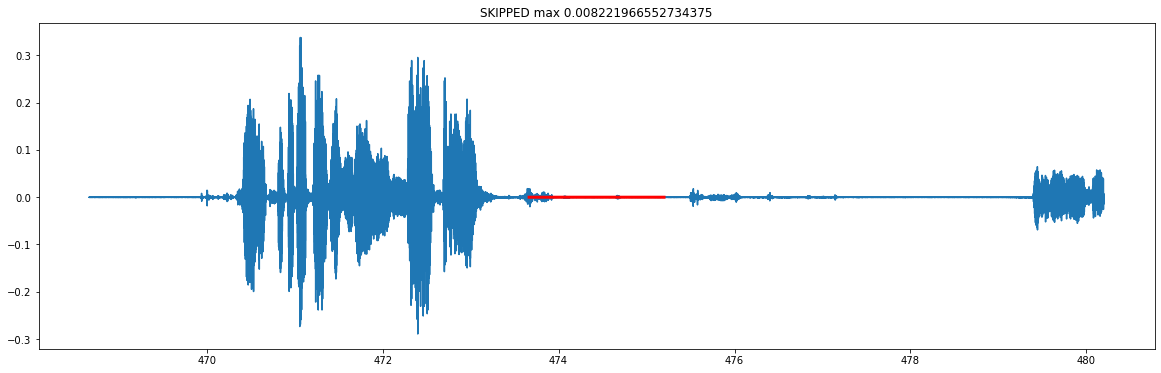

14853 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512, 7518, 7520, 7530, 7539, 7541, 7579, 7582, 8054, 8554, 8949, 8951, 8958, 9319, 9907, 10231, 10234, 10626, 11036, 11038, 11560, 11695, 11697, 11741, 11743, 11797, 11802, 11833, 11835, 11923, 11925, 11928, 11932, 12084, 12087, 12363, 12367, 12827, 13248, 13254, 13656, 13659, 13787, 13795, 13986, 14590, 14817, 14819, 14828, 14831, 14850, 14853]
READ_HEAD 14853
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 0: []
cutoff -78.44221105527639 #silences 0: []
cutoff -78.13065326633166 #silences 0: []
cutoff -77.81

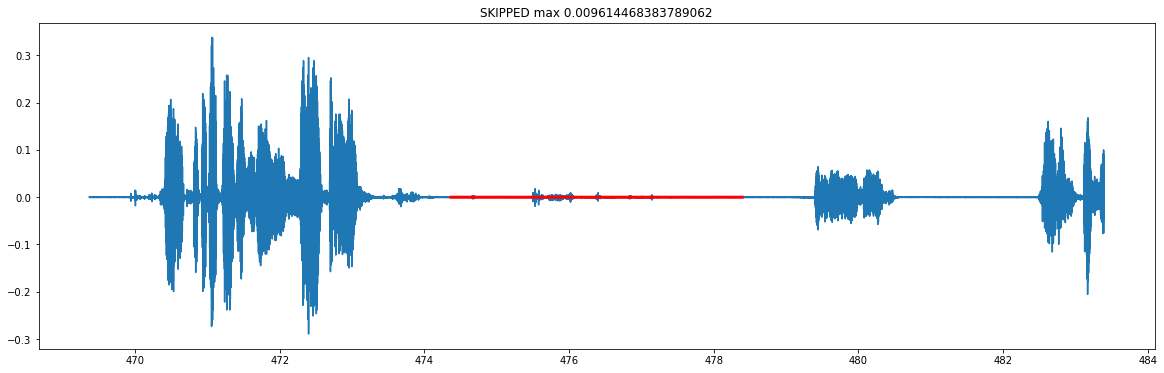

14950 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512, 7518, 7520, 7530, 7539, 7541, 7579, 7582, 8054, 8554, 8949, 8951, 8958, 9319, 9907, 10231, 10234, 10626, 11036, 11038, 11560, 11695, 11697, 11741, 11743, 11797, 11802, 11833, 11835, 11923, 11925, 11928, 11932, 12084, 12087, 12363, 12367, 12827, 13248, 13254, 13656, 13659, 13787, 13795, 13986, 14590, 14817, 14819, 14828, 14831, 14850, 14853, 14950]
READ_HEAD 14950
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 0: []
cutoff -78.44221105527639 #silences 0: []
cutoff -78.13065326633166 #silences 0: []
cutoff

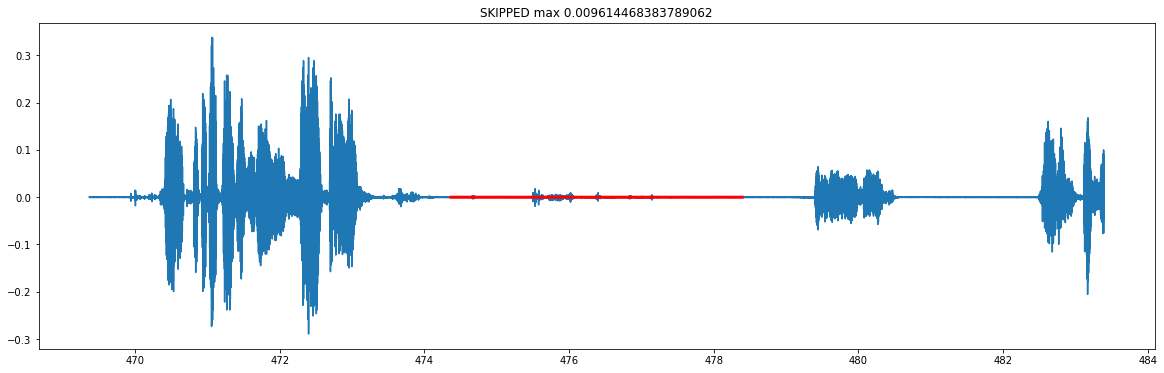

14960 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512, 7518, 7520, 7530, 7539, 7541, 7579, 7582, 8054, 8554, 8949, 8951, 8958, 9319, 9907, 10231, 10234, 10626, 11036, 11038, 11560, 11695, 11697, 11741, 11743, 11797, 11802, 11833, 11835, 11923, 11925, 11928, 11932, 12084, 12087, 12363, 12367, 12827, 13248, 13254, 13656, 13659, 13787, 13795, 13986, 14590, 14817, 14819, 14828, 14831, 14850, 14853, 14950, 14960]
READ_HEAD 14960
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 0: []
cutoff -78.44221105527639 #silences 0: []
cutoff -78.13065326633166 #silences 0: []

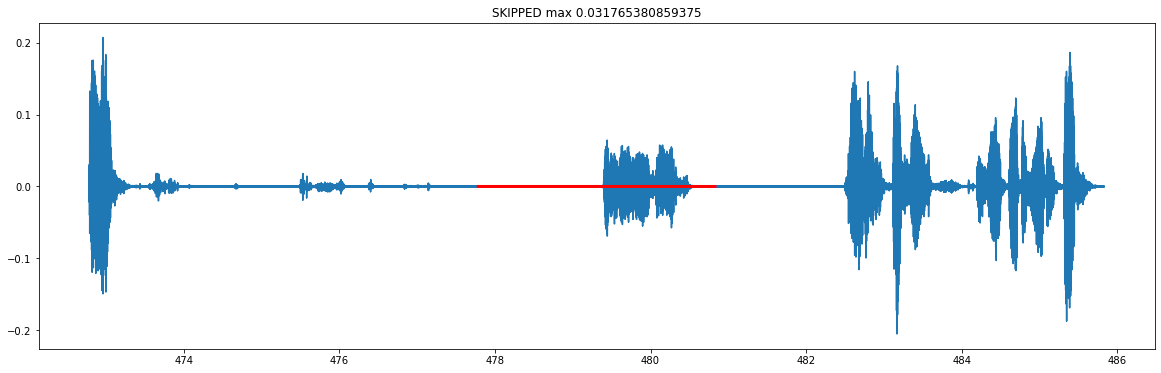

15026 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512, 7518, 7520, 7530, 7539, 7541, 7579, 7582, 8054, 8554, 8949, 8951, 8958, 9319, 9907, 10231, 10234, 10626, 11036, 11038, 11560, 11695, 11697, 11741, 11743, 11797, 11802, 11833, 11835, 11923, 11925, 11928, 11932, 12084, 12087, 12363, 12367, 12827, 13248, 13254, 13656, 13659, 13787, 13795, 13986, 14590, 14817, 14819, 14828, 14831, 14850, 14853, 14950, 14960, 15026]
READ_HEAD 15026
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 0: []
cutoff -78.44221105527639 #silences 0: []
cutoff -78.13065326633166 #silence

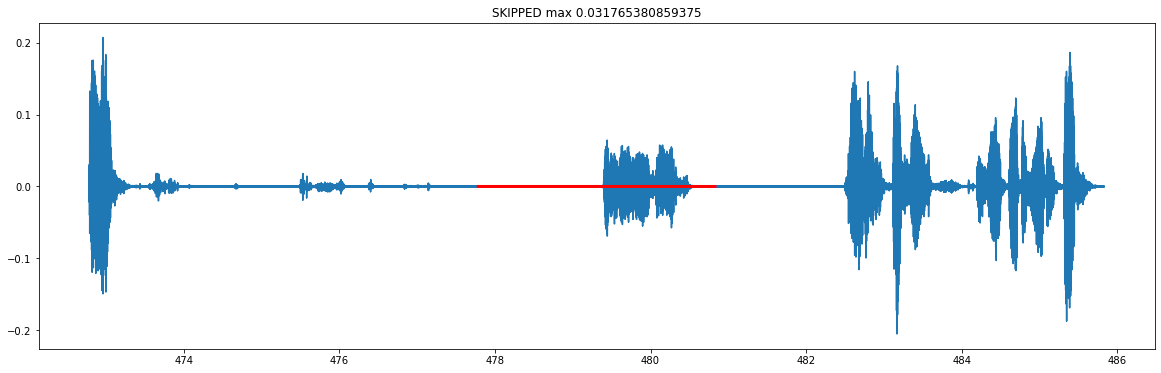

15031 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512, 7518, 7520, 7530, 7539, 7541, 7579, 7582, 8054, 8554, 8949, 8951, 8958, 9319, 9907, 10231, 10234, 10626, 11036, 11038, 11560, 11695, 11697, 11741, 11743, 11797, 11802, 11833, 11835, 11923, 11925, 11928, 11932, 12084, 12087, 12363, 12367, 12827, 13248, 13254, 13656, 13659, 13787, 13795, 13986, 14590, 14817, 14819, 14828, 14831, 14850, 14853, 14950, 14960, 15026, 15031]
READ_HEAD 15031
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 0: []
cutoff -78.44221105527639 #silences 0: []
cutoff -78.13065326633166 #

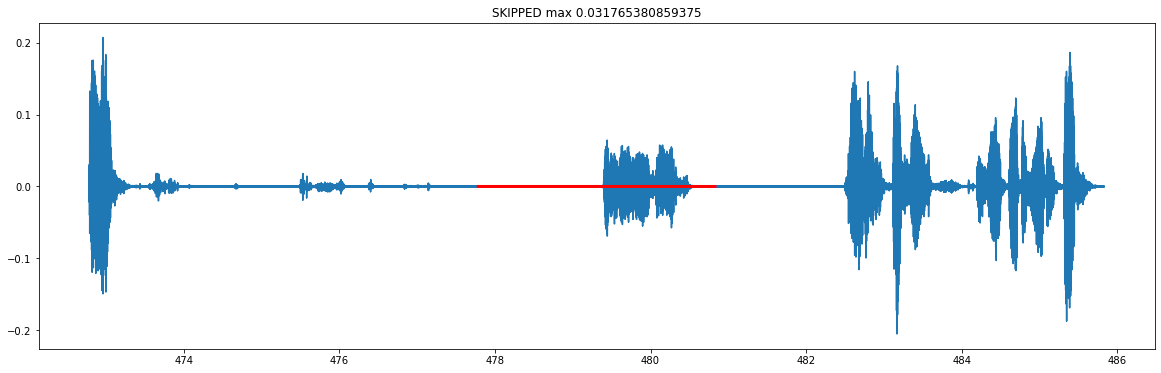

15042 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512, 7518, 7520, 7530, 7539, 7541, 7579, 7582, 8054, 8554, 8949, 8951, 8958, 9319, 9907, 10231, 10234, 10626, 11036, 11038, 11560, 11695, 11697, 11741, 11743, 11797, 11802, 11833, 11835, 11923, 11925, 11928, 11932, 12084, 12087, 12363, 12367, 12827, 13248, 13254, 13656, 13659, 13787, 13795, 13986, 14590, 14817, 14819, 14828, 14831, 14850, 14853, 14950, 14960, 15026, 15031, 15042]
READ_HEAD 15042
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 0: []
cutoff -78.44221105527639 #silences 0: []
cutoff -78.130653266

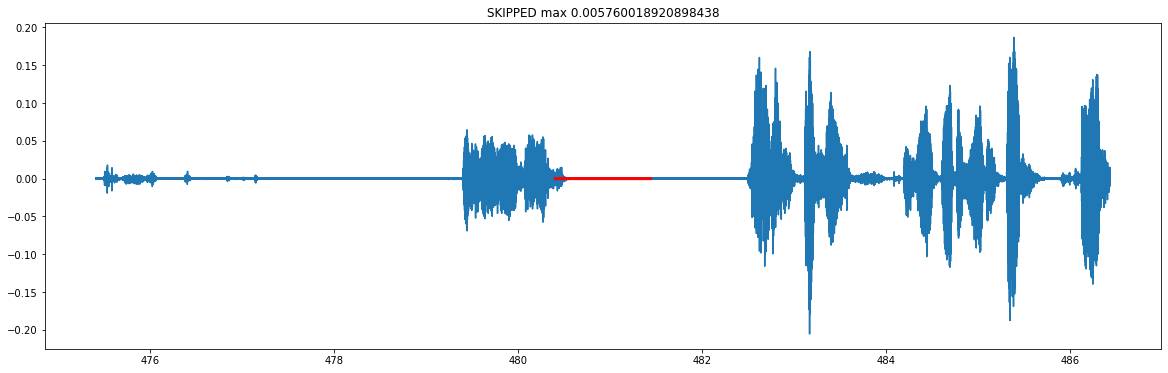

15045 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512, 7518, 7520, 7530, 7539, 7541, 7579, 7582, 8054, 8554, 8949, 8951, 8958, 9319, 9907, 10231, 10234, 10626, 11036, 11038, 11560, 11695, 11697, 11741, 11743, 11797, 11802, 11833, 11835, 11923, 11925, 11928, 11932, 12084, 12087, 12363, 12367, 12827, 13248, 13254, 13656, 13659, 13787, 13795, 13986, 14590, 14817, 14819, 14828, 14831, 14850, 14853, 14950, 14960, 15026, 15031, 15042, 15045]
READ_HEAD 15045
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 0: []
cutoff -78.44221105527639 #silences 0: []
cutoff -78.13

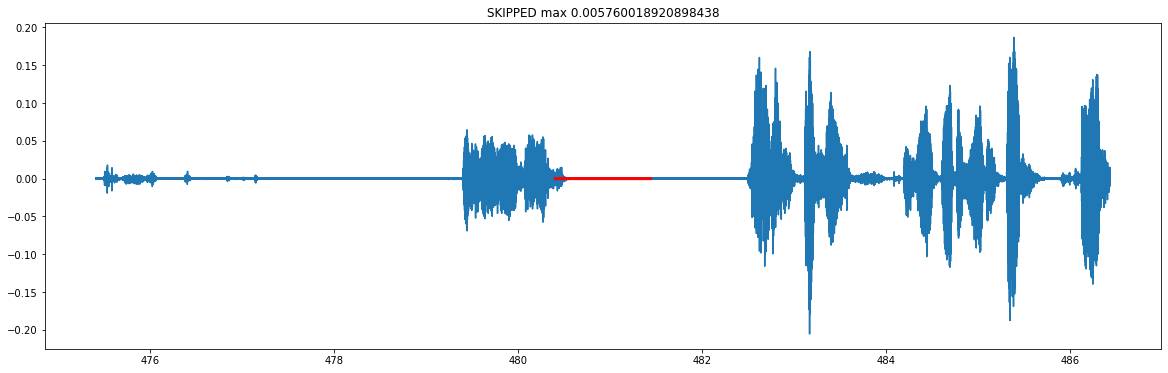

15052 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512, 7518, 7520, 7530, 7539, 7541, 7579, 7582, 8054, 8554, 8949, 8951, 8958, 9319, 9907, 10231, 10234, 10626, 11036, 11038, 11560, 11695, 11697, 11741, 11743, 11797, 11802, 11833, 11835, 11923, 11925, 11928, 11932, 12084, 12087, 12363, 12367, 12827, 13248, 13254, 13656, 13659, 13787, 13795, 13986, 14590, 14817, 14819, 14828, 14831, 14850, 14853, 14950, 14960, 15026, 15031, 15042, 15045, 15052]
READ_HEAD 15052
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 0: []
cutoff -78.44221105527639 #silences 0: []
cutoff

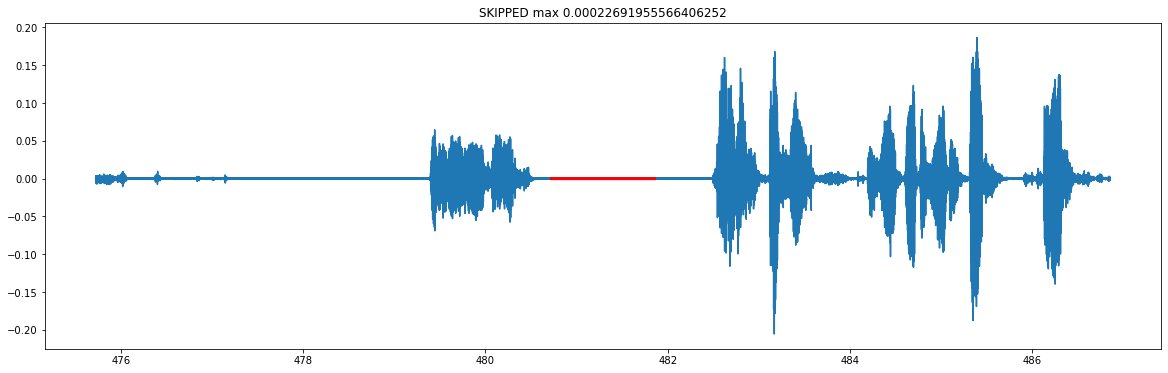

15058 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512, 7518, 7520, 7530, 7539, 7541, 7579, 7582, 8054, 8554, 8949, 8951, 8958, 9319, 9907, 10231, 10234, 10626, 11036, 11038, 11560, 11695, 11697, 11741, 11743, 11797, 11802, 11833, 11835, 11923, 11925, 11928, 11932, 12084, 12087, 12363, 12367, 12827, 13248, 13254, 13656, 13659, 13787, 13795, 13986, 14590, 14817, 14819, 14828, 14831, 14850, 14853, 14950, 14960, 15026, 15031, 15042, 15045, 15052, 15058]
READ_HEAD 15058
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 0: []
cutoff -78.44221105527639 #silences 0: []

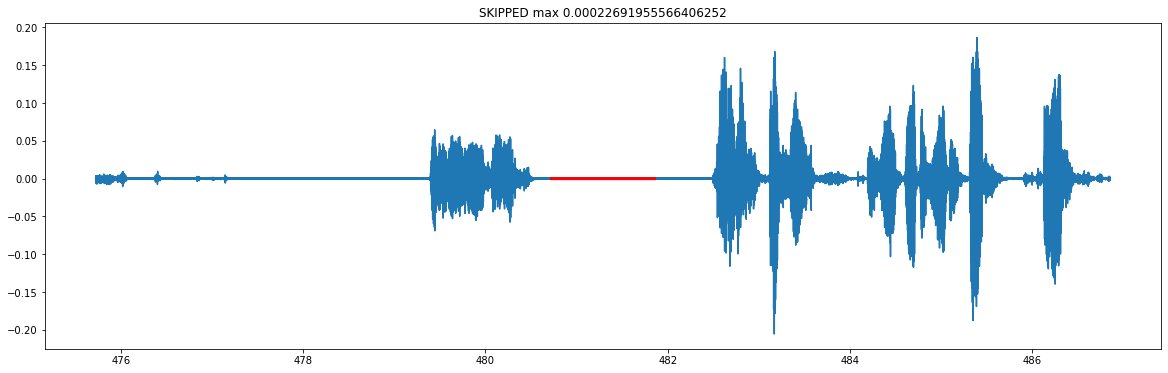

15062 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512, 7518, 7520, 7530, 7539, 7541, 7579, 7582, 8054, 8554, 8949, 8951, 8958, 9319, 9907, 10231, 10234, 10626, 11036, 11038, 11560, 11695, 11697, 11741, 11743, 11797, 11802, 11833, 11835, 11923, 11925, 11928, 11932, 12084, 12087, 12363, 12367, 12827, 13248, 13254, 13656, 13659, 13787, 13795, 13986, 14590, 14817, 14819, 14828, 14831, 14850, 14853, 14950, 14960, 15026, 15031, 15042, 15045, 15052, 15058, 15062]
READ_HEAD 15062
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 0: []
cutoff -78.44221105527639 #silence

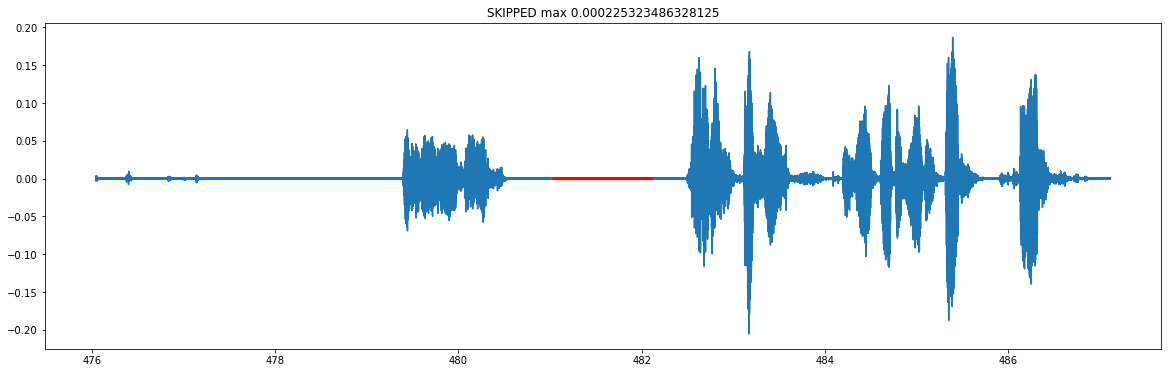

15066 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512, 7518, 7520, 7530, 7539, 7541, 7579, 7582, 8054, 8554, 8949, 8951, 8958, 9319, 9907, 10231, 10234, 10626, 11036, 11038, 11560, 11695, 11697, 11741, 11743, 11797, 11802, 11833, 11835, 11923, 11925, 11928, 11932, 12084, 12087, 12363, 12367, 12827, 13248, 13254, 13656, 13659, 13787, 13795, 13986, 14590, 14817, 14819, 14828, 14831, 14850, 14853, 14950, 14960, 15026, 15031, 15042, 15045, 15052, 15058, 15062, 15066]
READ_HEAD 15066
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 0: []
cutoff -78.44221105527639 #

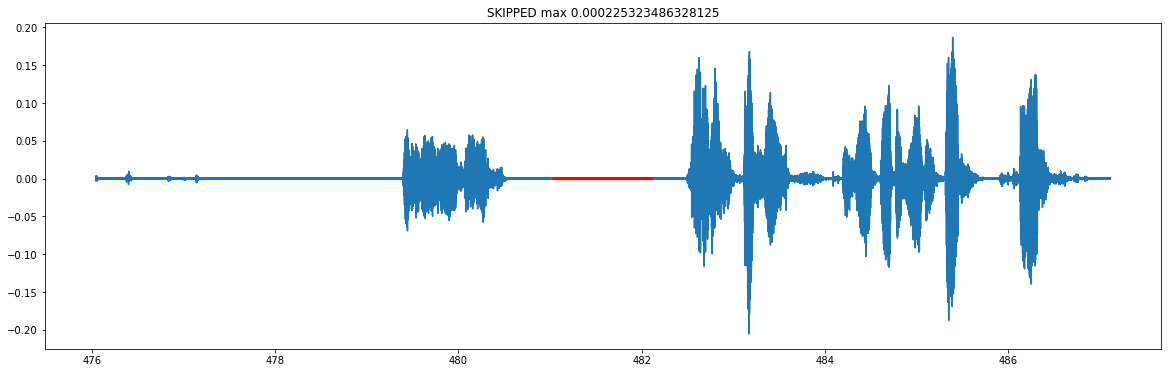

15069 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512, 7518, 7520, 7530, 7539, 7541, 7579, 7582, 8054, 8554, 8949, 8951, 8958, 9319, 9907, 10231, 10234, 10626, 11036, 11038, 11560, 11695, 11697, 11741, 11743, 11797, 11802, 11833, 11835, 11923, 11925, 11928, 11932, 12084, 12087, 12363, 12367, 12827, 13248, 13254, 13656, 13659, 13787, 13795, 13986, 14590, 14817, 14819, 14828, 14831, 14850, 14853, 14950, 14960, 15026, 15031, 15042, 15045, 15052, 15058, 15062, 15066, 15069]
READ_HEAD 15069
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 0: []
cutoff -78.442211055

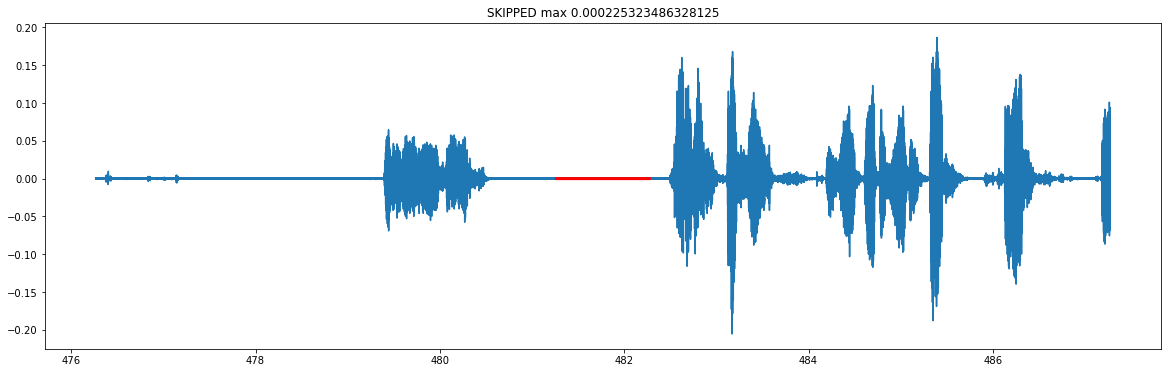

15071 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512, 7518, 7520, 7530, 7539, 7541, 7579, 7582, 8054, 8554, 8949, 8951, 8958, 9319, 9907, 10231, 10234, 10626, 11036, 11038, 11560, 11695, 11697, 11741, 11743, 11797, 11802, 11833, 11835, 11923, 11925, 11928, 11932, 12084, 12087, 12363, 12367, 12827, 13248, 13254, 13656, 13659, 13787, 13795, 13986, 14590, 14817, 14819, 14828, 14831, 14850, 14853, 14950, 14960, 15026, 15031, 15042, 15045, 15052, 15058, 15062, 15066, 15069, 15071]
READ_HEAD 15071
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 0: []
cutoff -78.44

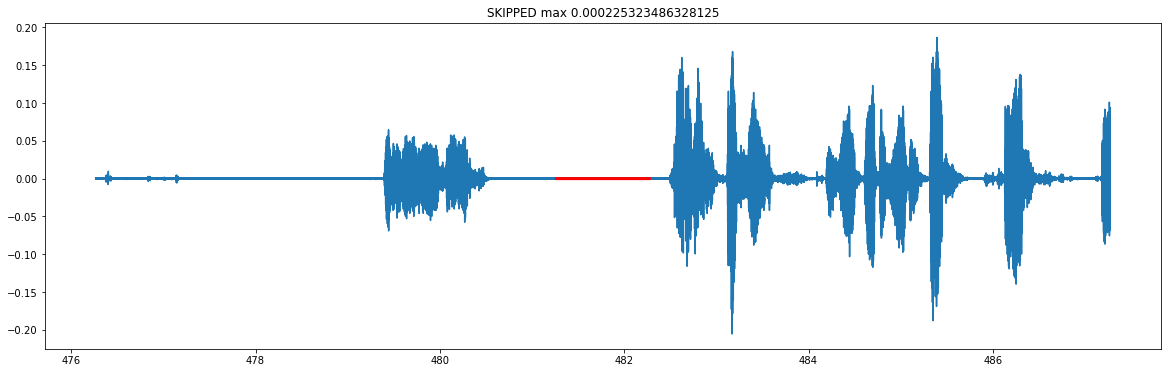

15075 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512, 7518, 7520, 7530, 7539, 7541, 7579, 7582, 8054, 8554, 8949, 8951, 8958, 9319, 9907, 10231, 10234, 10626, 11036, 11038, 11560, 11695, 11697, 11741, 11743, 11797, 11802, 11833, 11835, 11923, 11925, 11928, 11932, 12084, 12087, 12363, 12367, 12827, 13248, 13254, 13656, 13659, 13787, 13795, 13986, 14590, 14817, 14819, 14828, 14831, 14850, 14853, 14950, 14960, 15026, 15031, 15042, 15045, 15052, 15058, 15062, 15066, 15069, 15071, 15075]
READ_HEAD 15075
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 0: []
cutoff

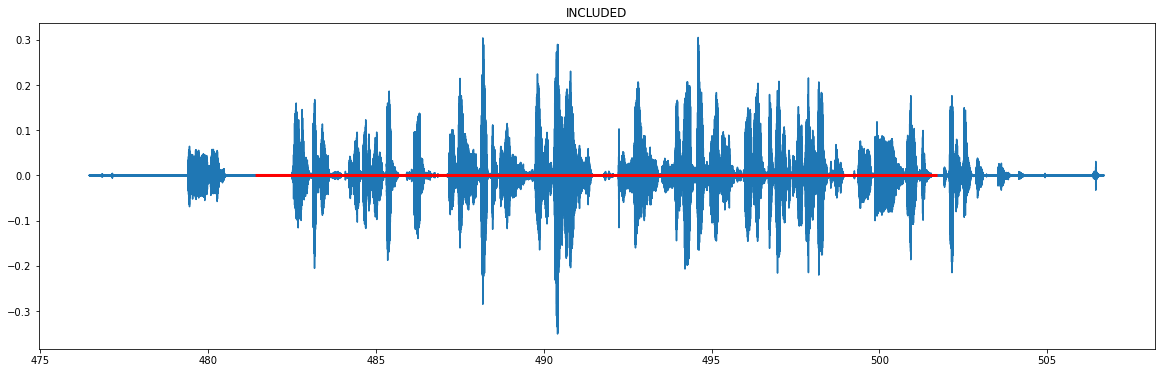

[NeMo I 2020-10-30 12:40:05 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 12:40:05 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |ba bảo ũng cChiến cà bố trí thằng Hếu tằng Kiên thằng Sơn xem thế nào đãi chị chị đi vài nghìn cây ra đây để nhà chải côn n cái em khaoột bữa mà khó quá tao vừa nhìn thấy chúng mày vừa lĩnh lương bảo thì cỗ cái đấy sề|


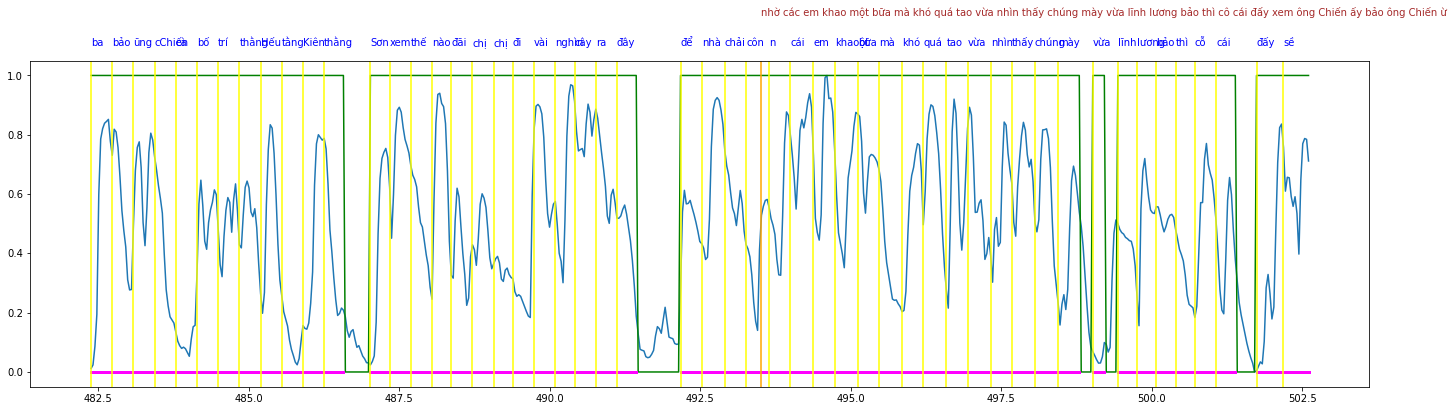

15679 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512, 7518, 7520, 7530, 7539, 7541, 7579, 7582, 8054, 8554, 8949, 8951, 8958, 9319, 9907, 10231, 10234, 10626, 11036, 11038, 11560, 11695, 11697, 11741, 11743, 11797, 11802, 11833, 11835, 11923, 11925, 11928, 11932, 12084, 12087, 12363, 12367, 12827, 13248, 13254, 13656, 13659, 13787, 13795, 13986, 14590, 14817, 14819, 14828, 14831, 14850, 14853, 14950, 14960, 15026, 15031, 15042, 15045, 15052, 15058, 15062, 15066, 15069, 15071, 15075, 15679]
READ_HEAD 15679
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 0: []

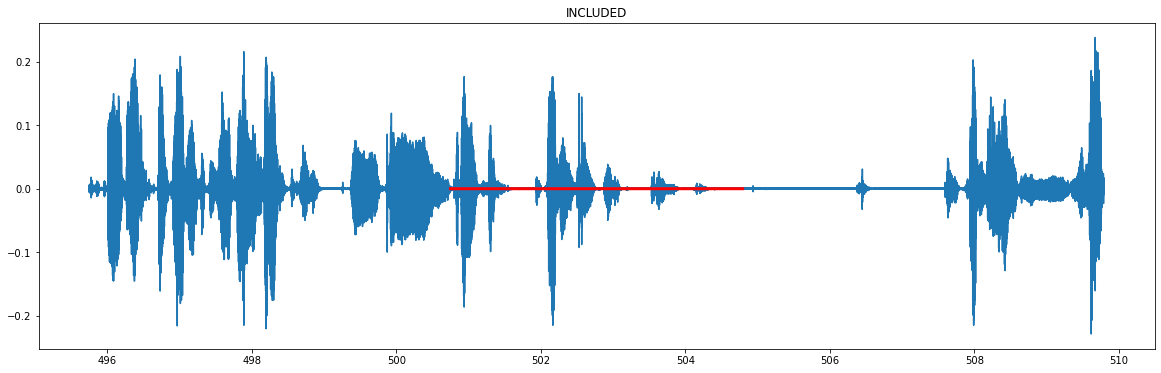

[NeMo I 2020-10-30 12:40:05 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 12:40:05 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |cii đi trin ông Chiến ấy ả bảo ông chiếnừ|


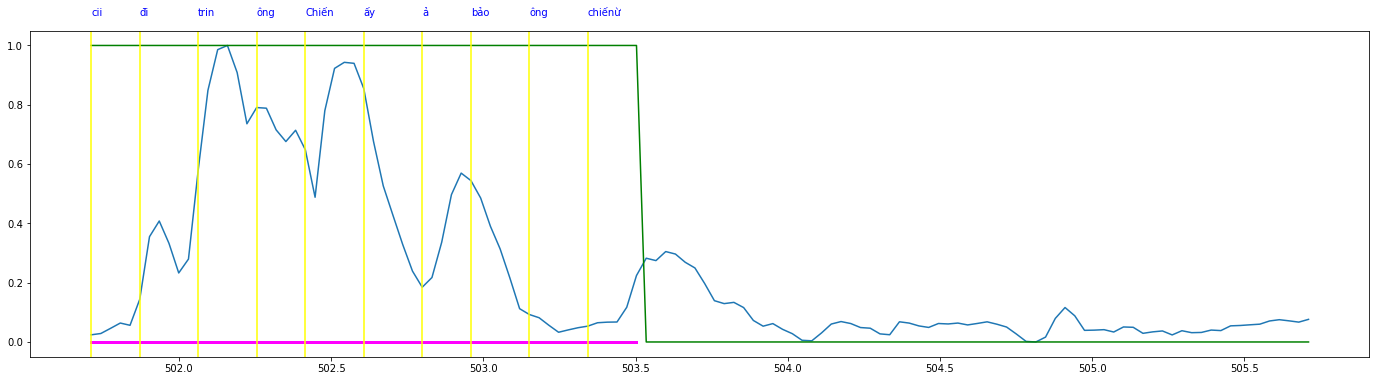

15775 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512, 7518, 7520, 7530, 7539, 7541, 7579, 7582, 8054, 8554, 8949, 8951, 8958, 9319, 9907, 10231, 10234, 10626, 11036, 11038, 11560, 11695, 11697, 11741, 11743, 11797, 11802, 11833, 11835, 11923, 11925, 11928, 11932, 12084, 12087, 12363, 12367, 12827, 13248, 13254, 13656, 13659, 13787, 13795, 13986, 14590, 14817, 14819, 14828, 14831, 14850, 14853, 14950, 14960, 15026, 15031, 15042, 15045, 15052, 15058, 15062, 15066, 15069, 15071, 15075, 15679, 15775]
READ_HEAD 15775
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silence

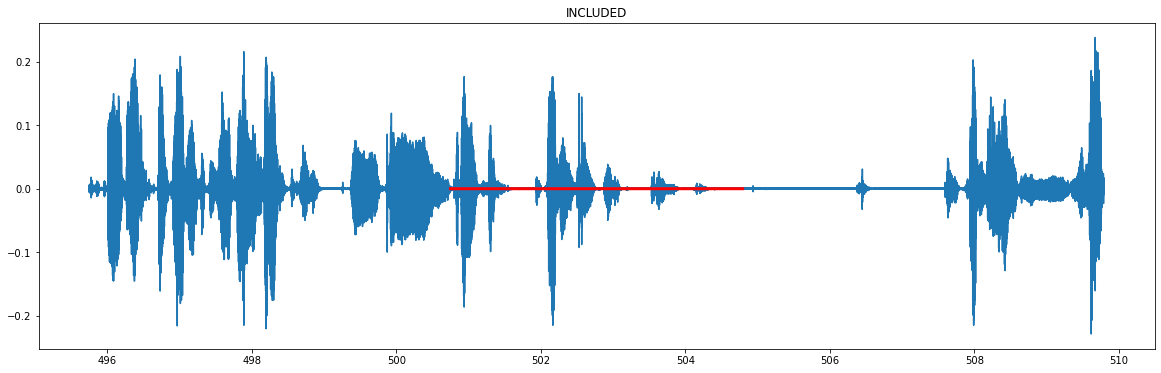

[NeMo I 2020-10-30 12:40:06 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 12:40:06 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |cii đi trin ông Chiến ấy ả bảo ông chiếnừ|


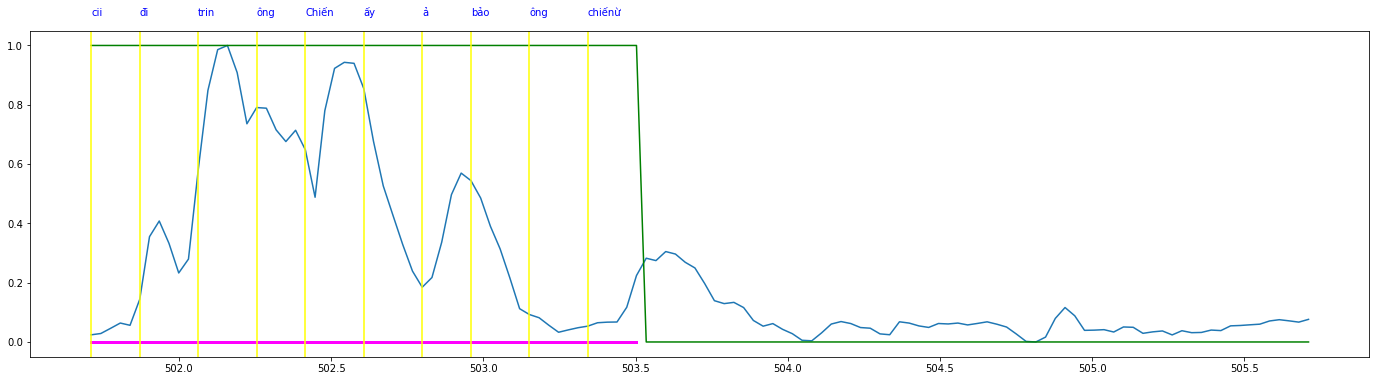

15777 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512, 7518, 7520, 7530, 7539, 7541, 7579, 7582, 8054, 8554, 8949, 8951, 8958, 9319, 9907, 10231, 10234, 10626, 11036, 11038, 11560, 11695, 11697, 11741, 11743, 11797, 11802, 11833, 11835, 11923, 11925, 11928, 11932, 12084, 12087, 12363, 12367, 12827, 13248, 13254, 13656, 13659, 13787, 13795, 13986, 14590, 14817, 14819, 14828, 14831, 14850, 14853, 14950, 14960, 15026, 15031, 15042, 15045, 15052, 15058, 15062, 15066, 15069, 15071, 15075, 15679, 15775, 15777]
READ_HEAD 15777
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #

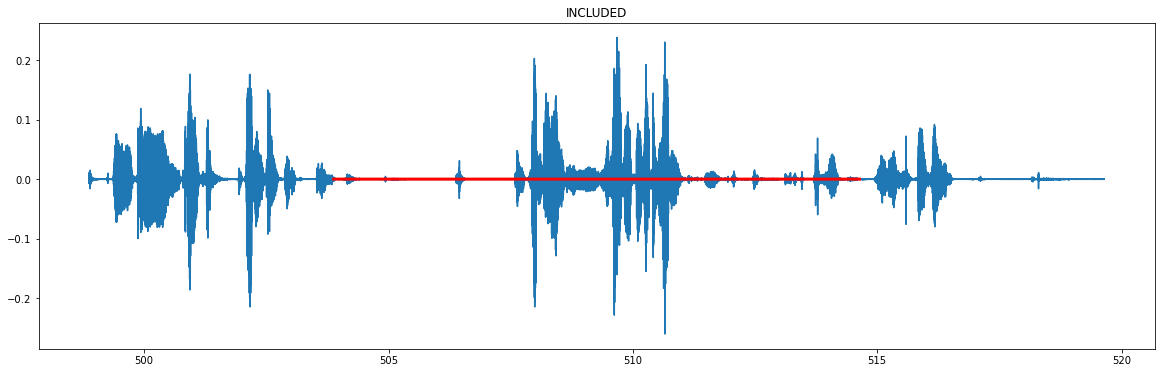

[NeMo I 2020-10-30 12:40:06 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 12:40:06 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |ông thiến bảo là hôm nào bố trí nhà thầy Hiển đấy ầy|


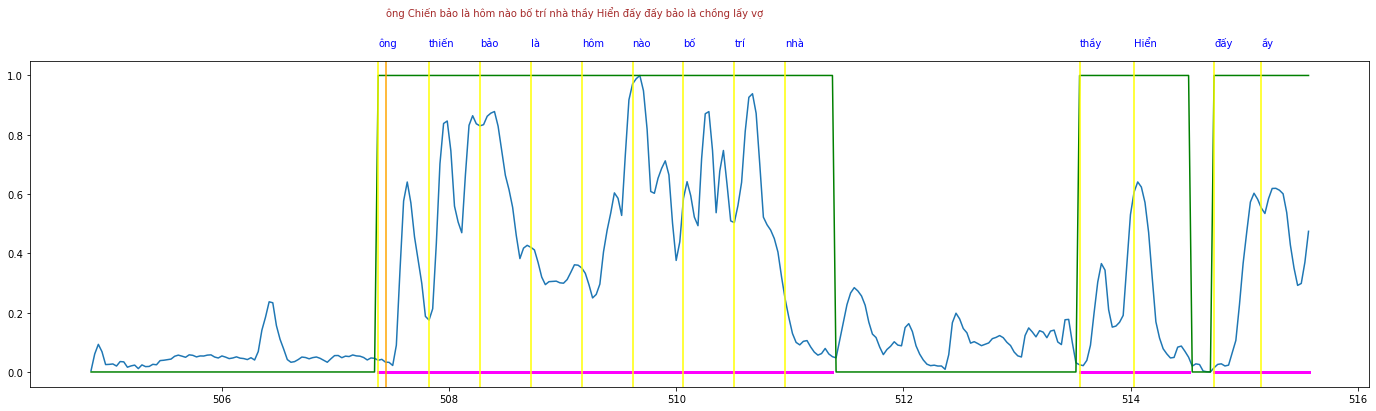

16083 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512, 7518, 7520, 7530, 7539, 7541, 7579, 7582, 8054, 8554, 8949, 8951, 8958, 9319, 9907, 10231, 10234, 10626, 11036, 11038, 11560, 11695, 11697, 11741, 11743, 11797, 11802, 11833, 11835, 11923, 11925, 11928, 11932, 12084, 12087, 12363, 12367, 12827, 13248, 13254, 13656, 13659, 13787, 13795, 13986, 14590, 14817, 14819, 14828, 14831, 14850, 14853, 14950, 14960, 15026, 15031, 15042, 15045, 15052, 15058, 15062, 15066, 15069, 15071, 15075, 15679, 15775, 15777, 16083]
READ_HEAD 16083
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.75376884

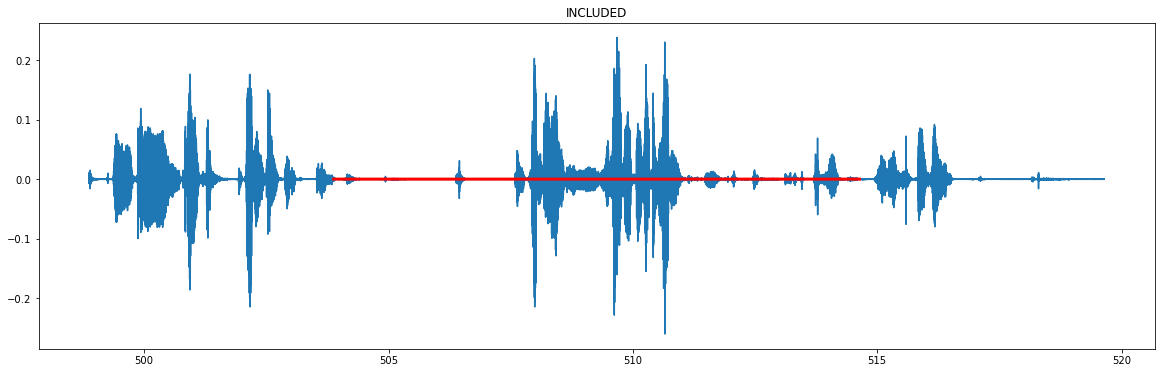

[NeMo I 2020-10-30 12:40:07 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 12:40:07 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |ông Chiến bảo là hôm nào bố trí nhà thầy Hiển đấy ầy|


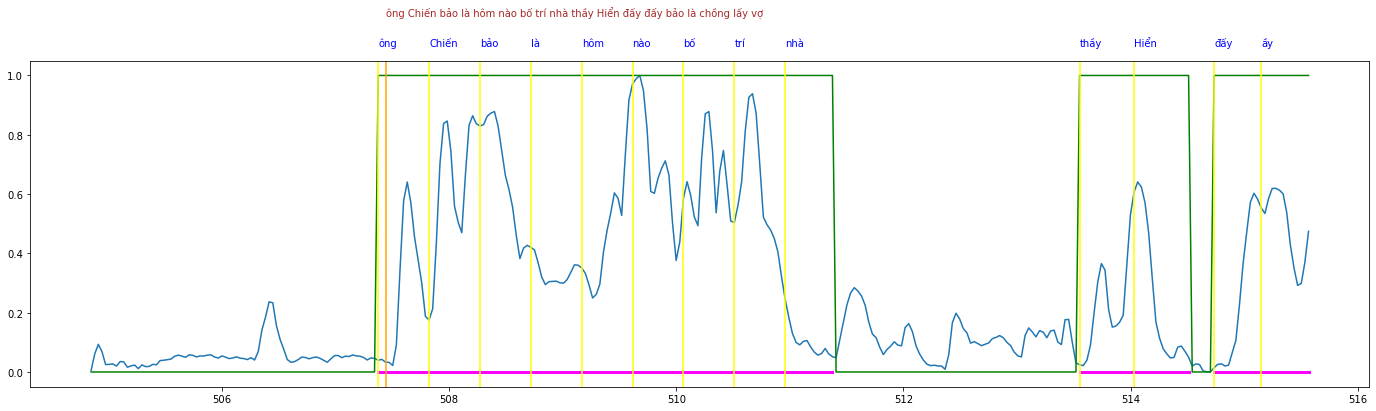

16085 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512, 7518, 7520, 7530, 7539, 7541, 7579, 7582, 8054, 8554, 8949, 8951, 8958, 9319, 9907, 10231, 10234, 10626, 11036, 11038, 11560, 11695, 11697, 11741, 11743, 11797, 11802, 11833, 11835, 11923, 11925, 11928, 11932, 12084, 12087, 12363, 12367, 12827, 13248, 13254, 13656, 13659, 13787, 13795, 13986, 14590, 14817, 14819, 14828, 14831, 14850, 14853, 14950, 14960, 15026, 15031, 15042, 15045, 15052, 15058, 15062, 15066, 15069, 15071, 15075, 15679, 15775, 15777, 16083, 16085]
READ_HEAD 16085
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7

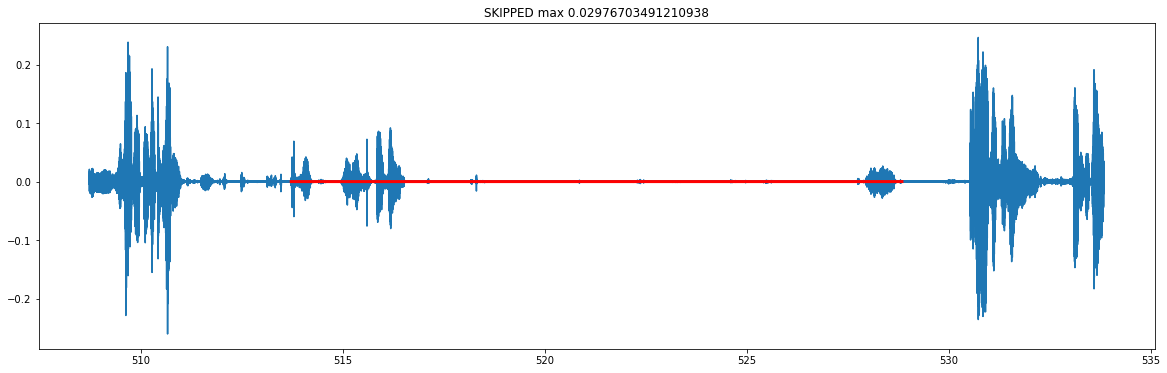

16527 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512, 7518, 7520, 7530, 7539, 7541, 7579, 7582, 8054, 8554, 8949, 8951, 8958, 9319, 9907, 10231, 10234, 10626, 11036, 11038, 11560, 11695, 11697, 11741, 11743, 11797, 11802, 11833, 11835, 11923, 11925, 11928, 11932, 12084, 12087, 12363, 12367, 12827, 13248, 13254, 13656, 13659, 13787, 13795, 13986, 14590, 14817, 14819, 14828, 14831, 14850, 14853, 14950, 14960, 15026, 15031, 15042, 15045, 15052, 15058, 15062, 15066, 15069, 15071, 15075, 15679, 15775, 15777, 16083, 16085, 16527]
READ_HEAD 16527
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutof

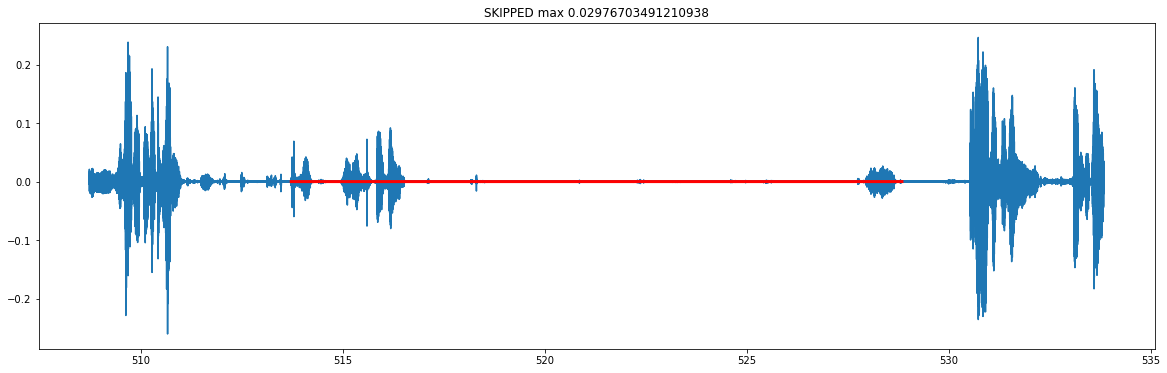

16530 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512, 7518, 7520, 7530, 7539, 7541, 7579, 7582, 8054, 8554, 8949, 8951, 8958, 9319, 9907, 10231, 10234, 10626, 11036, 11038, 11560, 11695, 11697, 11741, 11743, 11797, 11802, 11833, 11835, 11923, 11925, 11928, 11932, 12084, 12087, 12363, 12367, 12827, 13248, 13254, 13656, 13659, 13787, 13795, 13986, 14590, 14817, 14819, 14828, 14831, 14850, 14853, 14950, 14960, 15026, 15031, 15042, 15045, 15052, 15058, 15062, 15066, 15069, 15071, 15075, 15679, 15775, 15777, 16083, 16085, 16527, 16530]
READ_HEAD 16530
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: [

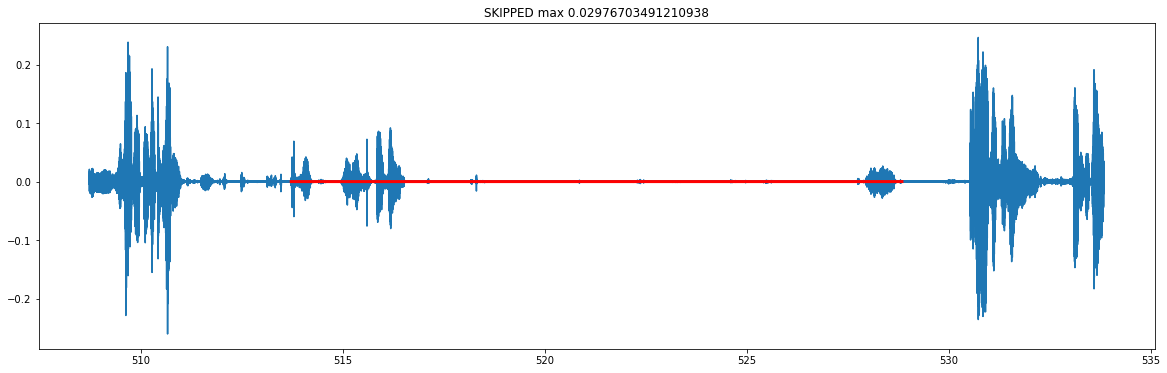

16532 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512, 7518, 7520, 7530, 7539, 7541, 7579, 7582, 8054, 8554, 8949, 8951, 8958, 9319, 9907, 10231, 10234, 10626, 11036, 11038, 11560, 11695, 11697, 11741, 11743, 11797, 11802, 11833, 11835, 11923, 11925, 11928, 11932, 12084, 12087, 12363, 12367, 12827, 13248, 13254, 13656, 13659, 13787, 13795, 13986, 14590, 14817, 14819, 14828, 14831, 14850, 14853, 14950, 14960, 15026, 15031, 15042, 15045, 15052, 15058, 15062, 15066, 15069, 15071, 15075, 15679, 15775, 15777, 16083, 16085, 16527, 16530, 16532]
READ_HEAD 16532
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silenc

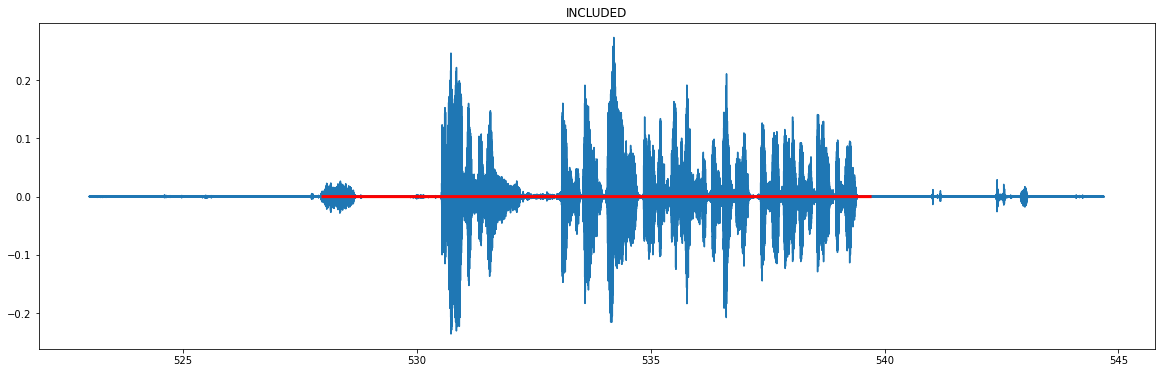

[NeMo I 2020-10-30 12:40:07 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 12:40:07 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |thết đấy em em bảo là sim của cô sao ấy cháu gọi bao lần mà cái sim kia không được thế hôm nay cô dùng dungái số sim nạài|


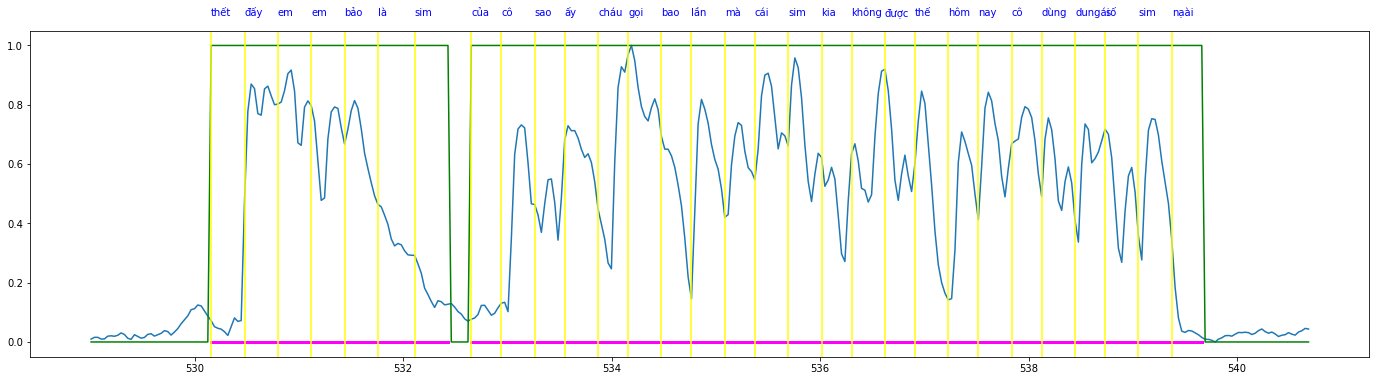

16866 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512, 7518, 7520, 7530, 7539, 7541, 7579, 7582, 8054, 8554, 8949, 8951, 8958, 9319, 9907, 10231, 10234, 10626, 11036, 11038, 11560, 11695, 11697, 11741, 11743, 11797, 11802, 11833, 11835, 11923, 11925, 11928, 11932, 12084, 12087, 12363, 12367, 12827, 13248, 13254, 13656, 13659, 13787, 13795, 13986, 14590, 14817, 14819, 14828, 14831, 14850, 14853, 14950, 14960, 15026, 15031, 15042, 15045, 15052, 15058, 15062, 15066, 15069, 15071, 15075, 15679, 15775, 15777, 16083, 16085, 16527, 16530, 16532, 16866]
READ_HEAD 16866
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 

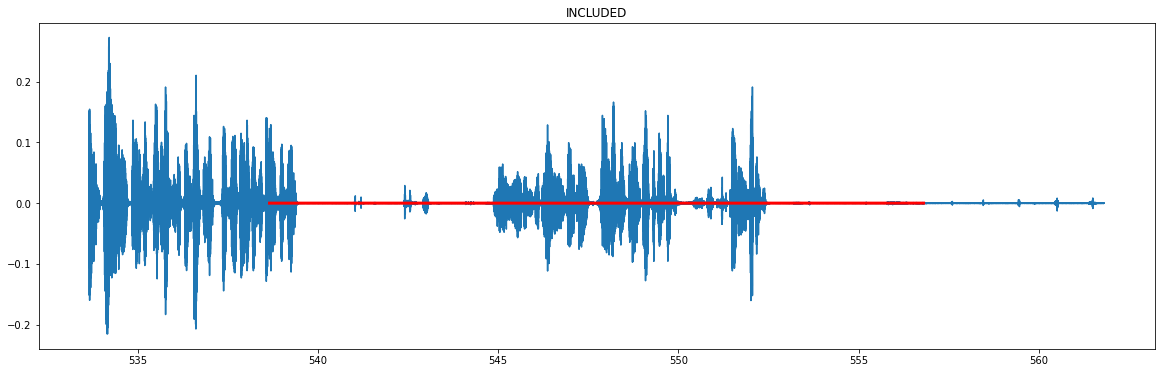

[NeMo I 2020-10-30 12:40:08 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 12:40:08 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |môi tìm mại tể ái đến đợt vừa rồi này lại thấy bà ấy long dong trên đường tái xuất giang hồ thứ đi bốt rổg hôn|


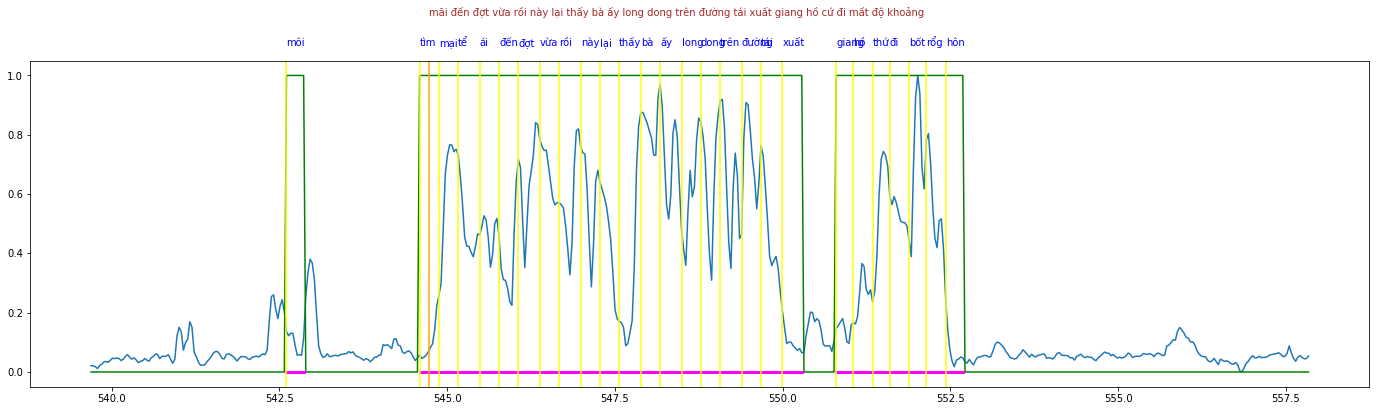

17401 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512, 7518, 7520, 7530, 7539, 7541, 7579, 7582, 8054, 8554, 8949, 8951, 8958, 9319, 9907, 10231, 10234, 10626, 11036, 11038, 11560, 11695, 11697, 11741, 11743, 11797, 11802, 11833, 11835, 11923, 11925, 11928, 11932, 12084, 12087, 12363, 12367, 12827, 13248, 13254, 13656, 13659, 13787, 13795, 13986, 14590, 14817, 14819, 14828, 14831, 14850, 14853, 14950, 14960, 15026, 15031, 15042, 15045, 15052, 15058, 15062, 15066, 15069, 15071, 15075, 15679, 15775, 15777, 16083, 16085, 16527, 16530, 16532, 16866, 17401]
READ_HEAD 17401
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663

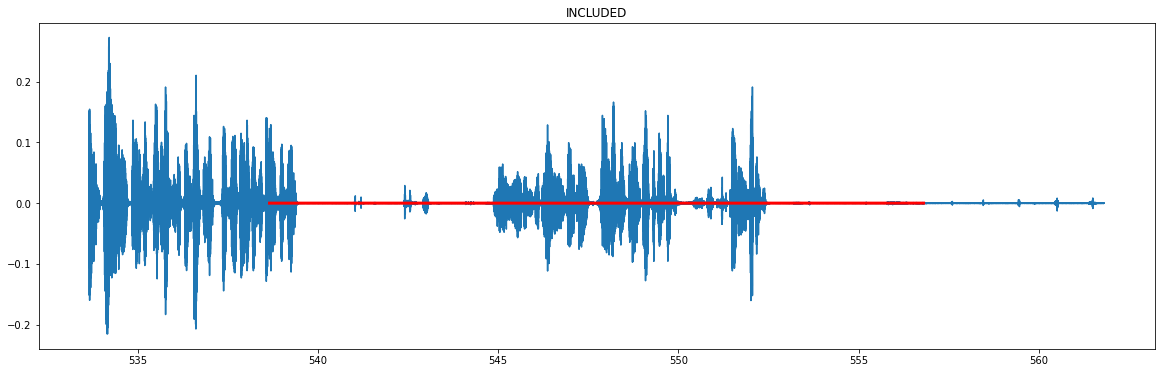

[NeMo I 2020-10-30 12:40:08 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 12:40:08 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |môi tìm mại tể ái đến đợt vừa rồi này lại thấy bà ấy long dong trên đường tái xuất giang hồ thứ đi bốt rổg hôn|


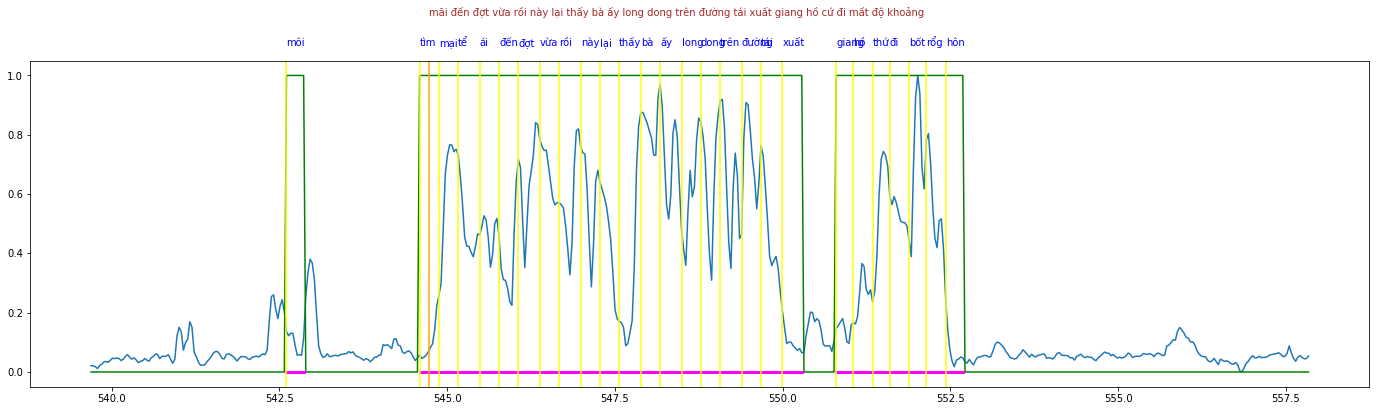

17403 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512, 7518, 7520, 7530, 7539, 7541, 7579, 7582, 8054, 8554, 8949, 8951, 8958, 9319, 9907, 10231, 10234, 10626, 11036, 11038, 11560, 11695, 11697, 11741, 11743, 11797, 11802, 11833, 11835, 11923, 11925, 11928, 11932, 12084, 12087, 12363, 12367, 12827, 13248, 13254, 13656, 13659, 13787, 13795, 13986, 14590, 14817, 14819, 14828, 14831, 14850, 14853, 14950, 14960, 15026, 15031, 15042, 15045, 15052, 15058, 15062, 15066, 15069, 15071, 15075, 15679, 15775, 15777, 16083, 16085, 16527, 16530, 16532, 16866, 17401, 17403]
READ_HEAD 17403
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.0

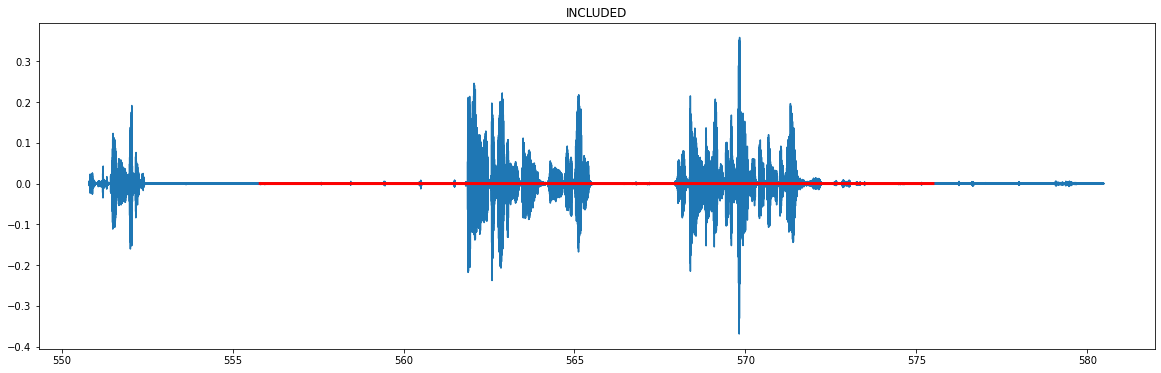

[NeMo I 2020-10-30 12:40:09 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 12:40:09 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |ông thế bải bảo xây nhà bên cầu đấi bnh cầu đầu Quan ấy thế bả xây lâu lắm từ tháng hai mà khởi công từ tháng hai mà|


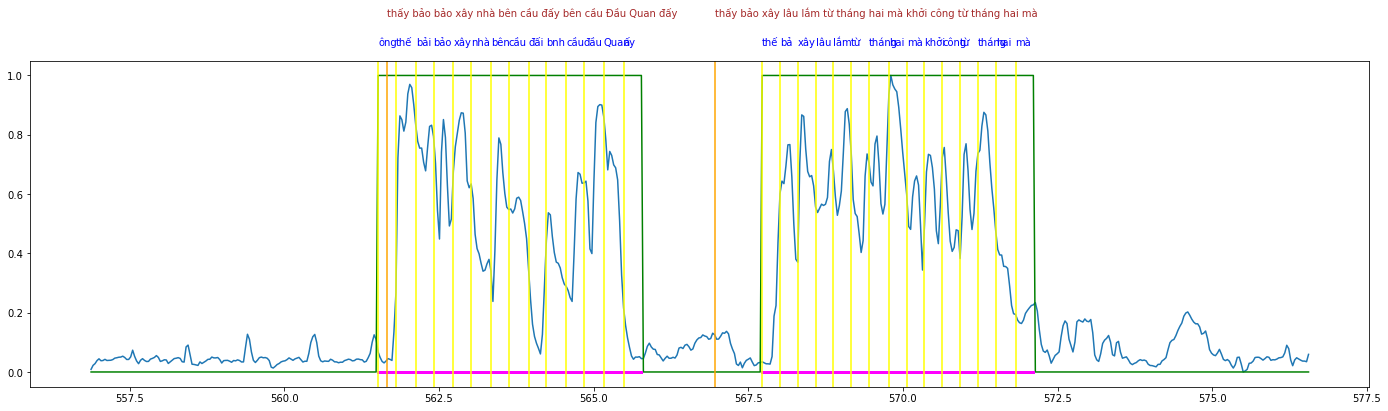

17985 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512, 7518, 7520, 7530, 7539, 7541, 7579, 7582, 8054, 8554, 8949, 8951, 8958, 9319, 9907, 10231, 10234, 10626, 11036, 11038, 11560, 11695, 11697, 11741, 11743, 11797, 11802, 11833, 11835, 11923, 11925, 11928, 11932, 12084, 12087, 12363, 12367, 12827, 13248, 13254, 13656, 13659, 13787, 13795, 13986, 14590, 14817, 14819, 14828, 14831, 14850, 14853, 14950, 14960, 15026, 15031, 15042, 15045, 15052, 15058, 15062, 15066, 15069, 15071, 15075, 15679, 15775, 15777, 16083, 16085, 16527, 16530, 16532, 16866, 17401, 17403, 17985]
READ_HEAD 17985
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutof

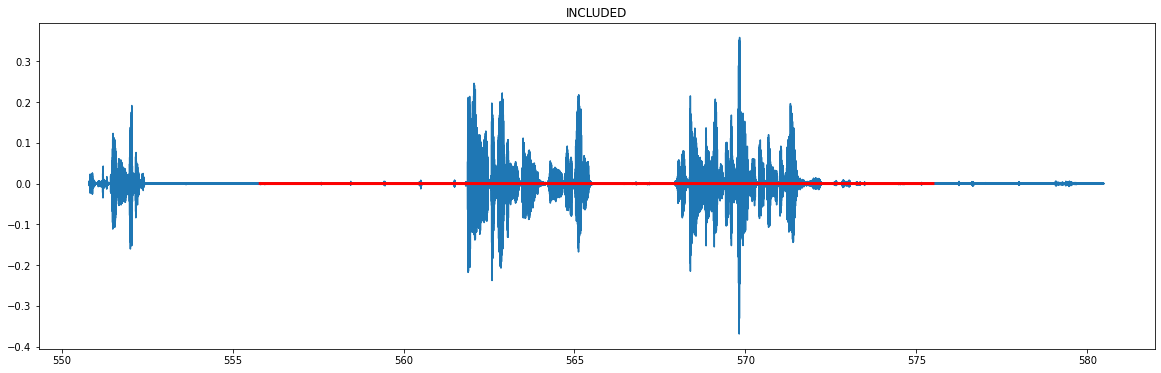

[NeMo I 2020-10-30 12:40:09 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 12:40:09 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |ông thế bải bảo xây nhà rbên cầu đấi bnh cầu đầu Quan ấy thế bả xây lâu lắm từ tháng hai mà khởi công từ tháng hai mà|


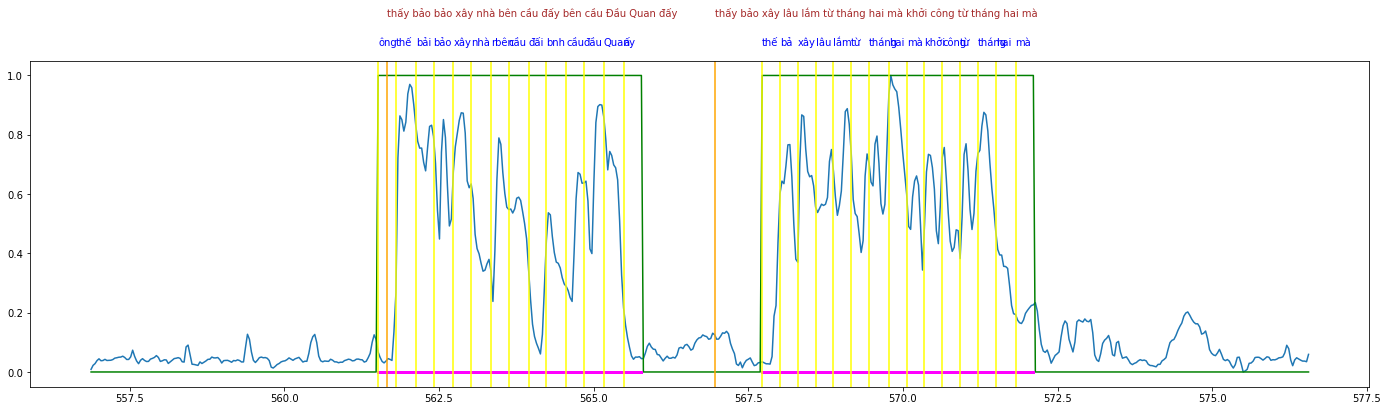

17987 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512, 7518, 7520, 7530, 7539, 7541, 7579, 7582, 8054, 8554, 8949, 8951, 8958, 9319, 9907, 10231, 10234, 10626, 11036, 11038, 11560, 11695, 11697, 11741, 11743, 11797, 11802, 11833, 11835, 11923, 11925, 11928, 11932, 12084, 12087, 12363, 12367, 12827, 13248, 13254, 13656, 13659, 13787, 13795, 13986, 14590, 14817, 14819, 14828, 14831, 14850, 14853, 14950, 14960, 15026, 15031, 15042, 15045, 15052, 15058, 15062, 15066, 15069, 15071, 15075, 15679, 15775, 15777, 16083, 16085, 16527, 16530, 16532, 16866, 17401, 17403, 17985, 17987]
READ_HEAD 17987
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: [

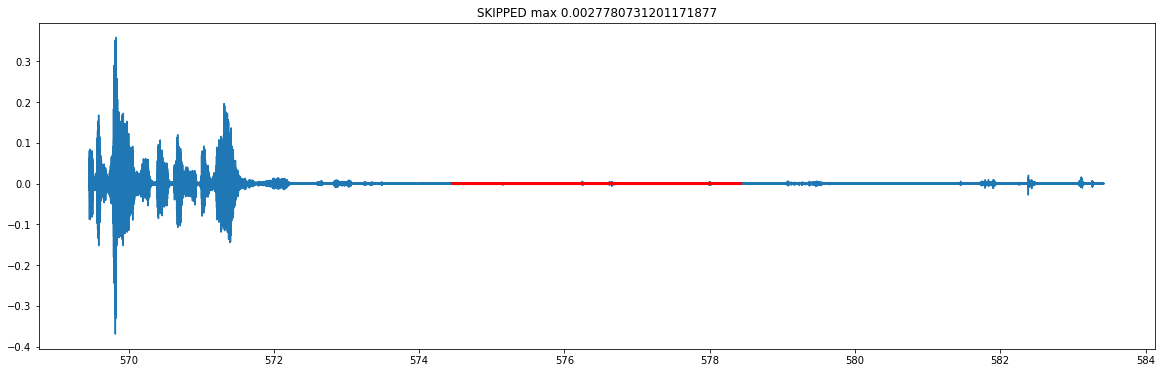

18076 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512, 7518, 7520, 7530, 7539, 7541, 7579, 7582, 8054, 8554, 8949, 8951, 8958, 9319, 9907, 10231, 10234, 10626, 11036, 11038, 11560, 11695, 11697, 11741, 11743, 11797, 11802, 11833, 11835, 11923, 11925, 11928, 11932, 12084, 12087, 12363, 12367, 12827, 13248, 13254, 13656, 13659, 13787, 13795, 13986, 14590, 14817, 14819, 14828, 14831, 14850, 14853, 14950, 14960, 15026, 15031, 15042, 15045, 15052, 15058, 15062, 15066, 15069, 15071, 15075, 15679, 15775, 15777, 16083, 16085, 16527, 16530, 16532, 16866, 17401, 17403, 17985, 17987, 18076]
READ_HEAD 18076
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silenc

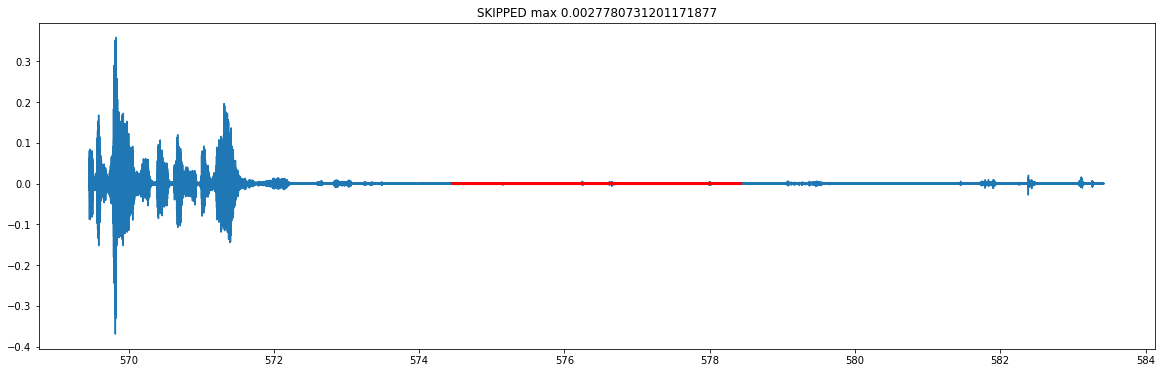

18078 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512, 7518, 7520, 7530, 7539, 7541, 7579, 7582, 8054, 8554, 8949, 8951, 8958, 9319, 9907, 10231, 10234, 10626, 11036, 11038, 11560, 11695, 11697, 11741, 11743, 11797, 11802, 11833, 11835, 11923, 11925, 11928, 11932, 12084, 12087, 12363, 12367, 12827, 13248, 13254, 13656, 13659, 13787, 13795, 13986, 14590, 14817, 14819, 14828, 14831, 14850, 14853, 14950, 14960, 15026, 15031, 15042, 15045, 15052, 15058, 15062, 15066, 15069, 15071, 15075, 15679, 15775, 15777, 16083, 16085, 16527, 16530, 16532, 16866, 17401, 17403, 17985, 17987, 18076, 18078]
READ_HEAD 18078
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 

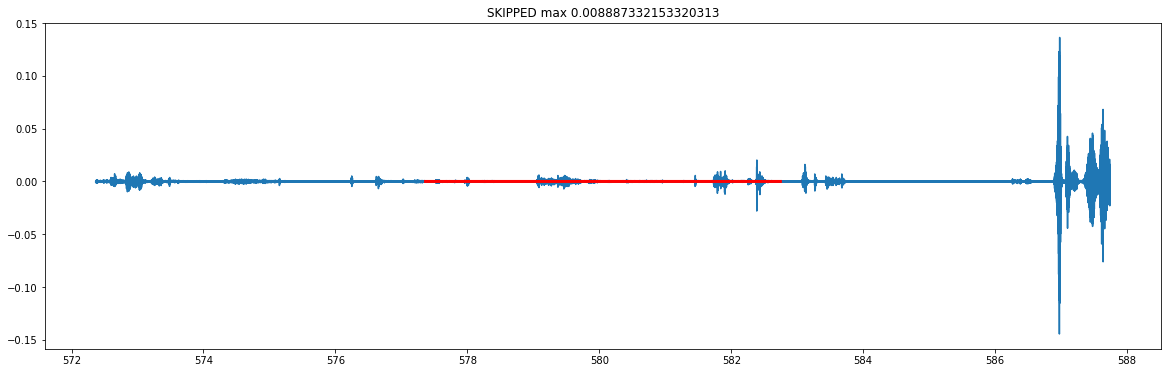

18211 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512, 7518, 7520, 7530, 7539, 7541, 7579, 7582, 8054, 8554, 8949, 8951, 8958, 9319, 9907, 10231, 10234, 10626, 11036, 11038, 11560, 11695, 11697, 11741, 11743, 11797, 11802, 11833, 11835, 11923, 11925, 11928, 11932, 12084, 12087, 12363, 12367, 12827, 13248, 13254, 13656, 13659, 13787, 13795, 13986, 14590, 14817, 14819, 14828, 14831, 14850, 14853, 14950, 14960, 15026, 15031, 15042, 15045, 15052, 15058, 15062, 15066, 15069, 15071, 15075, 15679, 15775, 15777, 16083, 16085, 16527, 16530, 16532, 16866, 17401, 17403, 17985, 17987, 18076, 18078, 18211]
READ_HEAD 18211
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442

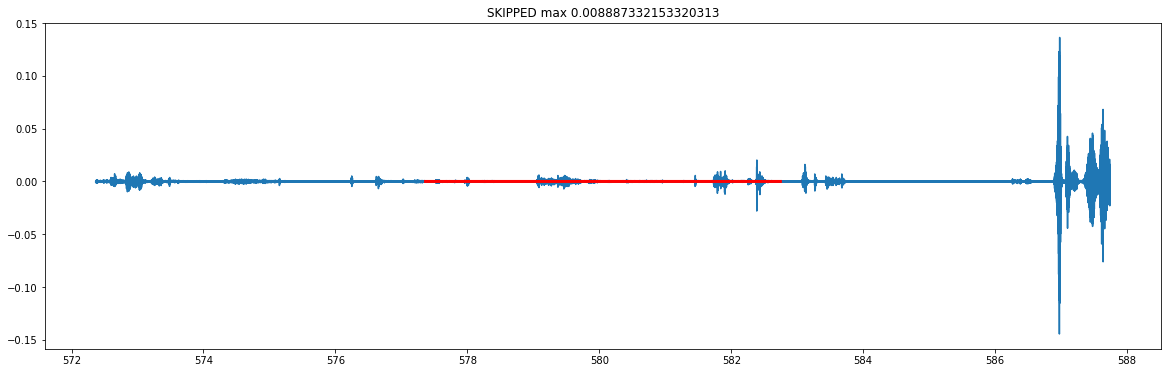

18214 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512, 7518, 7520, 7530, 7539, 7541, 7579, 7582, 8054, 8554, 8949, 8951, 8958, 9319, 9907, 10231, 10234, 10626, 11036, 11038, 11560, 11695, 11697, 11741, 11743, 11797, 11802, 11833, 11835, 11923, 11925, 11928, 11932, 12084, 12087, 12363, 12367, 12827, 13248, 13254, 13656, 13659, 13787, 13795, 13986, 14590, 14817, 14819, 14828, 14831, 14850, 14853, 14950, 14960, 15026, 15031, 15042, 15045, 15052, 15058, 15062, 15066, 15069, 15071, 15075, 15679, 15775, 15777, 16083, 16085, 16527, 16530, 16532, 16866, 17401, 17403, 17985, 17987, 18076, 18078, 18211, 18214]
READ_HEAD 18214
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.3

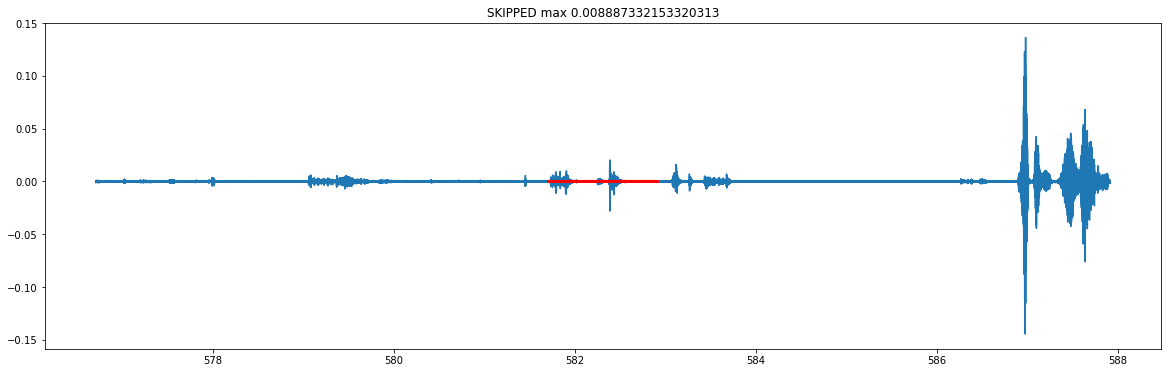

18216 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512, 7518, 7520, 7530, 7539, 7541, 7579, 7582, 8054, 8554, 8949, 8951, 8958, 9319, 9907, 10231, 10234, 10626, 11036, 11038, 11560, 11695, 11697, 11741, 11743, 11797, 11802, 11833, 11835, 11923, 11925, 11928, 11932, 12084, 12087, 12363, 12367, 12827, 13248, 13254, 13656, 13659, 13787, 13795, 13986, 14590, 14817, 14819, 14828, 14831, 14850, 14853, 14950, 14960, 15026, 15031, 15042, 15045, 15052, 15058, 15062, 15066, 15069, 15071, 15075, 15679, 15775, 15777, 16083, 16085, 16527, 16530, 16532, 16866, 17401, 17403, 17985, 17987, 18076, 18078, 18211, 18214, 18216]
READ_HEAD 18216
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutof

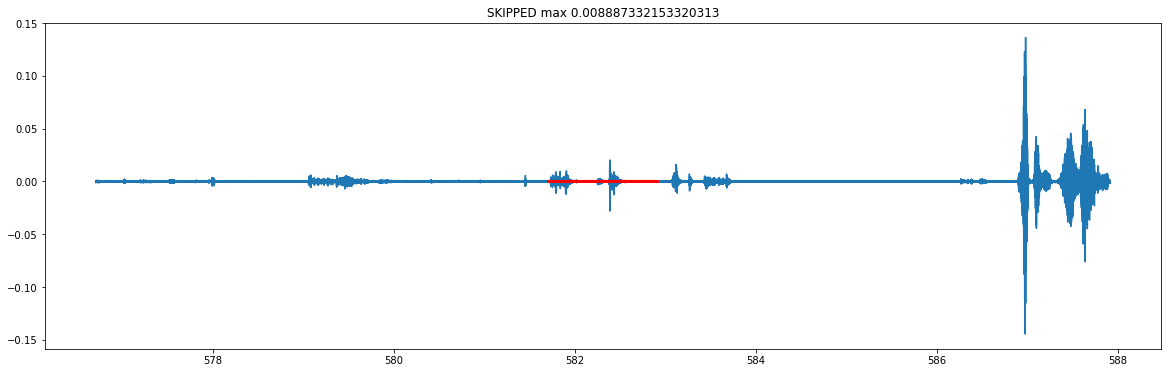

18218 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512, 7518, 7520, 7530, 7539, 7541, 7579, 7582, 8054, 8554, 8949, 8951, 8958, 9319, 9907, 10231, 10234, 10626, 11036, 11038, 11560, 11695, 11697, 11741, 11743, 11797, 11802, 11833, 11835, 11923, 11925, 11928, 11932, 12084, 12087, 12363, 12367, 12827, 13248, 13254, 13656, 13659, 13787, 13795, 13986, 14590, 14817, 14819, 14828, 14831, 14850, 14853, 14950, 14960, 15026, 15031, 15042, 15045, 15052, 15058, 15062, 15066, 15069, 15071, 15075, 15679, 15775, 15777, 16083, 16085, 16527, 16530, 16532, 16866, 17401, 17403, 17985, 17987, 18076, 18078, 18211, 18214, 18216, 18218]
READ_HEAD 18218
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: [

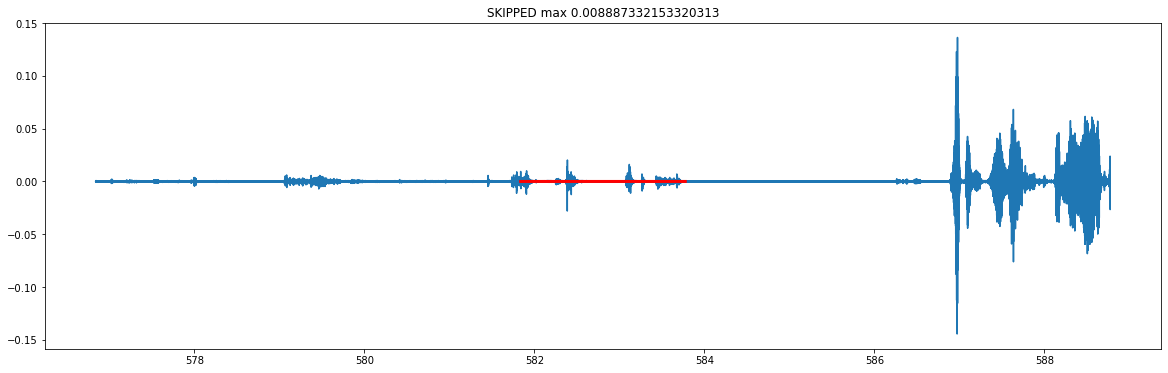

18243 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512, 7518, 7520, 7530, 7539, 7541, 7579, 7582, 8054, 8554, 8949, 8951, 8958, 9319, 9907, 10231, 10234, 10626, 11036, 11038, 11560, 11695, 11697, 11741, 11743, 11797, 11802, 11833, 11835, 11923, 11925, 11928, 11932, 12084, 12087, 12363, 12367, 12827, 13248, 13254, 13656, 13659, 13787, 13795, 13986, 14590, 14817, 14819, 14828, 14831, 14850, 14853, 14950, 14960, 15026, 15031, 15042, 15045, 15052, 15058, 15062, 15066, 15069, 15071, 15075, 15679, 15775, 15777, 16083, 16085, 16527, 16530, 16532, 16866, 17401, 17403, 17985, 17987, 18076, 18078, 18211, 18214, 18216, 18218, 18243]
READ_HEAD 18243
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silenc

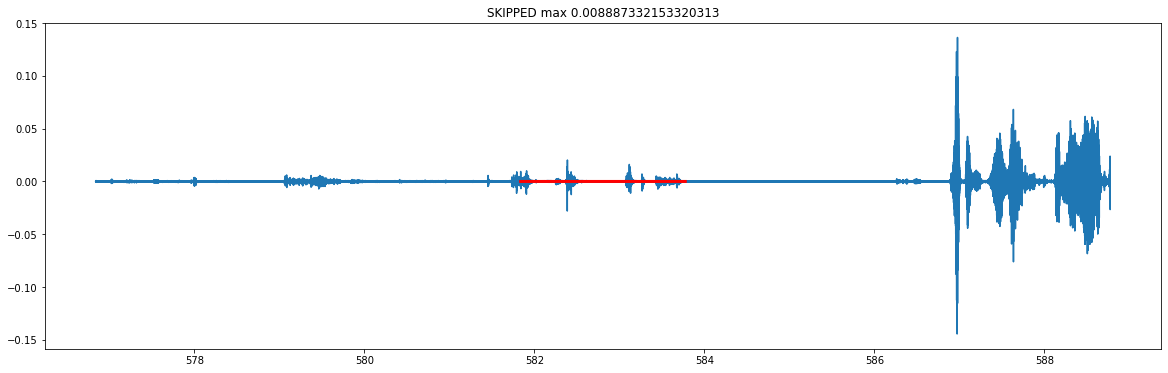

18246 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512, 7518, 7520, 7530, 7539, 7541, 7579, 7582, 8054, 8554, 8949, 8951, 8958, 9319, 9907, 10231, 10234, 10626, 11036, 11038, 11560, 11695, 11697, 11741, 11743, 11797, 11802, 11833, 11835, 11923, 11925, 11928, 11932, 12084, 12087, 12363, 12367, 12827, 13248, 13254, 13656, 13659, 13787, 13795, 13986, 14590, 14817, 14819, 14828, 14831, 14850, 14853, 14950, 14960, 15026, 15031, 15042, 15045, 15052, 15058, 15062, 15066, 15069, 15071, 15075, 15679, 15775, 15777, 16083, 16085, 16527, 16530, 16532, 16866, 17401, 17403, 17985, 17987, 18076, 18078, 18211, 18214, 18216, 18218, 18243, 18246]
READ_HEAD 18246
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 

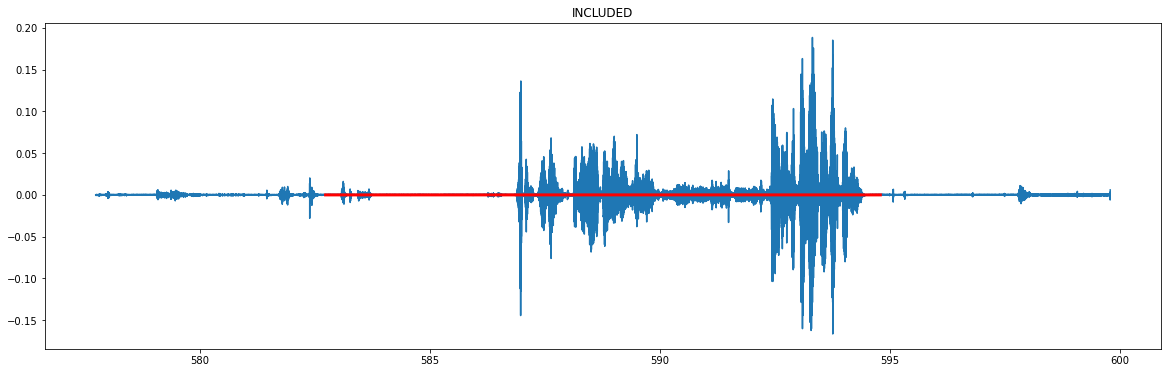

[NeMo I 2020-10-30 12:40:11 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 12:40:11 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |muần thì ciết đi đợn lần này á hấy bà em bảo là thấy bảo là xây nhà thừ khôm nai chín với|


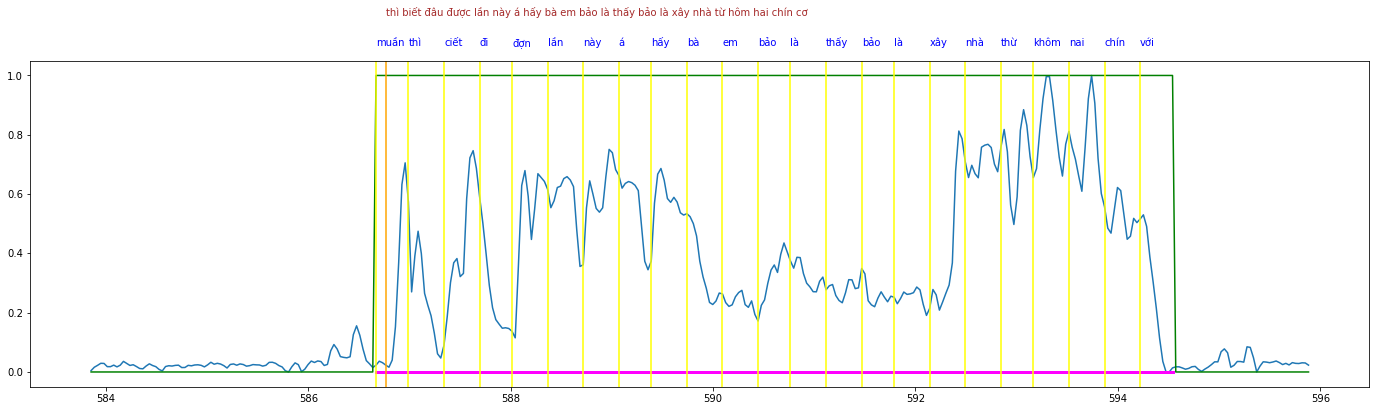

18588 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512, 7518, 7520, 7530, 7539, 7541, 7579, 7582, 8054, 8554, 8949, 8951, 8958, 9319, 9907, 10231, 10234, 10626, 11036, 11038, 11560, 11695, 11697, 11741, 11743, 11797, 11802, 11833, 11835, 11923, 11925, 11928, 11932, 12084, 12087, 12363, 12367, 12827, 13248, 13254, 13656, 13659, 13787, 13795, 13986, 14590, 14817, 14819, 14828, 14831, 14850, 14853, 14950, 14960, 15026, 15031, 15042, 15045, 15052, 15058, 15062, 15066, 15069, 15071, 15075, 15679, 15775, 15777, 16083, 16085, 16527, 16530, 16532, 16866, 17401, 17403, 17985, 17987, 18076, 18078, 18211, 18214, 18216, 18218, 18243, 18246, 18588]
READ_HEAD 18588
cutoff -80.0 #silences 0: []
cutoff -79.68844221

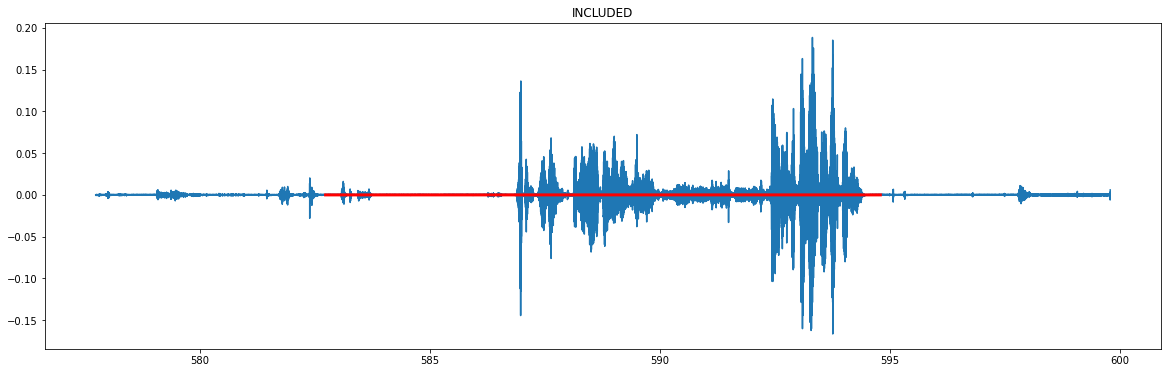

[NeMo I 2020-10-30 12:40:11 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 12:40:11 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |muần thì ciết đi đợn lần này á hấy bà em bảo là thấy bảo là xây nhà thừ khôm nai chín với|


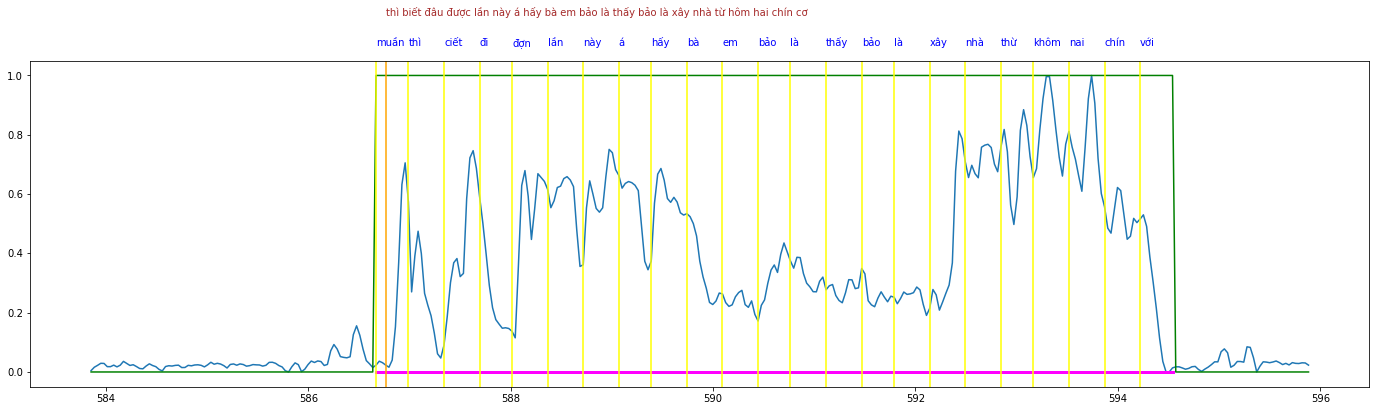

18590 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512, 7518, 7520, 7530, 7539, 7541, 7579, 7582, 8054, 8554, 8949, 8951, 8958, 9319, 9907, 10231, 10234, 10626, 11036, 11038, 11560, 11695, 11697, 11741, 11743, 11797, 11802, 11833, 11835, 11923, 11925, 11928, 11932, 12084, 12087, 12363, 12367, 12827, 13248, 13254, 13656, 13659, 13787, 13795, 13986, 14590, 14817, 14819, 14828, 14831, 14850, 14853, 14950, 14960, 15026, 15031, 15042, 15045, 15052, 15058, 15062, 15066, 15069, 15071, 15075, 15679, 15775, 15777, 16083, 16085, 16527, 16530, 16532, 16866, 17401, 17403, 17985, 17987, 18076, 18078, 18211, 18214, 18216, 18218, 18243, 18246, 18588, 18590]
READ_HEAD 18590
cutoff -80.0 #silences 0: []
cutoff -79.6

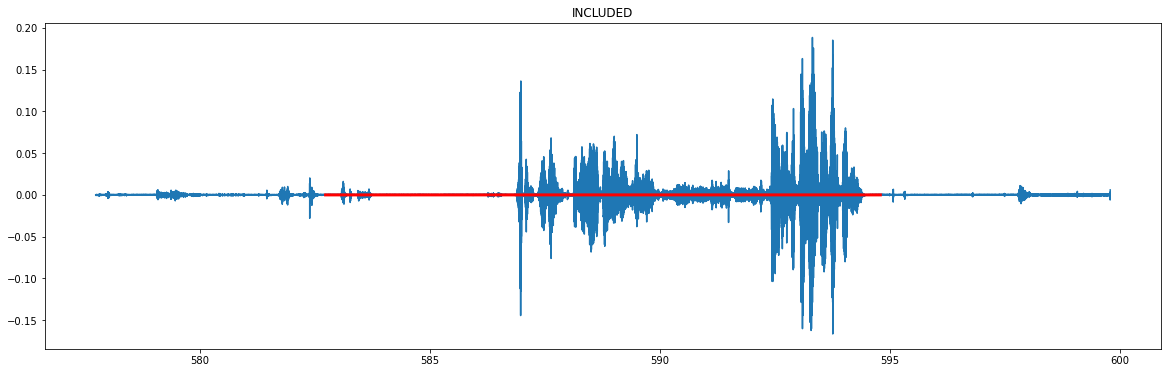

[NeMo I 2020-10-30 12:40:11 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 12:40:11 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |quần thì ciết đi đợn lần này á hấy bà em bảo là thấy bảo là xây nhà thừ khôm nai chín với|


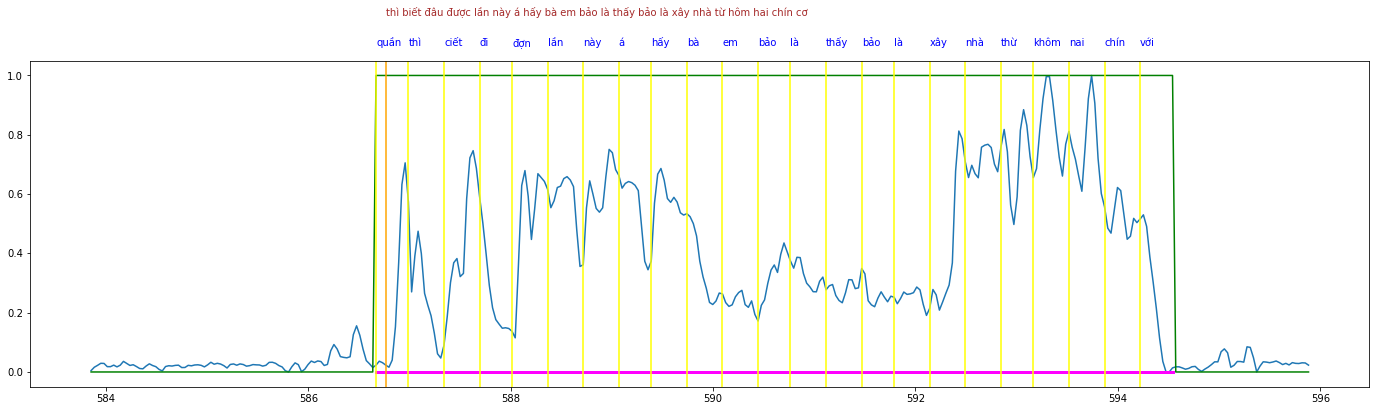

18592 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512, 7518, 7520, 7530, 7539, 7541, 7579, 7582, 8054, 8554, 8949, 8951, 8958, 9319, 9907, 10231, 10234, 10626, 11036, 11038, 11560, 11695, 11697, 11741, 11743, 11797, 11802, 11833, 11835, 11923, 11925, 11928, 11932, 12084, 12087, 12363, 12367, 12827, 13248, 13254, 13656, 13659, 13787, 13795, 13986, 14590, 14817, 14819, 14828, 14831, 14850, 14853, 14950, 14960, 15026, 15031, 15042, 15045, 15052, 15058, 15062, 15066, 15069, 15071, 15075, 15679, 15775, 15777, 16083, 16085, 16527, 16530, 16532, 16866, 17401, 17403, 17985, 17987, 18076, 18078, 18211, 18214, 18216, 18218, 18243, 18246, 18588, 18590, 18592]
READ_HEAD 18592
cutoff -80.0 #silences 0: []
cutof

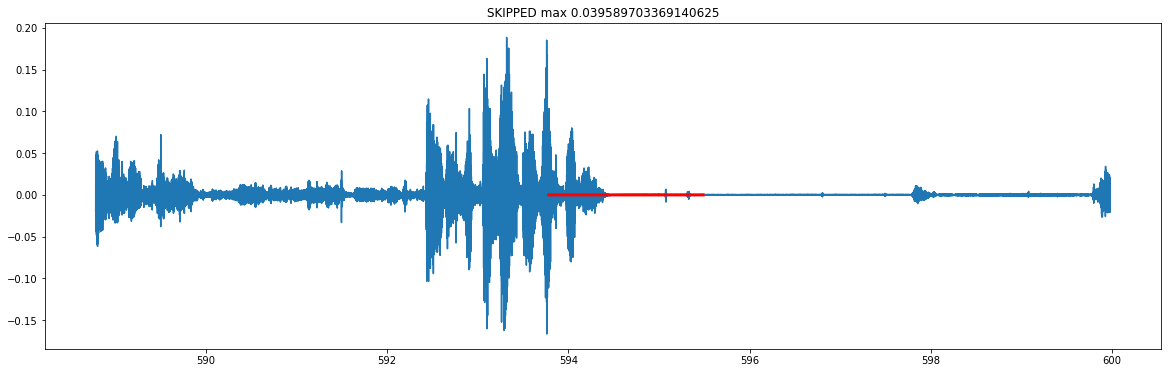

18609 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512, 7518, 7520, 7530, 7539, 7541, 7579, 7582, 8054, 8554, 8949, 8951, 8958, 9319, 9907, 10231, 10234, 10626, 11036, 11038, 11560, 11695, 11697, 11741, 11743, 11797, 11802, 11833, 11835, 11923, 11925, 11928, 11932, 12084, 12087, 12363, 12367, 12827, 13248, 13254, 13656, 13659, 13787, 13795, 13986, 14590, 14817, 14819, 14828, 14831, 14850, 14853, 14950, 14960, 15026, 15031, 15042, 15045, 15052, 15058, 15062, 15066, 15069, 15071, 15075, 15679, 15775, 15777, 16083, 16085, 16527, 16530, 16532, 16866, 17401, 17403, 17985, 17987, 18076, 18078, 18211, 18214, 18216, 18218, 18243, 18246, 18588, 18590, 18592, 18609]
READ_HEAD 18609
cutoff -80.0 #silences 0: [

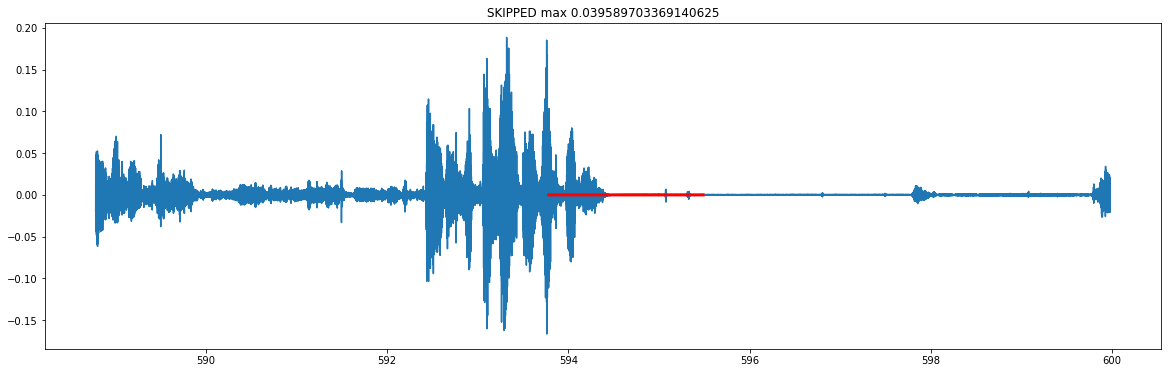

18611 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512, 7518, 7520, 7530, 7539, 7541, 7579, 7582, 8054, 8554, 8949, 8951, 8958, 9319, 9907, 10231, 10234, 10626, 11036, 11038, 11560, 11695, 11697, 11741, 11743, 11797, 11802, 11833, 11835, 11923, 11925, 11928, 11932, 12084, 12087, 12363, 12367, 12827, 13248, 13254, 13656, 13659, 13787, 13795, 13986, 14590, 14817, 14819, 14828, 14831, 14850, 14853, 14950, 14960, 15026, 15031, 15042, 15045, 15052, 15058, 15062, 15066, 15069, 15071, 15075, 15679, 15775, 15777, 16083, 16085, 16527, 16530, 16532, 16866, 17401, 17403, 17985, 17987, 18076, 18078, 18211, 18214, 18216, 18218, 18243, 18246, 18588, 18590, 18592, 18609, 18611]
READ_HEAD 18611
cutoff -80.0 #silenc

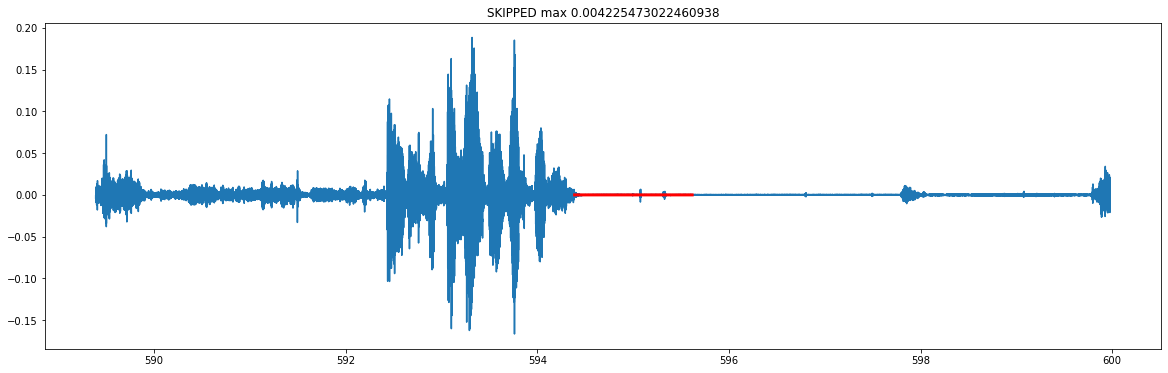

18613 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512, 7518, 7520, 7530, 7539, 7541, 7579, 7582, 8054, 8554, 8949, 8951, 8958, 9319, 9907, 10231, 10234, 10626, 11036, 11038, 11560, 11695, 11697, 11741, 11743, 11797, 11802, 11833, 11835, 11923, 11925, 11928, 11932, 12084, 12087, 12363, 12367, 12827, 13248, 13254, 13656, 13659, 13787, 13795, 13986, 14590, 14817, 14819, 14828, 14831, 14850, 14853, 14950, 14960, 15026, 15031, 15042, 15045, 15052, 15058, 15062, 15066, 15069, 15071, 15075, 15679, 15775, 15777, 16083, 16085, 16527, 16530, 16532, 16866, 17401, 17403, 17985, 17987, 18076, 18078, 18211, 18214, 18216, 18218, 18243, 18246, 18588, 18590, 18592, 18609, 18611, 18613]
READ_HEAD 18613
cutoff -80.0 

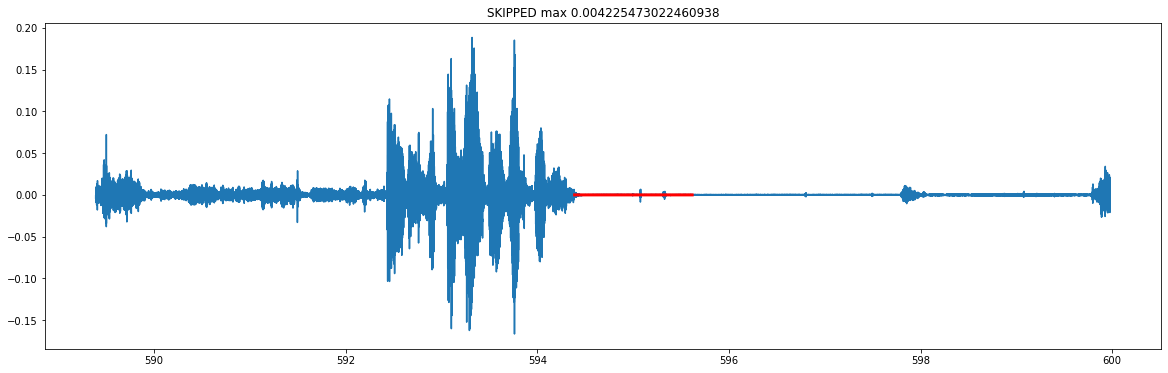

18623 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512, 7518, 7520, 7530, 7539, 7541, 7579, 7582, 8054, 8554, 8949, 8951, 8958, 9319, 9907, 10231, 10234, 10626, 11036, 11038, 11560, 11695, 11697, 11741, 11743, 11797, 11802, 11833, 11835, 11923, 11925, 11928, 11932, 12084, 12087, 12363, 12367, 12827, 13248, 13254, 13656, 13659, 13787, 13795, 13986, 14590, 14817, 14819, 14828, 14831, 14850, 14853, 14950, 14960, 15026, 15031, 15042, 15045, 15052, 15058, 15062, 15066, 15069, 15071, 15075, 15679, 15775, 15777, 16083, 16085, 16527, 16530, 16532, 16866, 17401, 17403, 17985, 17987, 18076, 18078, 18211, 18214, 18216, 18218, 18243, 18246, 18588, 18590, 18592, 18609, 18611, 18613, 18623]
READ_HEAD 18623
cutoff

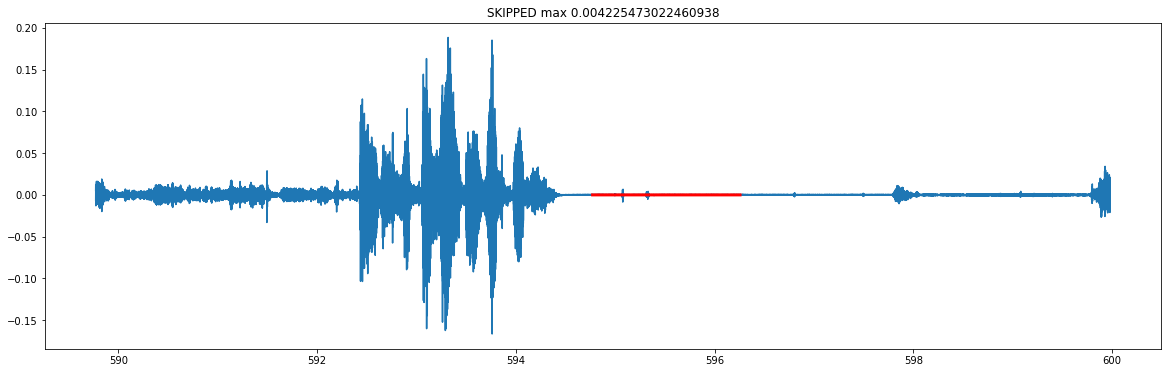

18633 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512, 7518, 7520, 7530, 7539, 7541, 7579, 7582, 8054, 8554, 8949, 8951, 8958, 9319, 9907, 10231, 10234, 10626, 11036, 11038, 11560, 11695, 11697, 11741, 11743, 11797, 11802, 11833, 11835, 11923, 11925, 11928, 11932, 12084, 12087, 12363, 12367, 12827, 13248, 13254, 13656, 13659, 13787, 13795, 13986, 14590, 14817, 14819, 14828, 14831, 14850, 14853, 14950, 14960, 15026, 15031, 15042, 15045, 15052, 15058, 15062, 15066, 15069, 15071, 15075, 15679, 15775, 15777, 16083, 16085, 16527, 16530, 16532, 16866, 17401, 17403, 17985, 17987, 18076, 18078, 18211, 18214, 18216, 18218, 18243, 18246, 18588, 18590, 18592, 18609, 18611, 18613, 18623, 18633]
READ_HEAD 18633

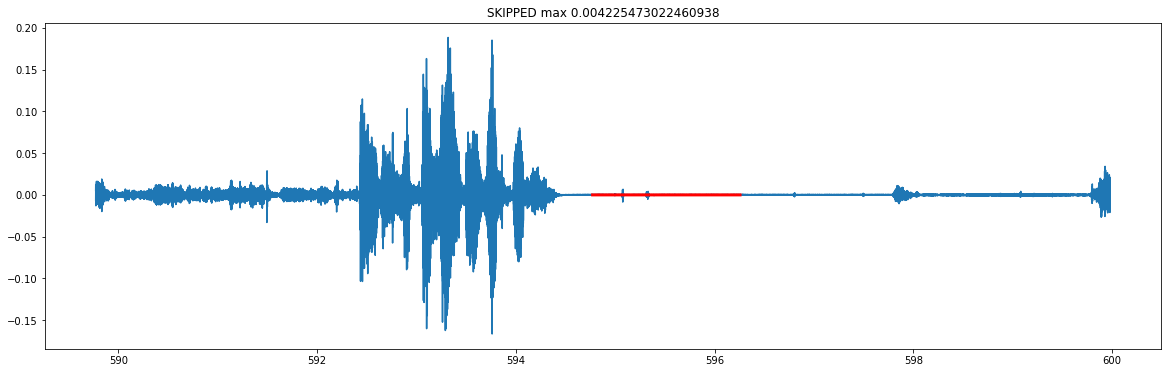

18641 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512, 7518, 7520, 7530, 7539, 7541, 7579, 7582, 8054, 8554, 8949, 8951, 8958, 9319, 9907, 10231, 10234, 10626, 11036, 11038, 11560, 11695, 11697, 11741, 11743, 11797, 11802, 11833, 11835, 11923, 11925, 11928, 11932, 12084, 12087, 12363, 12367, 12827, 13248, 13254, 13656, 13659, 13787, 13795, 13986, 14590, 14817, 14819, 14828, 14831, 14850, 14853, 14950, 14960, 15026, 15031, 15042, 15045, 15052, 15058, 15062, 15066, 15069, 15071, 15075, 15679, 15775, 15777, 16083, 16085, 16527, 16530, 16532, 16866, 17401, 17403, 17985, 17987, 18076, 18078, 18211, 18214, 18216, 18218, 18243, 18246, 18588, 18590, 18592, 18609, 18611, 18613, 18623, 18633, 18641]
READ_HEA

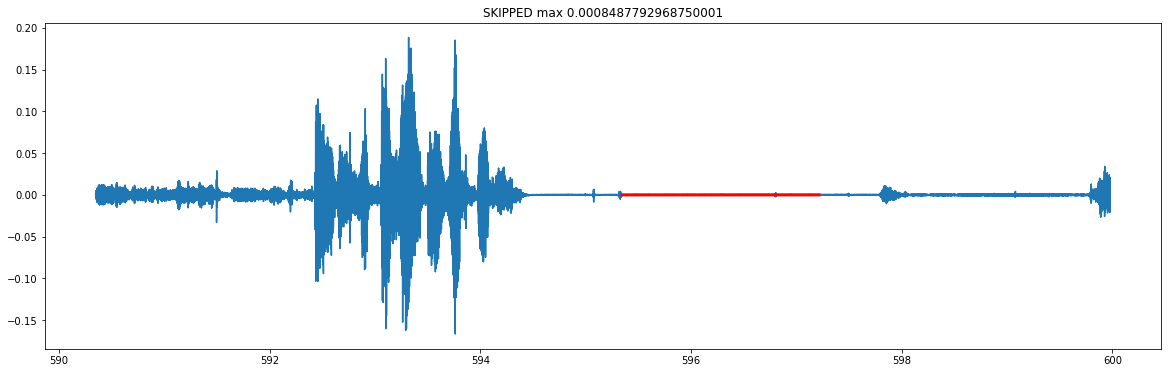

18663 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512, 7518, 7520, 7530, 7539, 7541, 7579, 7582, 8054, 8554, 8949, 8951, 8958, 9319, 9907, 10231, 10234, 10626, 11036, 11038, 11560, 11695, 11697, 11741, 11743, 11797, 11802, 11833, 11835, 11923, 11925, 11928, 11932, 12084, 12087, 12363, 12367, 12827, 13248, 13254, 13656, 13659, 13787, 13795, 13986, 14590, 14817, 14819, 14828, 14831, 14850, 14853, 14950, 14960, 15026, 15031, 15042, 15045, 15052, 15058, 15062, 15066, 15069, 15071, 15075, 15679, 15775, 15777, 16083, 16085, 16527, 16530, 16532, 16866, 17401, 17403, 17985, 17987, 18076, 18078, 18211, 18214, 18216, 18218, 18243, 18246, 18588, 18590, 18592, 18609, 18611, 18613, 18623, 18633, 18641, 18663]
R

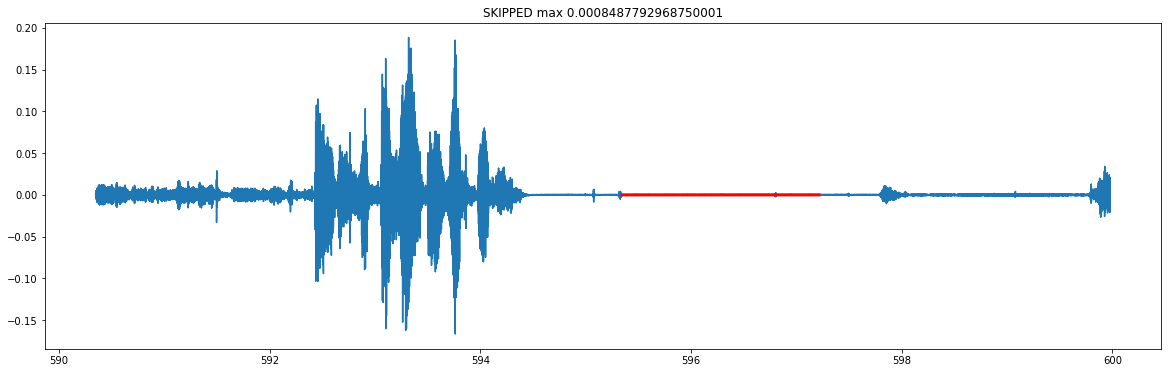

18665 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512, 7518, 7520, 7530, 7539, 7541, 7579, 7582, 8054, 8554, 8949, 8951, 8958, 9319, 9907, 10231, 10234, 10626, 11036, 11038, 11560, 11695, 11697, 11741, 11743, 11797, 11802, 11833, 11835, 11923, 11925, 11928, 11932, 12084, 12087, 12363, 12367, 12827, 13248, 13254, 13656, 13659, 13787, 13795, 13986, 14590, 14817, 14819, 14828, 14831, 14850, 14853, 14950, 14960, 15026, 15031, 15042, 15045, 15052, 15058, 15062, 15066, 15069, 15071, 15075, 15679, 15775, 15777, 16083, 16085, 16527, 16530, 16532, 16866, 17401, 17403, 17985, 17987, 18076, 18078, 18211, 18214, 18216, 18218, 18243, 18246, 18588, 18590, 18592, 18609, 18611, 18613, 18623, 18633, 18641, 18663, 1

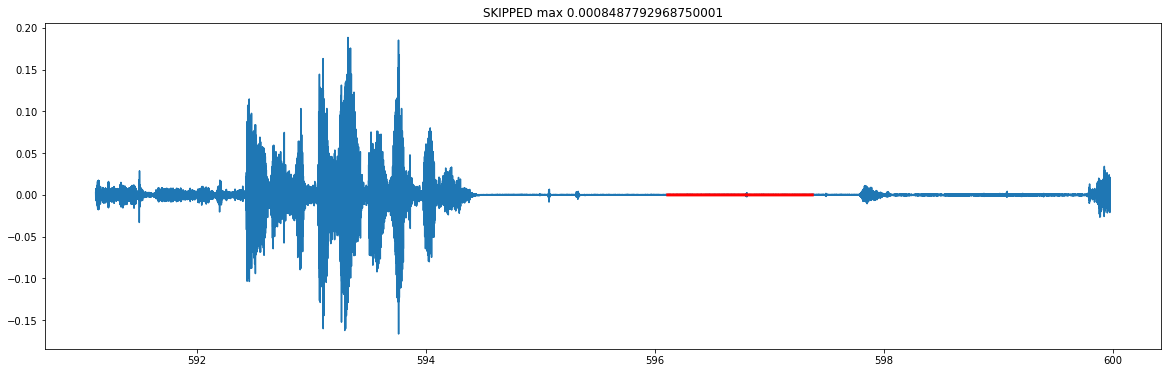

18668 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512, 7518, 7520, 7530, 7539, 7541, 7579, 7582, 8054, 8554, 8949, 8951, 8958, 9319, 9907, 10231, 10234, 10626, 11036, 11038, 11560, 11695, 11697, 11741, 11743, 11797, 11802, 11833, 11835, 11923, 11925, 11928, 11932, 12084, 12087, 12363, 12367, 12827, 13248, 13254, 13656, 13659, 13787, 13795, 13986, 14590, 14817, 14819, 14828, 14831, 14850, 14853, 14950, 14960, 15026, 15031, 15042, 15045, 15052, 15058, 15062, 15066, 15069, 15071, 15075, 15679, 15775, 15777, 16083, 16085, 16527, 16530, 16532, 16866, 17401, 17403, 17985, 17987, 18076, 18078, 18211, 18214, 18216, 18218, 18243, 18246, 18588, 18590, 18592, 18609, 18611, 18613, 18623, 18633, 18641, 18663, 1

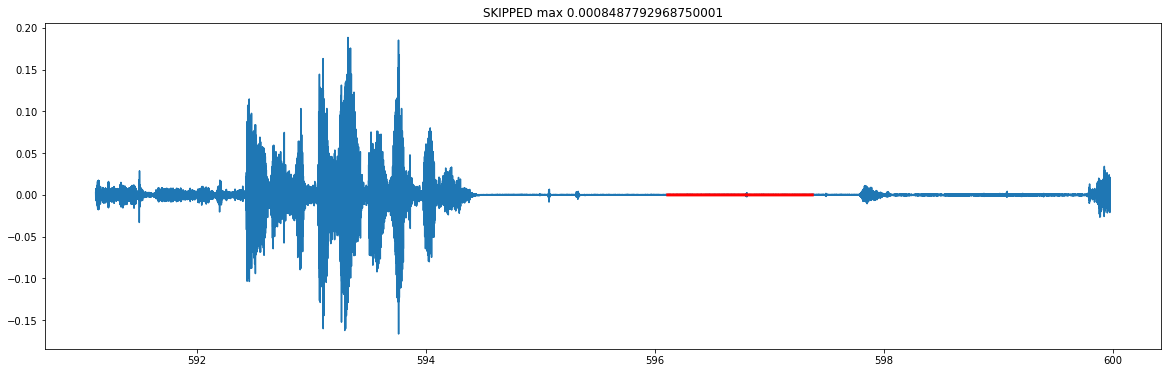

18670 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512, 7518, 7520, 7530, 7539, 7541, 7579, 7582, 8054, 8554, 8949, 8951, 8958, 9319, 9907, 10231, 10234, 10626, 11036, 11038, 11560, 11695, 11697, 11741, 11743, 11797, 11802, 11833, 11835, 11923, 11925, 11928, 11932, 12084, 12087, 12363, 12367, 12827, 13248, 13254, 13656, 13659, 13787, 13795, 13986, 14590, 14817, 14819, 14828, 14831, 14850, 14853, 14950, 14960, 15026, 15031, 15042, 15045, 15052, 15058, 15062, 15066, 15069, 15071, 15075, 15679, 15775, 15777, 16083, 16085, 16527, 16530, 16532, 16866, 17401, 17403, 17985, 17987, 18076, 18078, 18211, 18214, 18216, 18218, 18243, 18246, 18588, 18590, 18592, 18609, 18611, 18613, 18623, 18633, 18641, 18663, 1

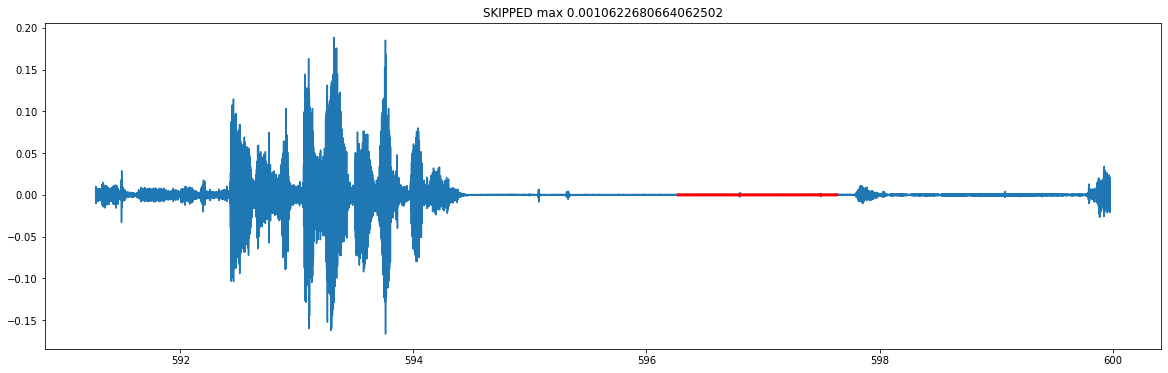

18676 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512, 7518, 7520, 7530, 7539, 7541, 7579, 7582, 8054, 8554, 8949, 8951, 8958, 9319, 9907, 10231, 10234, 10626, 11036, 11038, 11560, 11695, 11697, 11741, 11743, 11797, 11802, 11833, 11835, 11923, 11925, 11928, 11932, 12084, 12087, 12363, 12367, 12827, 13248, 13254, 13656, 13659, 13787, 13795, 13986, 14590, 14817, 14819, 14828, 14831, 14850, 14853, 14950, 14960, 15026, 15031, 15042, 15045, 15052, 15058, 15062, 15066, 15069, 15071, 15075, 15679, 15775, 15777, 16083, 16085, 16527, 16530, 16532, 16866, 17401, 17403, 17985, 17987, 18076, 18078, 18211, 18214, 18216, 18218, 18243, 18246, 18588, 18590, 18592, 18609, 18611, 18613, 18623, 18633, 18641, 18663, 1

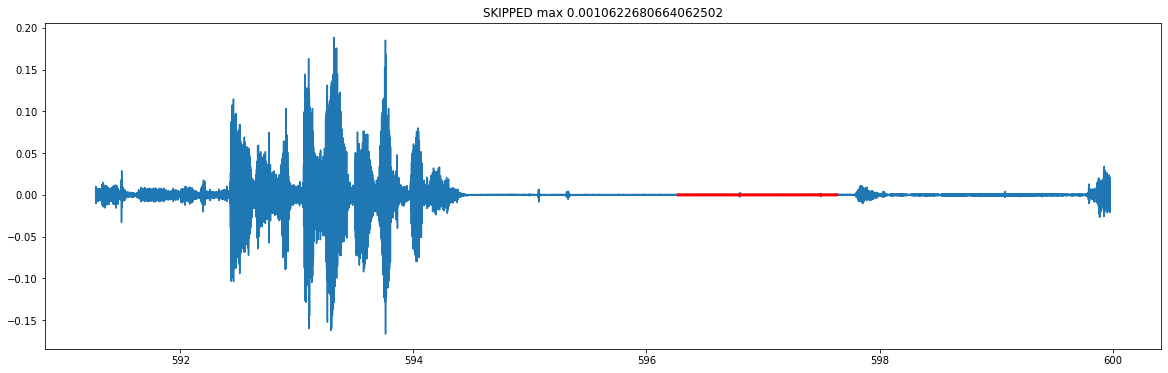

18679 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512, 7518, 7520, 7530, 7539, 7541, 7579, 7582, 8054, 8554, 8949, 8951, 8958, 9319, 9907, 10231, 10234, 10626, 11036, 11038, 11560, 11695, 11697, 11741, 11743, 11797, 11802, 11833, 11835, 11923, 11925, 11928, 11932, 12084, 12087, 12363, 12367, 12827, 13248, 13254, 13656, 13659, 13787, 13795, 13986, 14590, 14817, 14819, 14828, 14831, 14850, 14853, 14950, 14960, 15026, 15031, 15042, 15045, 15052, 15058, 15062, 15066, 15069, 15071, 15075, 15679, 15775, 15777, 16083, 16085, 16527, 16530, 16532, 16866, 17401, 17403, 17985, 17987, 18076, 18078, 18211, 18214, 18216, 18218, 18243, 18246, 18588, 18590, 18592, 18609, 18611, 18613, 18623, 18633, 18641, 18663, 1

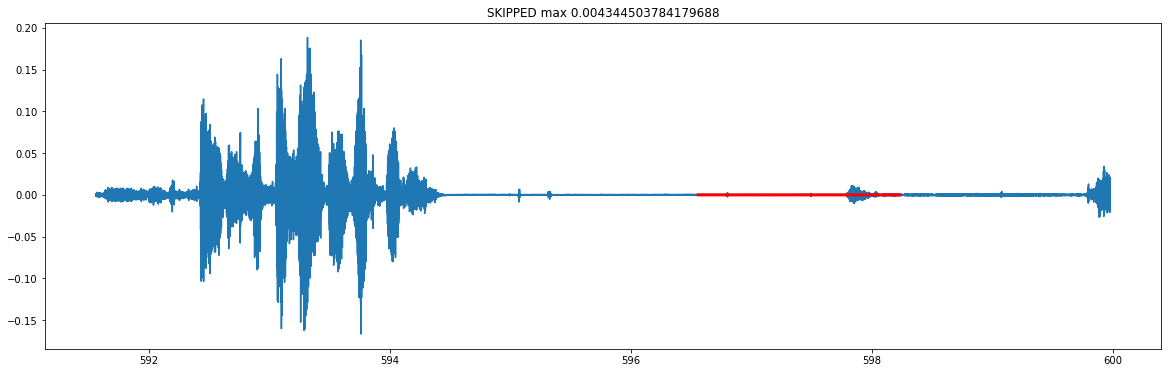

18695 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512, 7518, 7520, 7530, 7539, 7541, 7579, 7582, 8054, 8554, 8949, 8951, 8958, 9319, 9907, 10231, 10234, 10626, 11036, 11038, 11560, 11695, 11697, 11741, 11743, 11797, 11802, 11833, 11835, 11923, 11925, 11928, 11932, 12084, 12087, 12363, 12367, 12827, 13248, 13254, 13656, 13659, 13787, 13795, 13986, 14590, 14817, 14819, 14828, 14831, 14850, 14853, 14950, 14960, 15026, 15031, 15042, 15045, 15052, 15058, 15062, 15066, 15069, 15071, 15075, 15679, 15775, 15777, 16083, 16085, 16527, 16530, 16532, 16866, 17401, 17403, 17985, 17987, 18076, 18078, 18211, 18214, 18216, 18218, 18243, 18246, 18588, 18590, 18592, 18609, 18611, 18613, 18623, 18633, 18641, 18663, 1

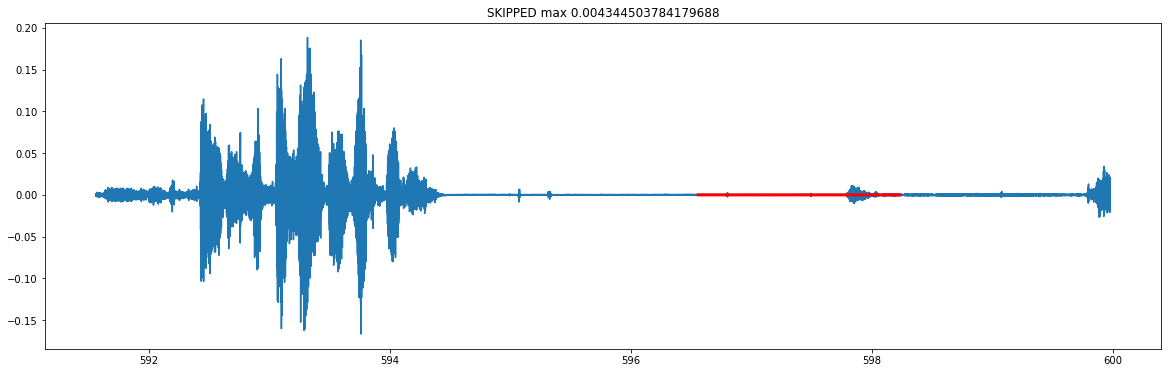

18697 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512, 7518, 7520, 7530, 7539, 7541, 7579, 7582, 8054, 8554, 8949, 8951, 8958, 9319, 9907, 10231, 10234, 10626, 11036, 11038, 11560, 11695, 11697, 11741, 11743, 11797, 11802, 11833, 11835, 11923, 11925, 11928, 11932, 12084, 12087, 12363, 12367, 12827, 13248, 13254, 13656, 13659, 13787, 13795, 13986, 14590, 14817, 14819, 14828, 14831, 14850, 14853, 14950, 14960, 15026, 15031, 15042, 15045, 15052, 15058, 15062, 15066, 15069, 15071, 15075, 15679, 15775, 15777, 16083, 16085, 16527, 16530, 16532, 16866, 17401, 17403, 17985, 17987, 18076, 18078, 18211, 18214, 18216, 18218, 18243, 18246, 18588, 18590, 18592, 18609, 18611, 18613, 18623, 18633, 18641, 18663, 1

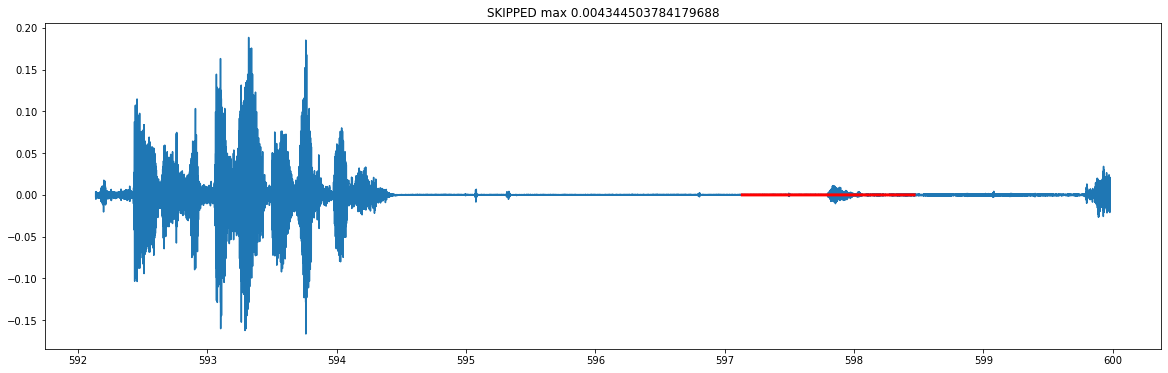

18702 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512, 7518, 7520, 7530, 7539, 7541, 7579, 7582, 8054, 8554, 8949, 8951, 8958, 9319, 9907, 10231, 10234, 10626, 11036, 11038, 11560, 11695, 11697, 11741, 11743, 11797, 11802, 11833, 11835, 11923, 11925, 11928, 11932, 12084, 12087, 12363, 12367, 12827, 13248, 13254, 13656, 13659, 13787, 13795, 13986, 14590, 14817, 14819, 14828, 14831, 14850, 14853, 14950, 14960, 15026, 15031, 15042, 15045, 15052, 15058, 15062, 15066, 15069, 15071, 15075, 15679, 15775, 15777, 16083, 16085, 16527, 16530, 16532, 16866, 17401, 17403, 17985, 17987, 18076, 18078, 18211, 18214, 18216, 18218, 18243, 18246, 18588, 18590, 18592, 18609, 18611, 18613, 18623, 18633, 18641, 18663, 1

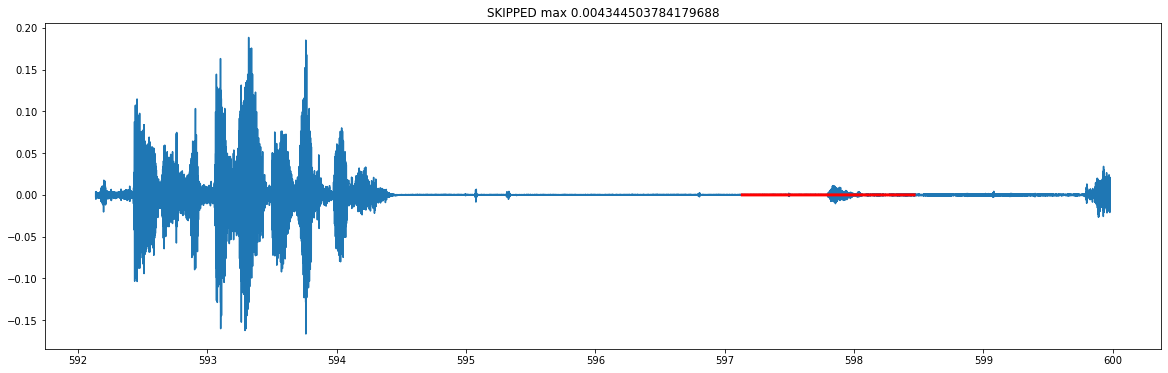

18704 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512, 7518, 7520, 7530, 7539, 7541, 7579, 7582, 8054, 8554, 8949, 8951, 8958, 9319, 9907, 10231, 10234, 10626, 11036, 11038, 11560, 11695, 11697, 11741, 11743, 11797, 11802, 11833, 11835, 11923, 11925, 11928, 11932, 12084, 12087, 12363, 12367, 12827, 13248, 13254, 13656, 13659, 13787, 13795, 13986, 14590, 14817, 14819, 14828, 14831, 14850, 14853, 14950, 14960, 15026, 15031, 15042, 15045, 15052, 15058, 15062, 15066, 15069, 15071, 15075, 15679, 15775, 15777, 16083, 16085, 16527, 16530, 16532, 16866, 17401, 17403, 17985, 17987, 18076, 18078, 18211, 18214, 18216, 18218, 18243, 18246, 18588, 18590, 18592, 18609, 18611, 18613, 18623, 18633, 18641, 18663, 1

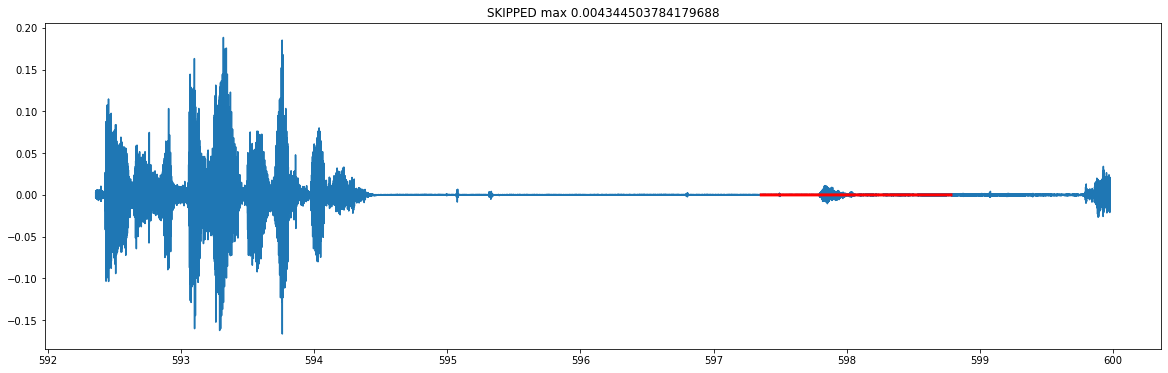

18712 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512, 7518, 7520, 7530, 7539, 7541, 7579, 7582, 8054, 8554, 8949, 8951, 8958, 9319, 9907, 10231, 10234, 10626, 11036, 11038, 11560, 11695, 11697, 11741, 11743, 11797, 11802, 11833, 11835, 11923, 11925, 11928, 11932, 12084, 12087, 12363, 12367, 12827, 13248, 13254, 13656, 13659, 13787, 13795, 13986, 14590, 14817, 14819, 14828, 14831, 14850, 14853, 14950, 14960, 15026, 15031, 15042, 15045, 15052, 15058, 15062, 15066, 15069, 15071, 15075, 15679, 15775, 15777, 16083, 16085, 16527, 16530, 16532, 16866, 17401, 17403, 17985, 17987, 18076, 18078, 18211, 18214, 18216, 18218, 18243, 18246, 18588, 18590, 18592, 18609, 18611, 18613, 18623, 18633, 18641, 18663, 1

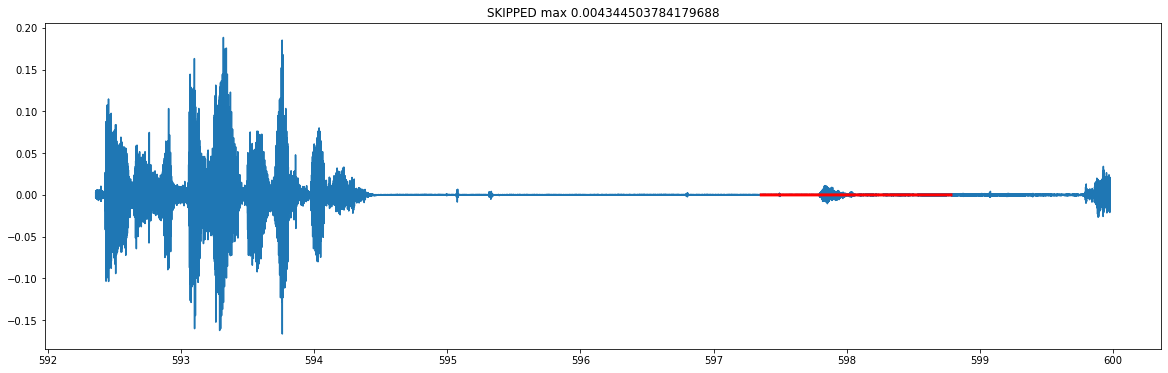

18714 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512, 7518, 7520, 7530, 7539, 7541, 7579, 7582, 8054, 8554, 8949, 8951, 8958, 9319, 9907, 10231, 10234, 10626, 11036, 11038, 11560, 11695, 11697, 11741, 11743, 11797, 11802, 11833, 11835, 11923, 11925, 11928, 11932, 12084, 12087, 12363, 12367, 12827, 13248, 13254, 13656, 13659, 13787, 13795, 13986, 14590, 14817, 14819, 14828, 14831, 14850, 14853, 14950, 14960, 15026, 15031, 15042, 15045, 15052, 15058, 15062, 15066, 15069, 15071, 15075, 15679, 15775, 15777, 16083, 16085, 16527, 16530, 16532, 16866, 17401, 17403, 17985, 17987, 18076, 18078, 18211, 18214, 18216, 18218, 18243, 18246, 18588, 18590, 18592, 18609, 18611, 18613, 18623, 18633, 18641, 18663, 1

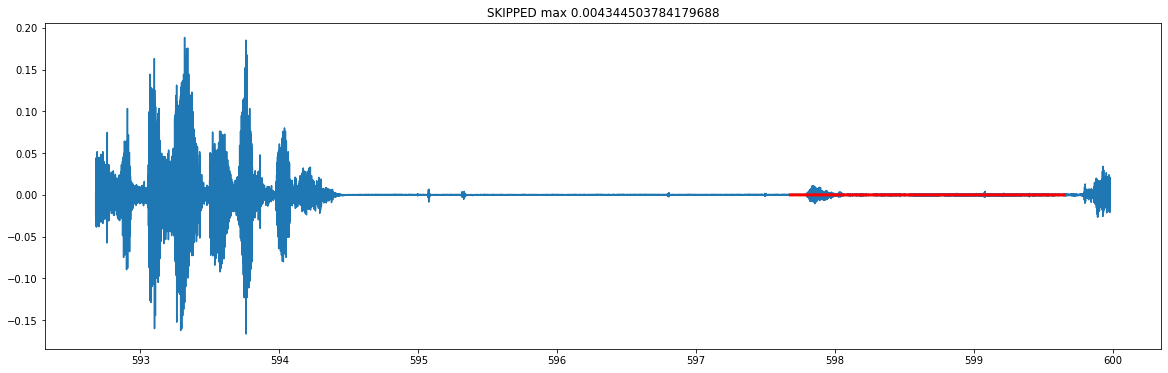

18739 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512, 7518, 7520, 7530, 7539, 7541, 7579, 7582, 8054, 8554, 8949, 8951, 8958, 9319, 9907, 10231, 10234, 10626, 11036, 11038, 11560, 11695, 11697, 11741, 11743, 11797, 11802, 11833, 11835, 11923, 11925, 11928, 11932, 12084, 12087, 12363, 12367, 12827, 13248, 13254, 13656, 13659, 13787, 13795, 13986, 14590, 14817, 14819, 14828, 14831, 14850, 14853, 14950, 14960, 15026, 15031, 15042, 15045, 15052, 15058, 15062, 15066, 15069, 15071, 15075, 15679, 15775, 15777, 16083, 16085, 16527, 16530, 16532, 16866, 17401, 17403, 17985, 17987, 18076, 18078, 18211, 18214, 18216, 18218, 18243, 18246, 18588, 18590, 18592, 18609, 18611, 18613, 18623, 18633, 18641, 18663, 1

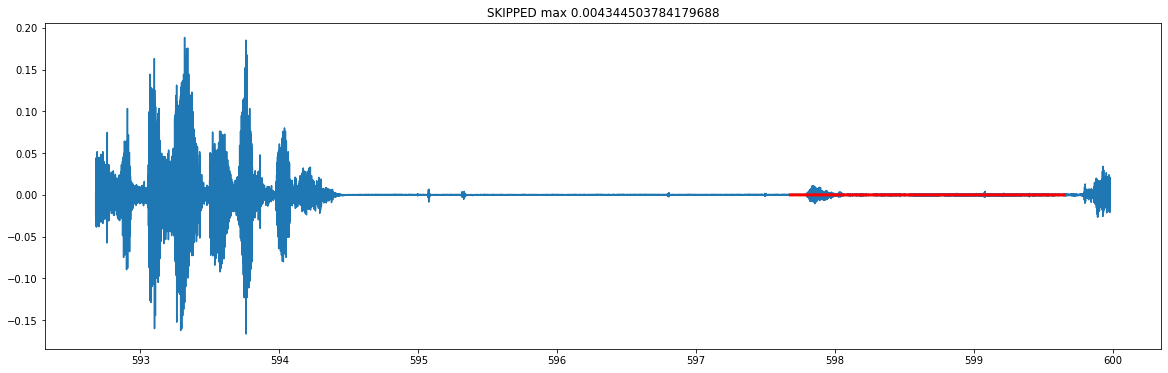

18741 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512, 7518, 7520, 7530, 7539, 7541, 7579, 7582, 8054, 8554, 8949, 8951, 8958, 9319, 9907, 10231, 10234, 10626, 11036, 11038, 11560, 11695, 11697, 11741, 11743, 11797, 11802, 11833, 11835, 11923, 11925, 11928, 11932, 12084, 12087, 12363, 12367, 12827, 13248, 13254, 13656, 13659, 13787, 13795, 13986, 14590, 14817, 14819, 14828, 14831, 14850, 14853, 14950, 14960, 15026, 15031, 15042, 15045, 15052, 15058, 15062, 15066, 15069, 15071, 15075, 15679, 15775, 15777, 16083, 16085, 16527, 16530, 16532, 16866, 17401, 17403, 17985, 17987, 18076, 18078, 18211, 18214, 18216, 18218, 18243, 18246, 18588, 18590, 18592, 18609, 18611, 18613, 18623, 18633, 18641, 18663, 1

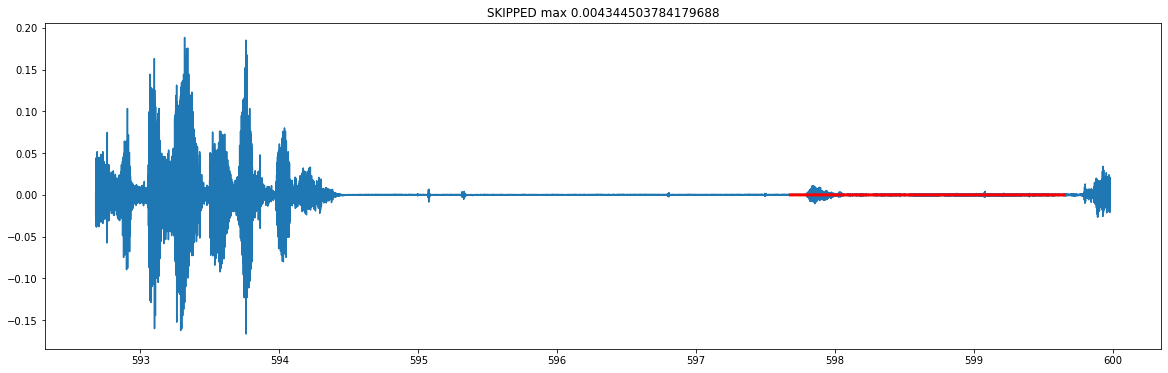

18743 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512, 7518, 7520, 7530, 7539, 7541, 7579, 7582, 8054, 8554, 8949, 8951, 8958, 9319, 9907, 10231, 10234, 10626, 11036, 11038, 11560, 11695, 11697, 11741, 11743, 11797, 11802, 11833, 11835, 11923, 11925, 11928, 11932, 12084, 12087, 12363, 12367, 12827, 13248, 13254, 13656, 13659, 13787, 13795, 13986, 14590, 14817, 14819, 14828, 14831, 14850, 14853, 14950, 14960, 15026, 15031, 15042, 15045, 15052, 15058, 15062, 15066, 15069, 15071, 15075, 15679, 15775, 15777, 16083, 16085, 16527, 16530, 16532, 16866, 17401, 17403, 17985, 17987, 18076, 18078, 18211, 18214, 18216, 18218, 18243, 18246, 18588, 18590, 18592, 18609, 18611, 18613, 18623, 18633, 18641, 18663, 1

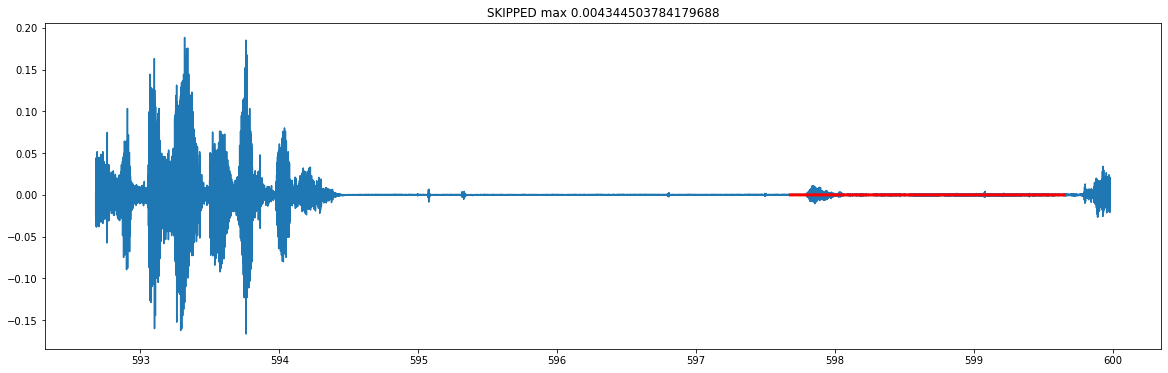

18745 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512, 7518, 7520, 7530, 7539, 7541, 7579, 7582, 8054, 8554, 8949, 8951, 8958, 9319, 9907, 10231, 10234, 10626, 11036, 11038, 11560, 11695, 11697, 11741, 11743, 11797, 11802, 11833, 11835, 11923, 11925, 11928, 11932, 12084, 12087, 12363, 12367, 12827, 13248, 13254, 13656, 13659, 13787, 13795, 13986, 14590, 14817, 14819, 14828, 14831, 14850, 14853, 14950, 14960, 15026, 15031, 15042, 15045, 15052, 15058, 15062, 15066, 15069, 15071, 15075, 15679, 15775, 15777, 16083, 16085, 16527, 16530, 16532, 16866, 17401, 17403, 17985, 17987, 18076, 18078, 18211, 18214, 18216, 18218, 18243, 18246, 18588, 18590, 18592, 18609, 18611, 18613, 18623, 18633, 18641, 18663, 1

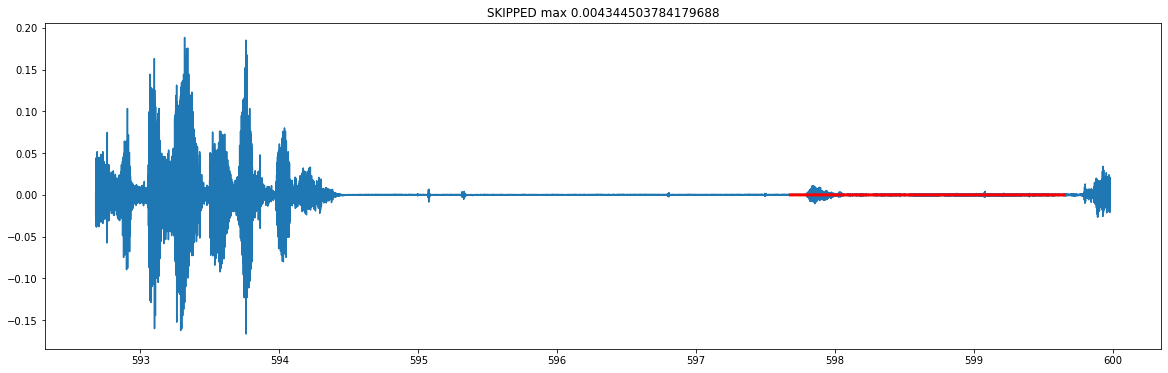

18747 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512, 7518, 7520, 7530, 7539, 7541, 7579, 7582, 8054, 8554, 8949, 8951, 8958, 9319, 9907, 10231, 10234, 10626, 11036, 11038, 11560, 11695, 11697, 11741, 11743, 11797, 11802, 11833, 11835, 11923, 11925, 11928, 11932, 12084, 12087, 12363, 12367, 12827, 13248, 13254, 13656, 13659, 13787, 13795, 13986, 14590, 14817, 14819, 14828, 14831, 14850, 14853, 14950, 14960, 15026, 15031, 15042, 15045, 15052, 15058, 15062, 15066, 15069, 15071, 15075, 15679, 15775, 15777, 16083, 16085, 16527, 16530, 16532, 16866, 17401, 17403, 17985, 17987, 18076, 18078, 18211, 18214, 18216, 18218, 18243, 18246, 18588, 18590, 18592, 18609, 18611, 18613, 18623, 18633, 18641, 18663, 1

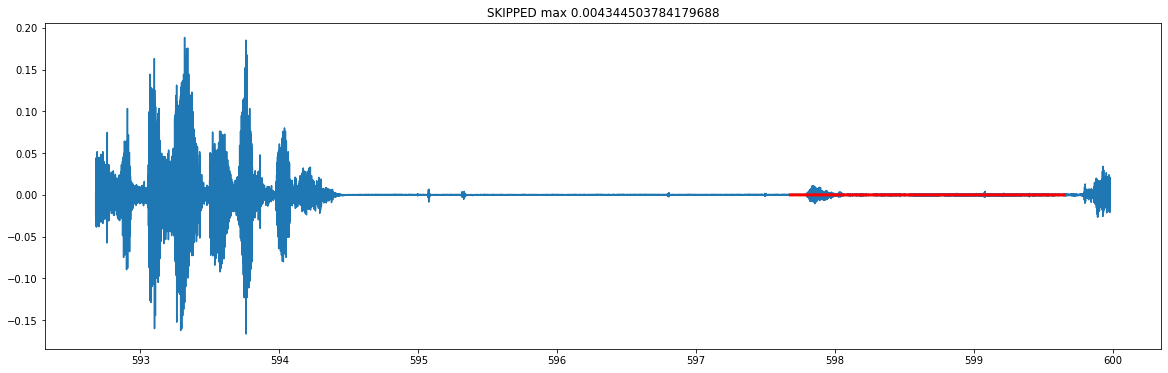

18749 [0, 240, 723, 726, 859, 861, 864, 895, 899, 910, 912, 1082, 1684, 1809, 1813, 2089, 2091, 2428, 2431, 2434, 2440, 2716, 2719, 2824, 2826, 3127, 3129, 3132, 3266, 3273, 3659, 3911, 3914, 4197, 4199, 4477, 4872, 4874, 5495, 5814, 5816, 5998, 6456, 6458, 6625, 7097, 7099, 7264, 7267, 7270, 7272, 7283, 7302, 7308, 7498, 7501, 7504, 7507, 7512, 7518, 7520, 7530, 7539, 7541, 7579, 7582, 8054, 8554, 8949, 8951, 8958, 9319, 9907, 10231, 10234, 10626, 11036, 11038, 11560, 11695, 11697, 11741, 11743, 11797, 11802, 11833, 11835, 11923, 11925, 11928, 11932, 12084, 12087, 12363, 12367, 12827, 13248, 13254, 13656, 13659, 13787, 13795, 13986, 14590, 14817, 14819, 14828, 14831, 14850, 14853, 14950, 14960, 15026, 15031, 15042, 15045, 15052, 15058, 15062, 15066, 15069, 15071, 15075, 15679, 15775, 15777, 16083, 16085, 16527, 16530, 16532, 16866, 17401, 17403, 17985, 17987, 18076, 18078, 18211, 18214, 18216, 18218, 18243, 18246, 18588, 18590, 18592, 18609, 18611, 18613, 18623, 18633, 18641, 18663, 1

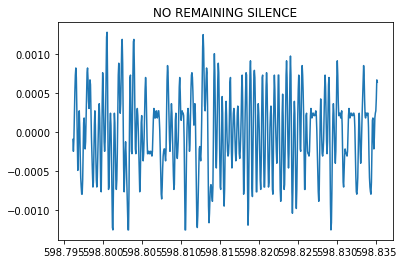

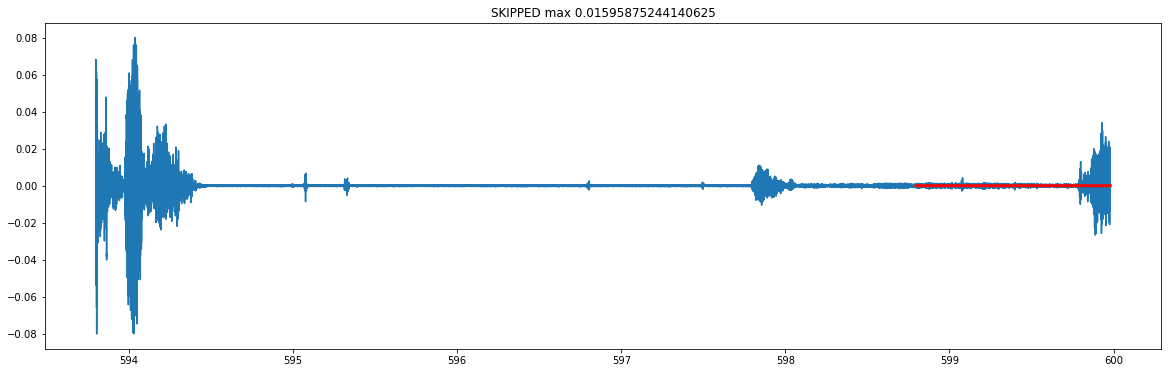

In [30]:
while read_head < max_read_head:
    print(read_head, read_heads)
    finished = False
    while not finished and read_head < max_read_head:
        print(f"READ_HEAD {read_head}")
        for cutoff in cutoffs:
            speech_q=(s_dB_mean[read_head:]>cutoff)
            silences=collect_false(speech_q)
            silences=[(x,y) for x,y in silences if x != y and y-x > min_samples]
            n_silences = len(silences)
            print(f'cutoff {cutoff} #silences {n_silences}: {silences[0:10]}')
            if n_silences==0:
                continue
            elif silences[0][0] == 0 and silences[0][1] != 0:
                read_head +=silences[0][1]
                print("advance past silence", read_head, silences[0][1])
                finished = True
                break
            elif silences[0][0] > max_samples:
                continue
            else:
                silences=[(x,y) for x,y in silences if x <= max_samples]
                if not len(silences):
                    continue
                start_at = read_head
                stop_at= read_head + silences[0][0]
                read_head = stop_at
                print("stop to read", start_at, stop_at)
                finished = True
                break
        if not finished:
            display_start=read_head*samples_per_spect
            display_end=display_start+max_samples
            plot(X[display_start:display_end],audio[display_start:display_end])
            title(f'NO REMAINING SILENCE')
            show()
            start_at = read_head
            stop_at = min(max_read_head, read_head + max_samples)
            read_head = stop_at
            finished = True
    read_heads.append(read_head)
    start=start_at*samples_per_spect
    end=start_at+stop_at*samples_per_spect

    figure(figsize=(20,6))
    display_start=max(0, start-5*C.sample_rate)
    display_end=end+5*C.sample_rate
    smooth_abs=smoothhtooms(np.abs(audio[start:end]), 100)
    smooth_abs_max=smooth_abs.max()
    if smooth_abs_max < 0.05:
        plot(X[display_start:display_end],audio[display_start:display_end])
        plot(X[start:end],Z[start:end],color='red',linewidth=3)
        title(f'SKIPPED max {smooth_abs_max}')
        show()
    else:
        plot(X[display_start:display_end],audio[display_start:display_end])
        plot(X[start:end],Z[start:end],color='red',linewidth=3)
        title('INCLUDED')
        show()
        try:
            segment_transcript, timeline, normalized_power, speech_mask, clip_audio=predicted_segment_transcript(C, model, audio, start, end, s_dB_mean, samples_per_spect, dt_S)
            transcriptions.extend(segment_transcript)
            plot_predicted_segments(timeline, normalized_power, speech_mask, segment_transcript, gold)
            show()
        except:
            print("empty translation")

In [31]:
from listen_and_transcribe import listen_and_transcribe
transcript=listen_and_transcribe(C, model, max_duration, gold, audio)

[NeMo I 2020-10-30 12:40:57 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 12:40:57 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |a lô a lô anh Tiên à g|
[NeMo I 2020-10-30 12:40:58 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 12:40:58 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |để hôm trước cá độ tã sáo hả chếc cá độ báng đá sao rồi hử hả bạo rồi|
[NeMo I 2020-10-30 12:40:58 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 12:40:58 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |để hôm trưếc cá độ tã sáo hả chếc cá độ báng đá sao rồi hử hả bạo rồi|
[NeMo I 2020-10-30 12:40:58 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 12:40:58 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |Thiều vẫn về|
[NeMo I 2020-10-30 12:40:58 collections:

[NeMo I 2020-10-30 12:41:02 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 12:41:02 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |ừhì nồi bảy giờ ngủ đến bảy giờ xong bắt đầu là tấy nh em đì mìnhmen em cũng biết tý bảo thôi vậy kiểu gì ông ấ chẳng ng mủ thêm ấy ấy tấ đây|
[NeMo I 2020-10-30 12:41:02 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 12:41:02 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |ừhì nồi bảy giờ gủ đến bảy giờ xong bắt đầu là tấy nh em đì mìnhmem em cũng biết tý bảo thôi vậy kiểu gì ông ấ chẳng ng mủ thêm ấy ấy tấ đây|
[NeMo I 2020-10-30 12:41:02 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 12:41:02 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |hôn m mấy ềm về ăn cơm sớm năm giờ xong bắt đầu làm một khác đữn sáu giờ đ xổng cần sáu giờ lúc cọi dậy còn đang muốn ngủ tiếp thấ

PREDICTION |thết đấy em em bảo là sim của cô sao ấy cháu gọi bao lần mà cái sim kia không được thế hôm nay cô dùng dunái số sim nạài|
[NeMo I 2020-10-30 12:41:05 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 12:41:05 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |môi tìm mại tể ái đến đợt vừa rồi này lại thấy bà ấy long dong trên đường tái xuất giang hồ thứ đi bốt rổg hôn|
[NeMo I 2020-10-30 12:41:05 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 12:41:05 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |môi tìm mại tể ái đến đợt vừa rồi này lại thấy bà ấy long dong trên đường tái xuất giang hồ chứ đi bốt rổg hôn|
[NeMo I 2020-10-30 12:41:05 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 12:41:05 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |hông thế bải bảo xây nhà rbên cầu đấi bnh cầu đầu Quan ấy

In [32]:
len(transcriptions)

1255

In [33]:
len(transcript)

1254